# Book Club Assignment 1 - Bank Marketing Data
Source: http://spark.apache.org

## Attribute Information:

### Input variables:

#### bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')
#### related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular','telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
#### other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
#### social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: 'yes','no')



In [1]:
import numpy as np
import scipy
from scipy.stats import uniform,truncnorm,randint,loguniform

import pandas as pd

import os
import pickle
import time
from joblib import dump, load

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import sklearn
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,\
                                    StratifiedKFold,TimeSeriesSplit, \
                                    cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report,plot_confusion_matrix, average_precision_score, \
                            plot_precision_recall_curve,roc_auc_score,roc_curve, auc,log_loss,confusion_matrix
from sklearn.ensemble import RandomForestClassifier,VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
from sklearn.linear_model import LogisticRegression,SGDClassifier

In [3]:
import statsmodels.formula.api as smf
import seaborn as sns
sns.set_style('white')

In [4]:
from skopt.space import Real,Integer,Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

In [5]:
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.activations import selu
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization, LeakyReLU, PReLU, ELU, AlphaDropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2,l1,l1_l2
from tensorflow.keras.optimizers import SGD,Adam,Nadam
from tensorflow.keras.initializers import he_uniform,he_normal
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# 1. Import Dataset

In [6]:
pwd

'/Users/kunhu/Dropbox/JPM/UCI Data'

In [7]:
df = pd.read_csv('./bank-additional/bank-additional-full.csv',sep = ';')\
        .assign(y = lambda df: 1*(df['y']=='yes'))
df.head().T

0            1            2            3  \
age                      56           57           37           40   
job               housemaid     services     services       admin.   
marital             married      married      married      married   
education          basic.4y  high.school  high.school     basic.6y   
default                  no      unknown           no           no   
housing                  no           no          yes           no   
loan                     no           no           no           no   
contact           telephone    telephone    telephone    telephone   
month                   may          may          may          may   
day_of_week             mon          mon          mon          mon   
duration                261          149          226          151   
campaign                  1            1            1            1   
pdays                   999          999          999          999   
previous                  0            0            0            0   
poutcome        nonexistent  nonexistent  nonexistent  nonexistent   
emp.var.rate            1.1          1.1          1.1          1.1   
cons.price.idx       93.994       93.994       93.994       93.994   
cons.conf.idx         -36.4        -36.4        -36.4        -36.4   
euribor3m             4.857        4.857        4.857        4.857   
nr.employed            5191         5191         5191         5191   
y                         0            0            0            0   

                          4  
age                      56  
job                services  
marital             married  
education       high.school  
default                  no  
housing                  no  
loan                    yes  
contact           telephone  
month                   may  
day_of_week             mon  
duration                307  
campaign                  1  
pdays                   999  
previous                  0  
poutcome        nonexistent  
emp.var.rate            1.1  
cons.price.idx       93.994  
cons.conf.idx         -36.4  
euribor3m             4.857  
nr.employed            5191  
y                         0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [9]:
print('Numerical Data')
df.describe(include = 'number')

Numerical Data


age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m  \
count  41188.000000    41188.000000   41188.000000  41188.000000   
mean       0.081886       93.575664     -40.502600      3.621291   
std        1.570960        0.578840       4.628198      1.734447   
min       -3.400000       92.201000     -50.800000      0.634000   
25%       -1.800000       93.075000     -42.700000      1.344000   
50%        1.100000       93.749000     -41.800000      4.857000   
75%        1.400000       93.994000     -36.400000      4.961000   
max        1.400000       94.767000     -26.900000      5.045000   

        nr.employed             y  
count  41188.000000  41188.000000  
mean    5167.035911      0.112654  
std       72.251528      0.316173  
min     4963.600000      0.000000  
25%     5099.100000      0.000000  
50%     5191.000000      0.000000  
75%     5228.100000      0.000000  
max     5228.100000      1.000000

In [10]:
print('Categorical Data')
df.describe(exclude = 'number')

Categorical Data


job  marital          education default housing   loan   contact  \
count    41188    41188              41188   41188   41188  41188     41188   
unique      12        4                  8       3       3      3         2   
top     admin.  married  university.degree      no     yes     no  cellular   
freq     10422    24928              12168   32588   21576  33950     26144   

        month day_of_week     poutcome  
count   41188       41188        41188  
unique     10           5            3  
top       may         thu  nonexistent  
freq    13769        8623        35563

# 2. EDA

In [11]:
client_list_num = ['age']
client_list_cat = 'job marital education default housing loan'.split()
other_list_cat = 'contact month day_of_week poutcome'.split()
other_list_num = 'campaign pdays previous emp.var.rate cons.price.idx euribor3m nr.employed'.split()

## 2.1 Categorical Variables

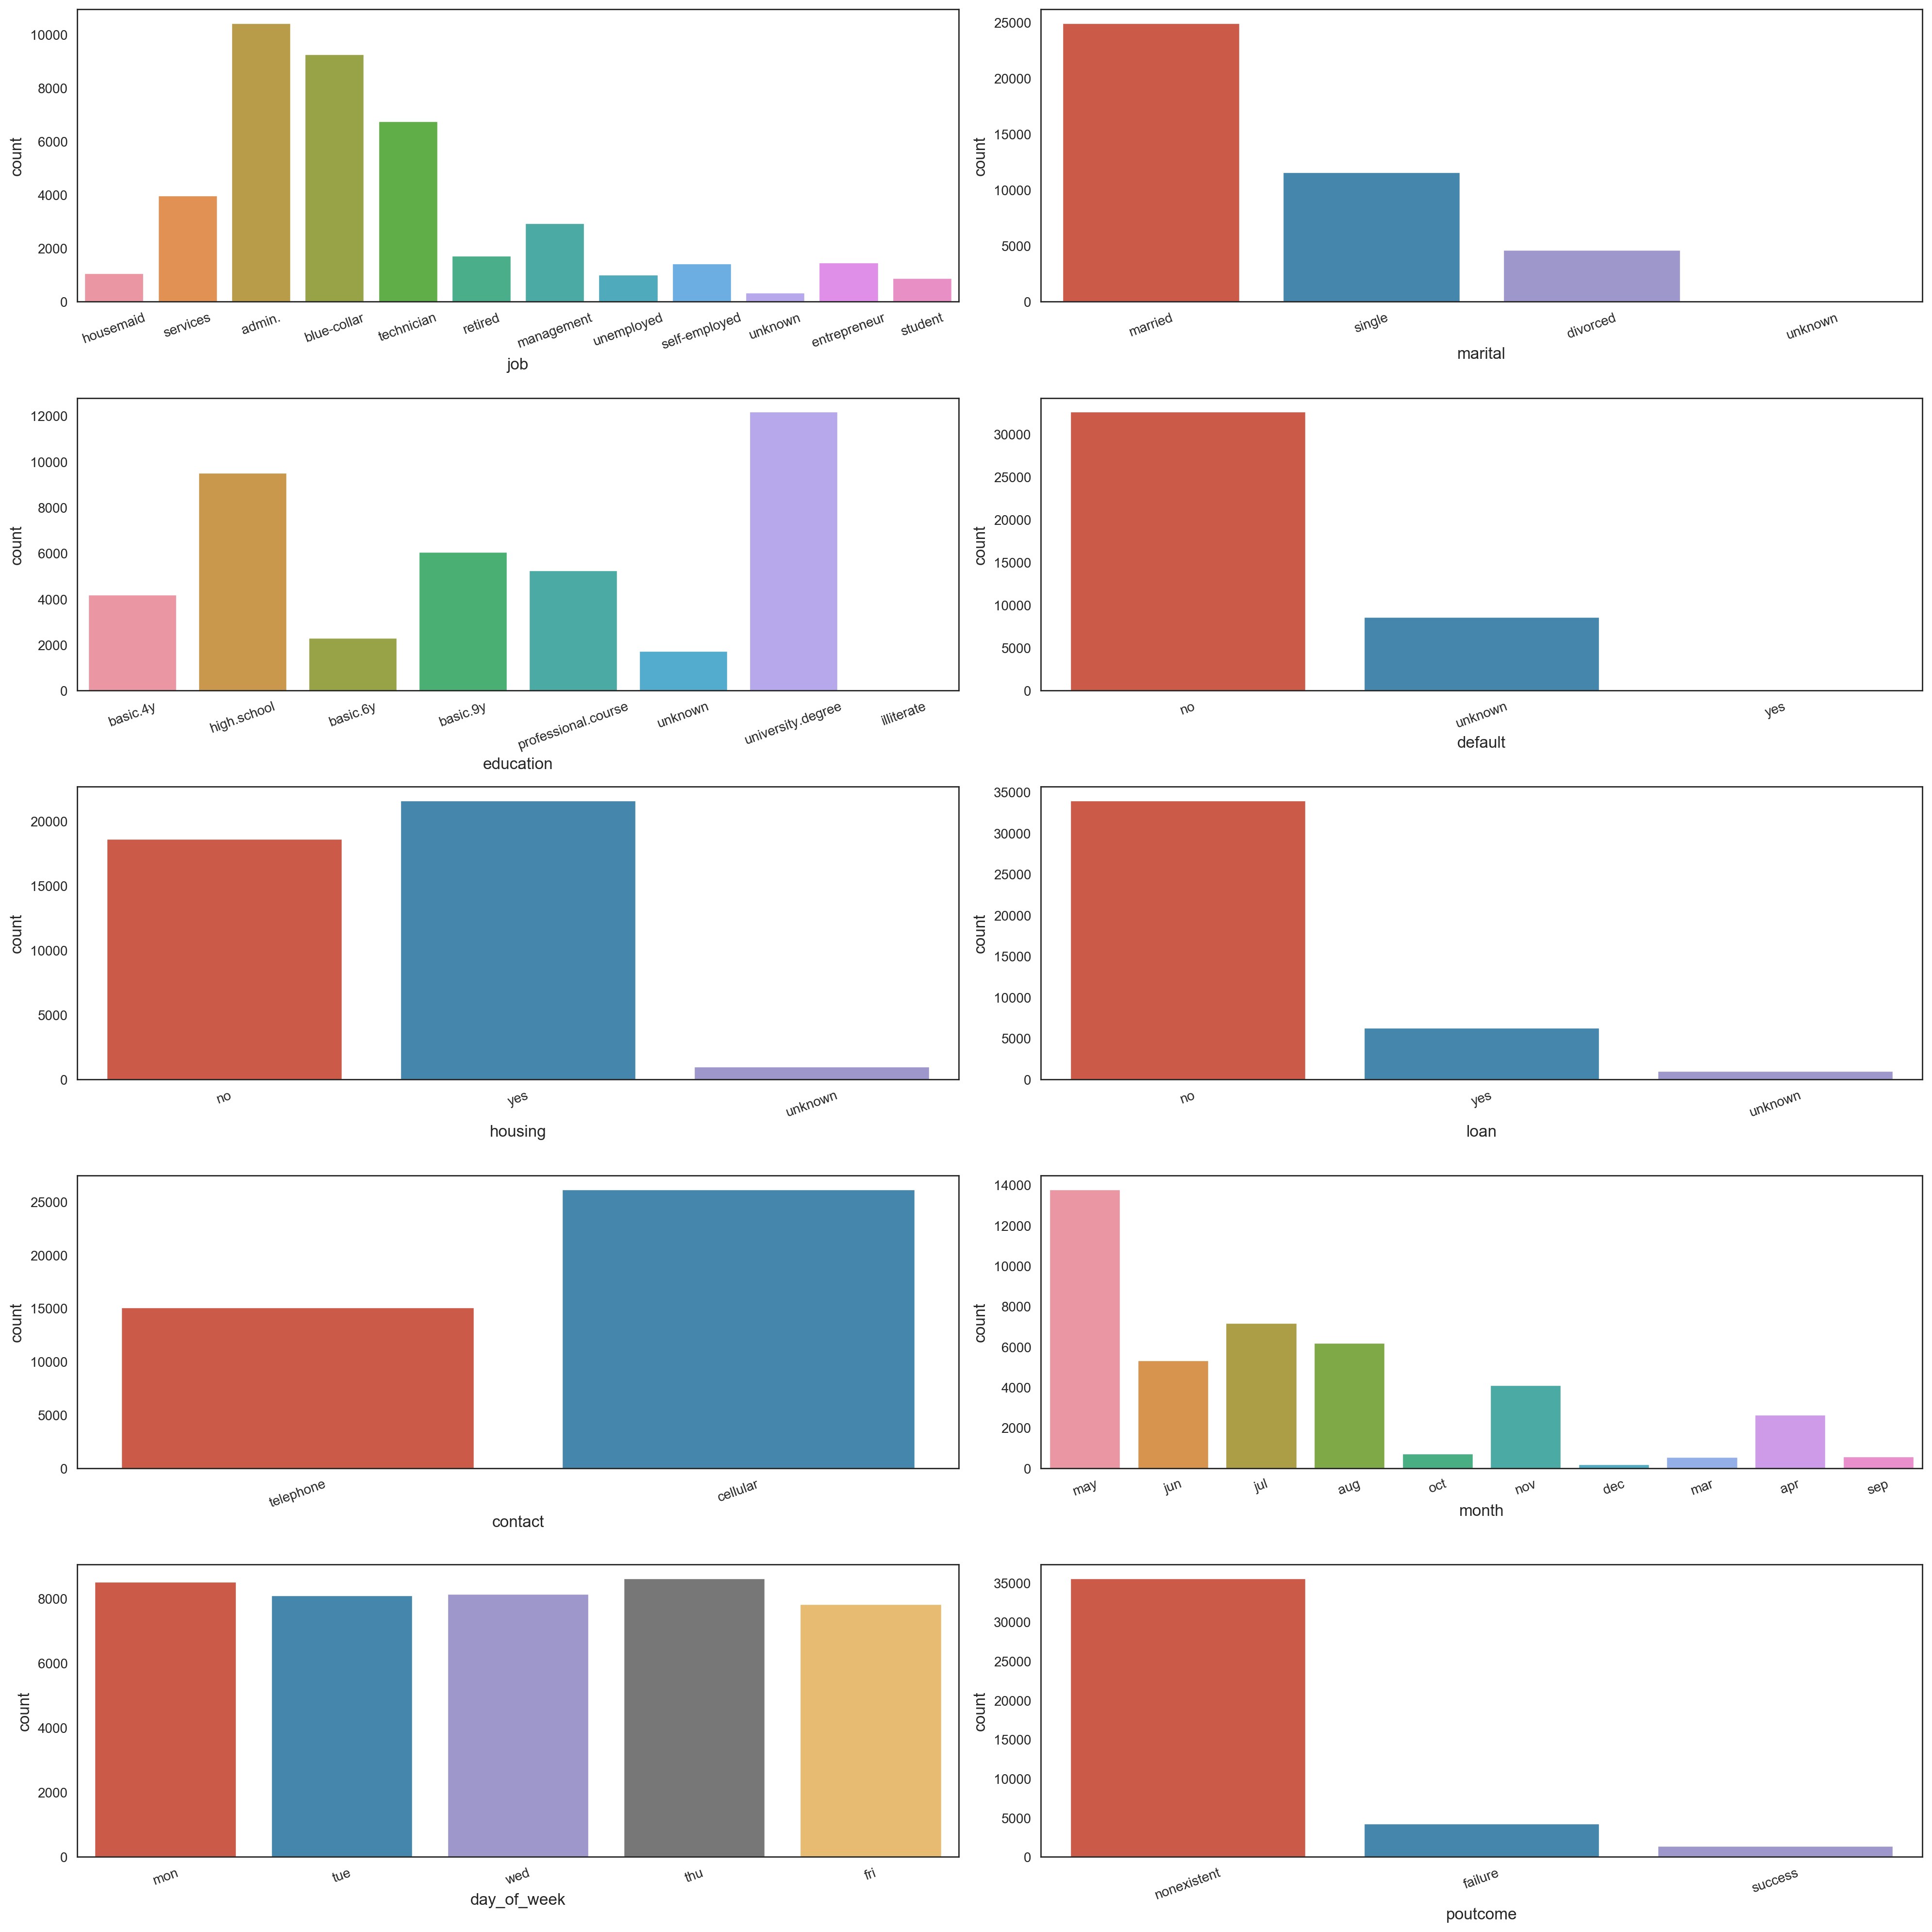

In [12]:
fig,ax = plt.subplots(5,2,figsize=(20,20),dpi=200)
ax = ax.flatten()
for i,arg in enumerate(client_list_cat + other_list_cat):
    sns.countplot(x=arg,data = df,ax = ax[i])
    ax[i].tick_params(axis='x', rotation=20)
plt.tight_layout()

Not too much info from the above, other than that some categories are not balanced
- Now the share of YES by categories

In [13]:
df_cat = df[client_list_cat + other_list_cat + ['y']].melt(id_vars=['y'],value_vars = client_list_cat + other_list_cat)
df_cat = df_cat.drop(columns = 'y').drop_duplicates(['variable','value']).merge(\
    pd.DataFrame(df_cat.groupby(['variable','value']).agg({'y':'mean'}).reset_index()),
    on = ['variable','value'],suffixes = [False,False],validate = "1:1")


In [14]:
df_cat.set_index( ['variable','value'])

y
variable    value                        
job         housemaid            0.100000
            services             0.081381
            admin.               0.129726
            blue-collar          0.068943
            technician           0.108260
            retired              0.252326
            management           0.112175
            unemployed           0.142012
            self-employed        0.104856
            unknown              0.112121
            entrepreneur         0.085165
            student              0.314286
marital     married              0.101573
            single               0.140041
            divorced             0.103209
            unknown              0.150000
education   basic.4y             0.102490
            high.school          0.108355
            basic.6y             0.082024
            basic.9y             0.078246
            professional.course  0.113485
            unknown              0.145003
            university.degree    0.137245
            illiterate           0.222222
default     no                   0.128790
            unknown              0.051530
            yes                  0.000000
housing     no                   0.108796
            yes                  0.116194
            unknown              0.108081
loan        no                   0.113402
            yes                  0.109315
            unknown              0.108081
contact     telephone            0.052313
            cellular             0.147376
month       may                  0.064347
            jun                  0.105115
            jul                  0.090466
            aug                  0.106021
            oct                  0.438719
            nov                  0.101439
            dec                  0.489011
            mar                  0.505495
            apr                  0.204787
            sep                  0.449123
day_of_week mon                  0.099483
            tue                  0.117800
            wed                  0.116671
            thu                  0.121188
            fri                  0.108087
poutcome    nonexistent          0.088322
            failure              0.142286
            success              0.651129

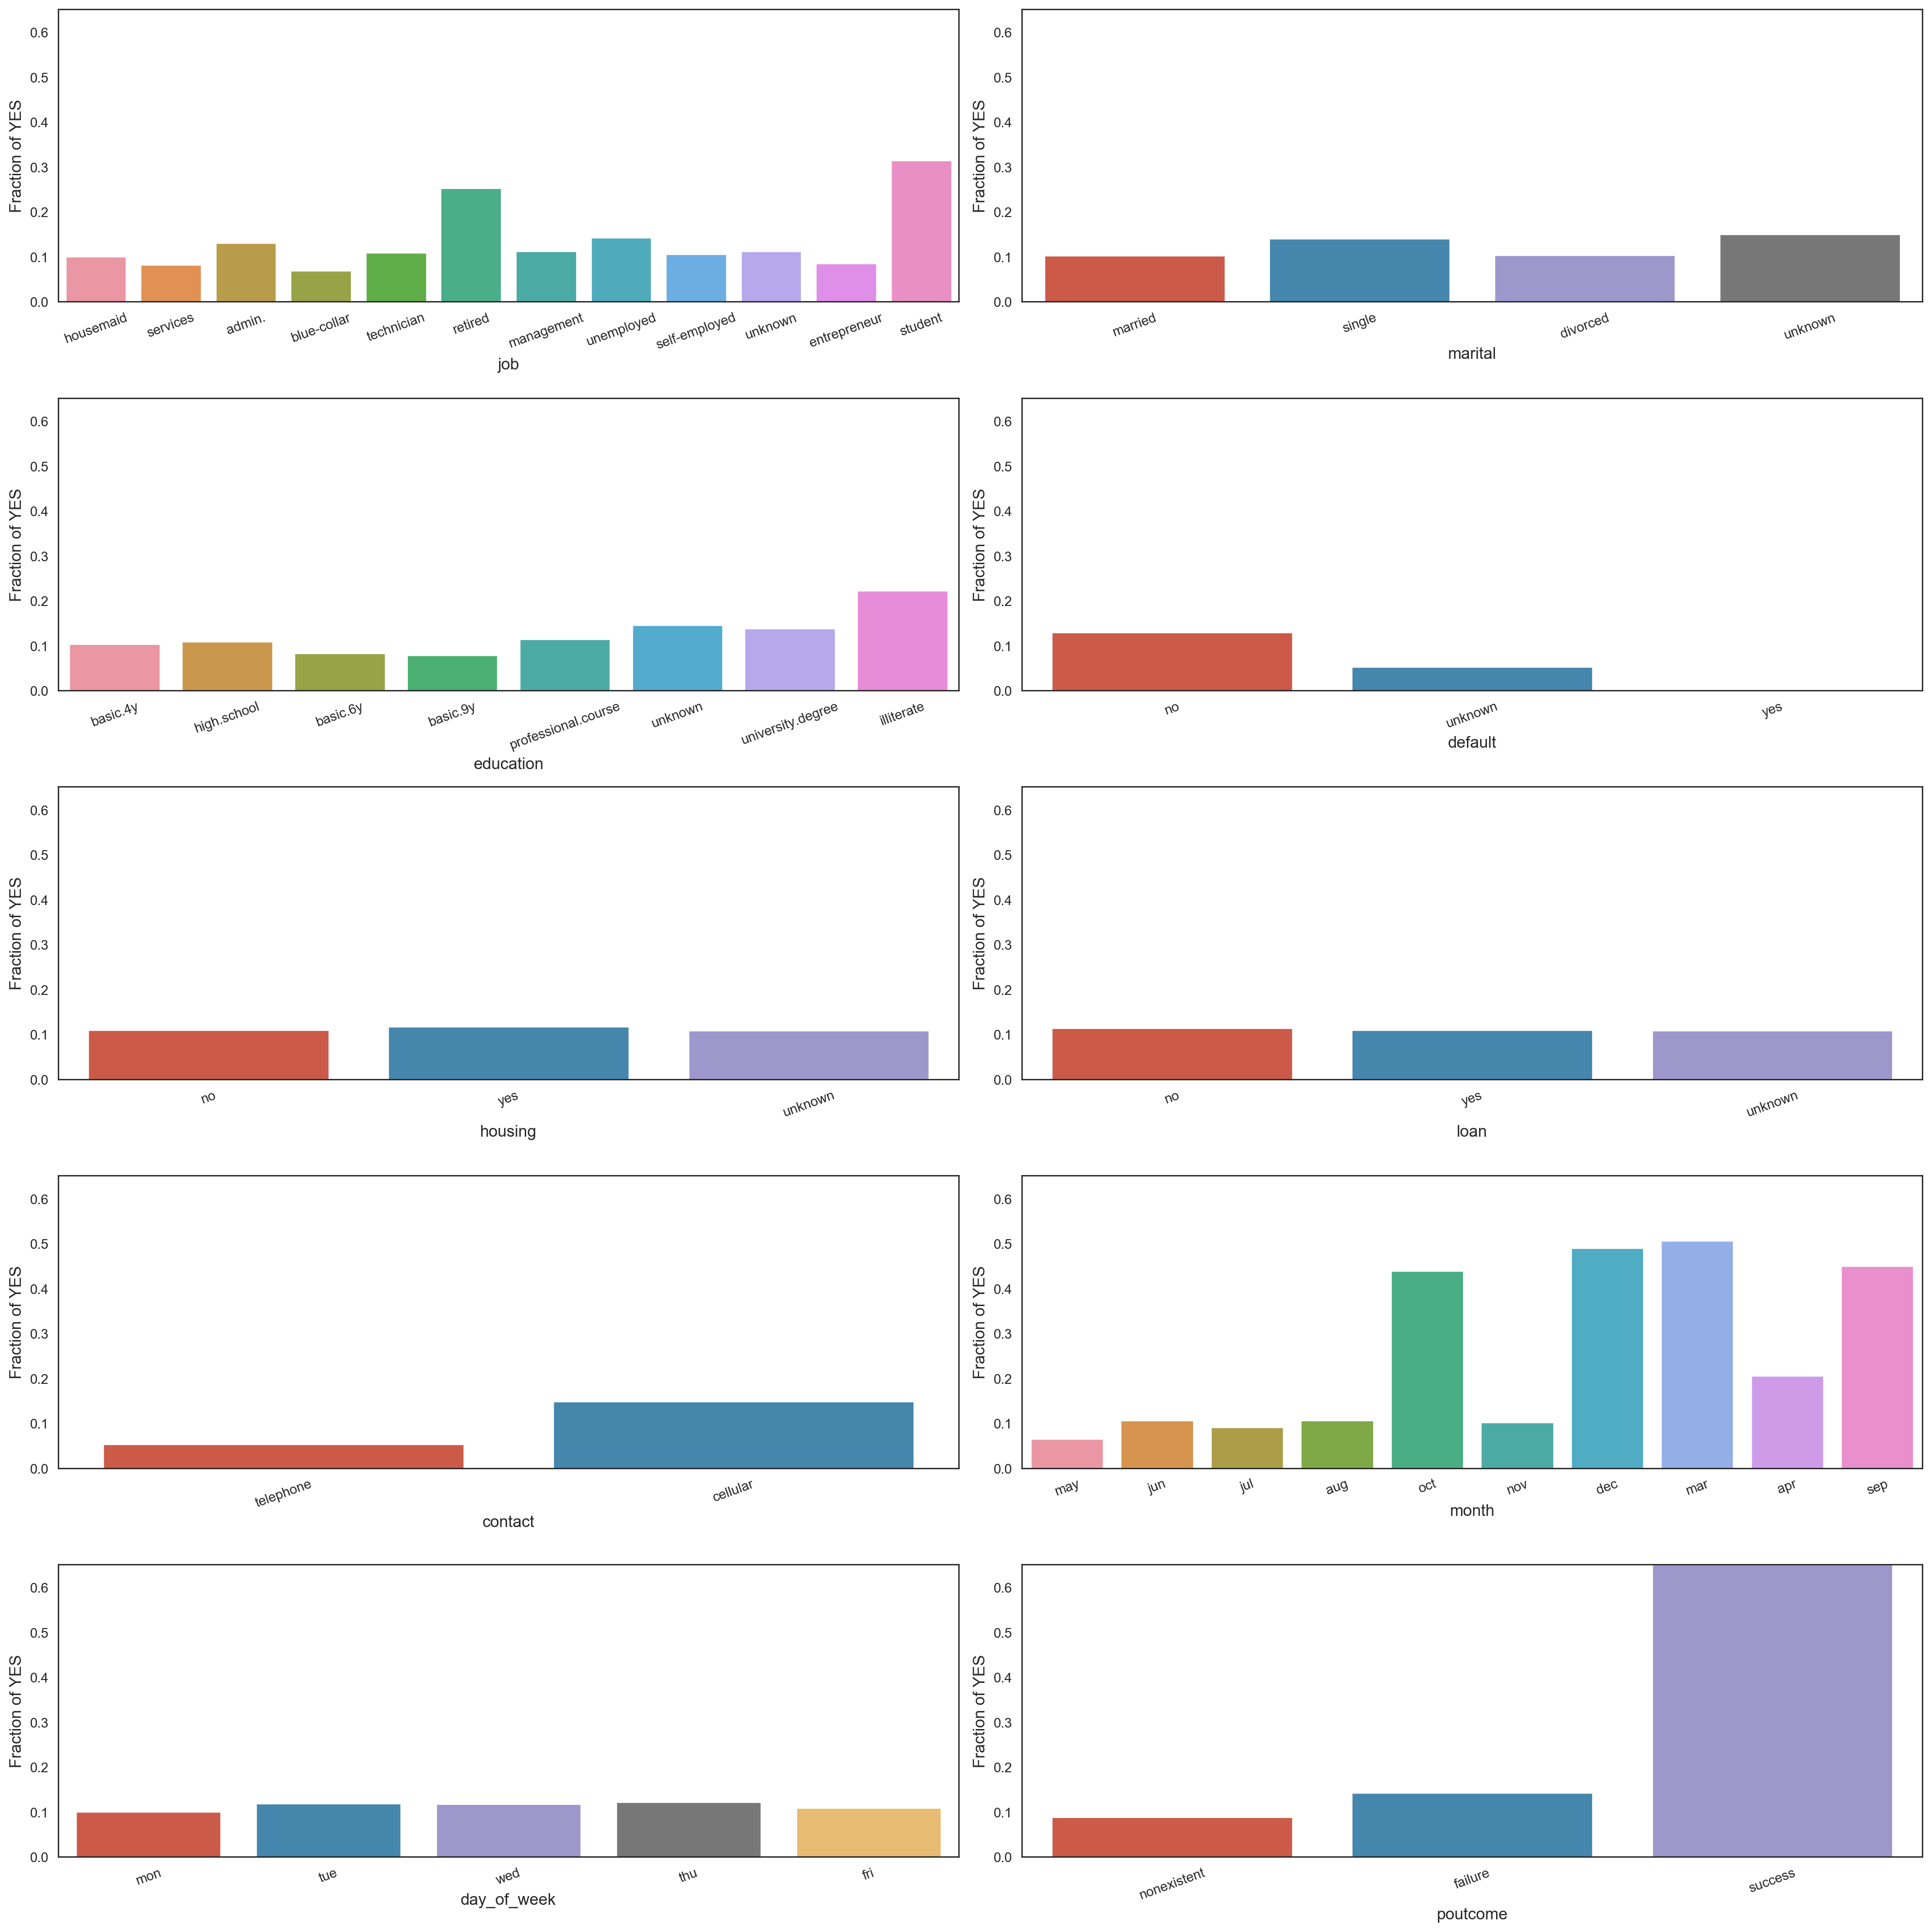

In [15]:
fig,ax = plt.subplots(5,2,figsize=(20,20),dpi=200)
ax = ax.flatten()
for i,arg in enumerate(client_list_cat + other_list_cat):
    sns.barplot(y='y',x = 'value',data =df_cat.query(f'variable =="{arg}"'),ax = ax[i])
    ax[i].tick_params(axis='x', rotation=20)
    ax[i].set_ylabel('Fraction of YES')
    ax[i].set_ylim((0,df_cat.y.max()))
    ax[i].set_xlabel(arg)
plt.tight_layout()

### Conclusion for Categorical Variables
- For univariate predictions:
    - Job, education, contact, default, month and previous outcome are important features
    - Marital, housing, loan, day_of_week are less important PER SE
- However, a feature that is unimportant alone may be important once we consider its interactions with other features

## 2.2 Numeric Variables

In [16]:
df_num = df[client_list_num + other_list_num + ['y']].replace(999,np.nan)
df_num.describe()

age      campaign        pdays      previous  emp.var.rate  \
count  41188.00000  41188.000000  1515.000000  41188.000000  41188.000000   
mean      40.02406      2.567593     6.014521      0.172963      0.081886   
std       10.42125      2.770014     3.824906      0.494901      1.570960   
min       17.00000      1.000000     0.000000      0.000000     -3.400000   
25%       32.00000      1.000000     3.000000      0.000000     -1.800000   
50%       38.00000      2.000000     6.000000      0.000000      1.100000   
75%       47.00000      3.000000     7.000000      0.000000      1.400000   
max       98.00000     56.000000    27.000000      7.000000      1.400000   

       cons.price.idx     euribor3m   nr.employed             y  
count    41188.000000  41188.000000  41188.000000  41188.000000  
mean        93.575664      3.621291   5167.035911      0.112654  
std          0.578840      1.734447     72.251528      0.316173  
min         92.201000      0.634000   4963.600000      0.000000  
25%         93.075000      1.344000   5099.100000      0.000000  
50%         93.749000      4.857000   5191.000000      0.000000  
75%         93.994000      4.961000   5228.100000      0.000000  
max         94.767000      5.045000   5228.100000      1.000000

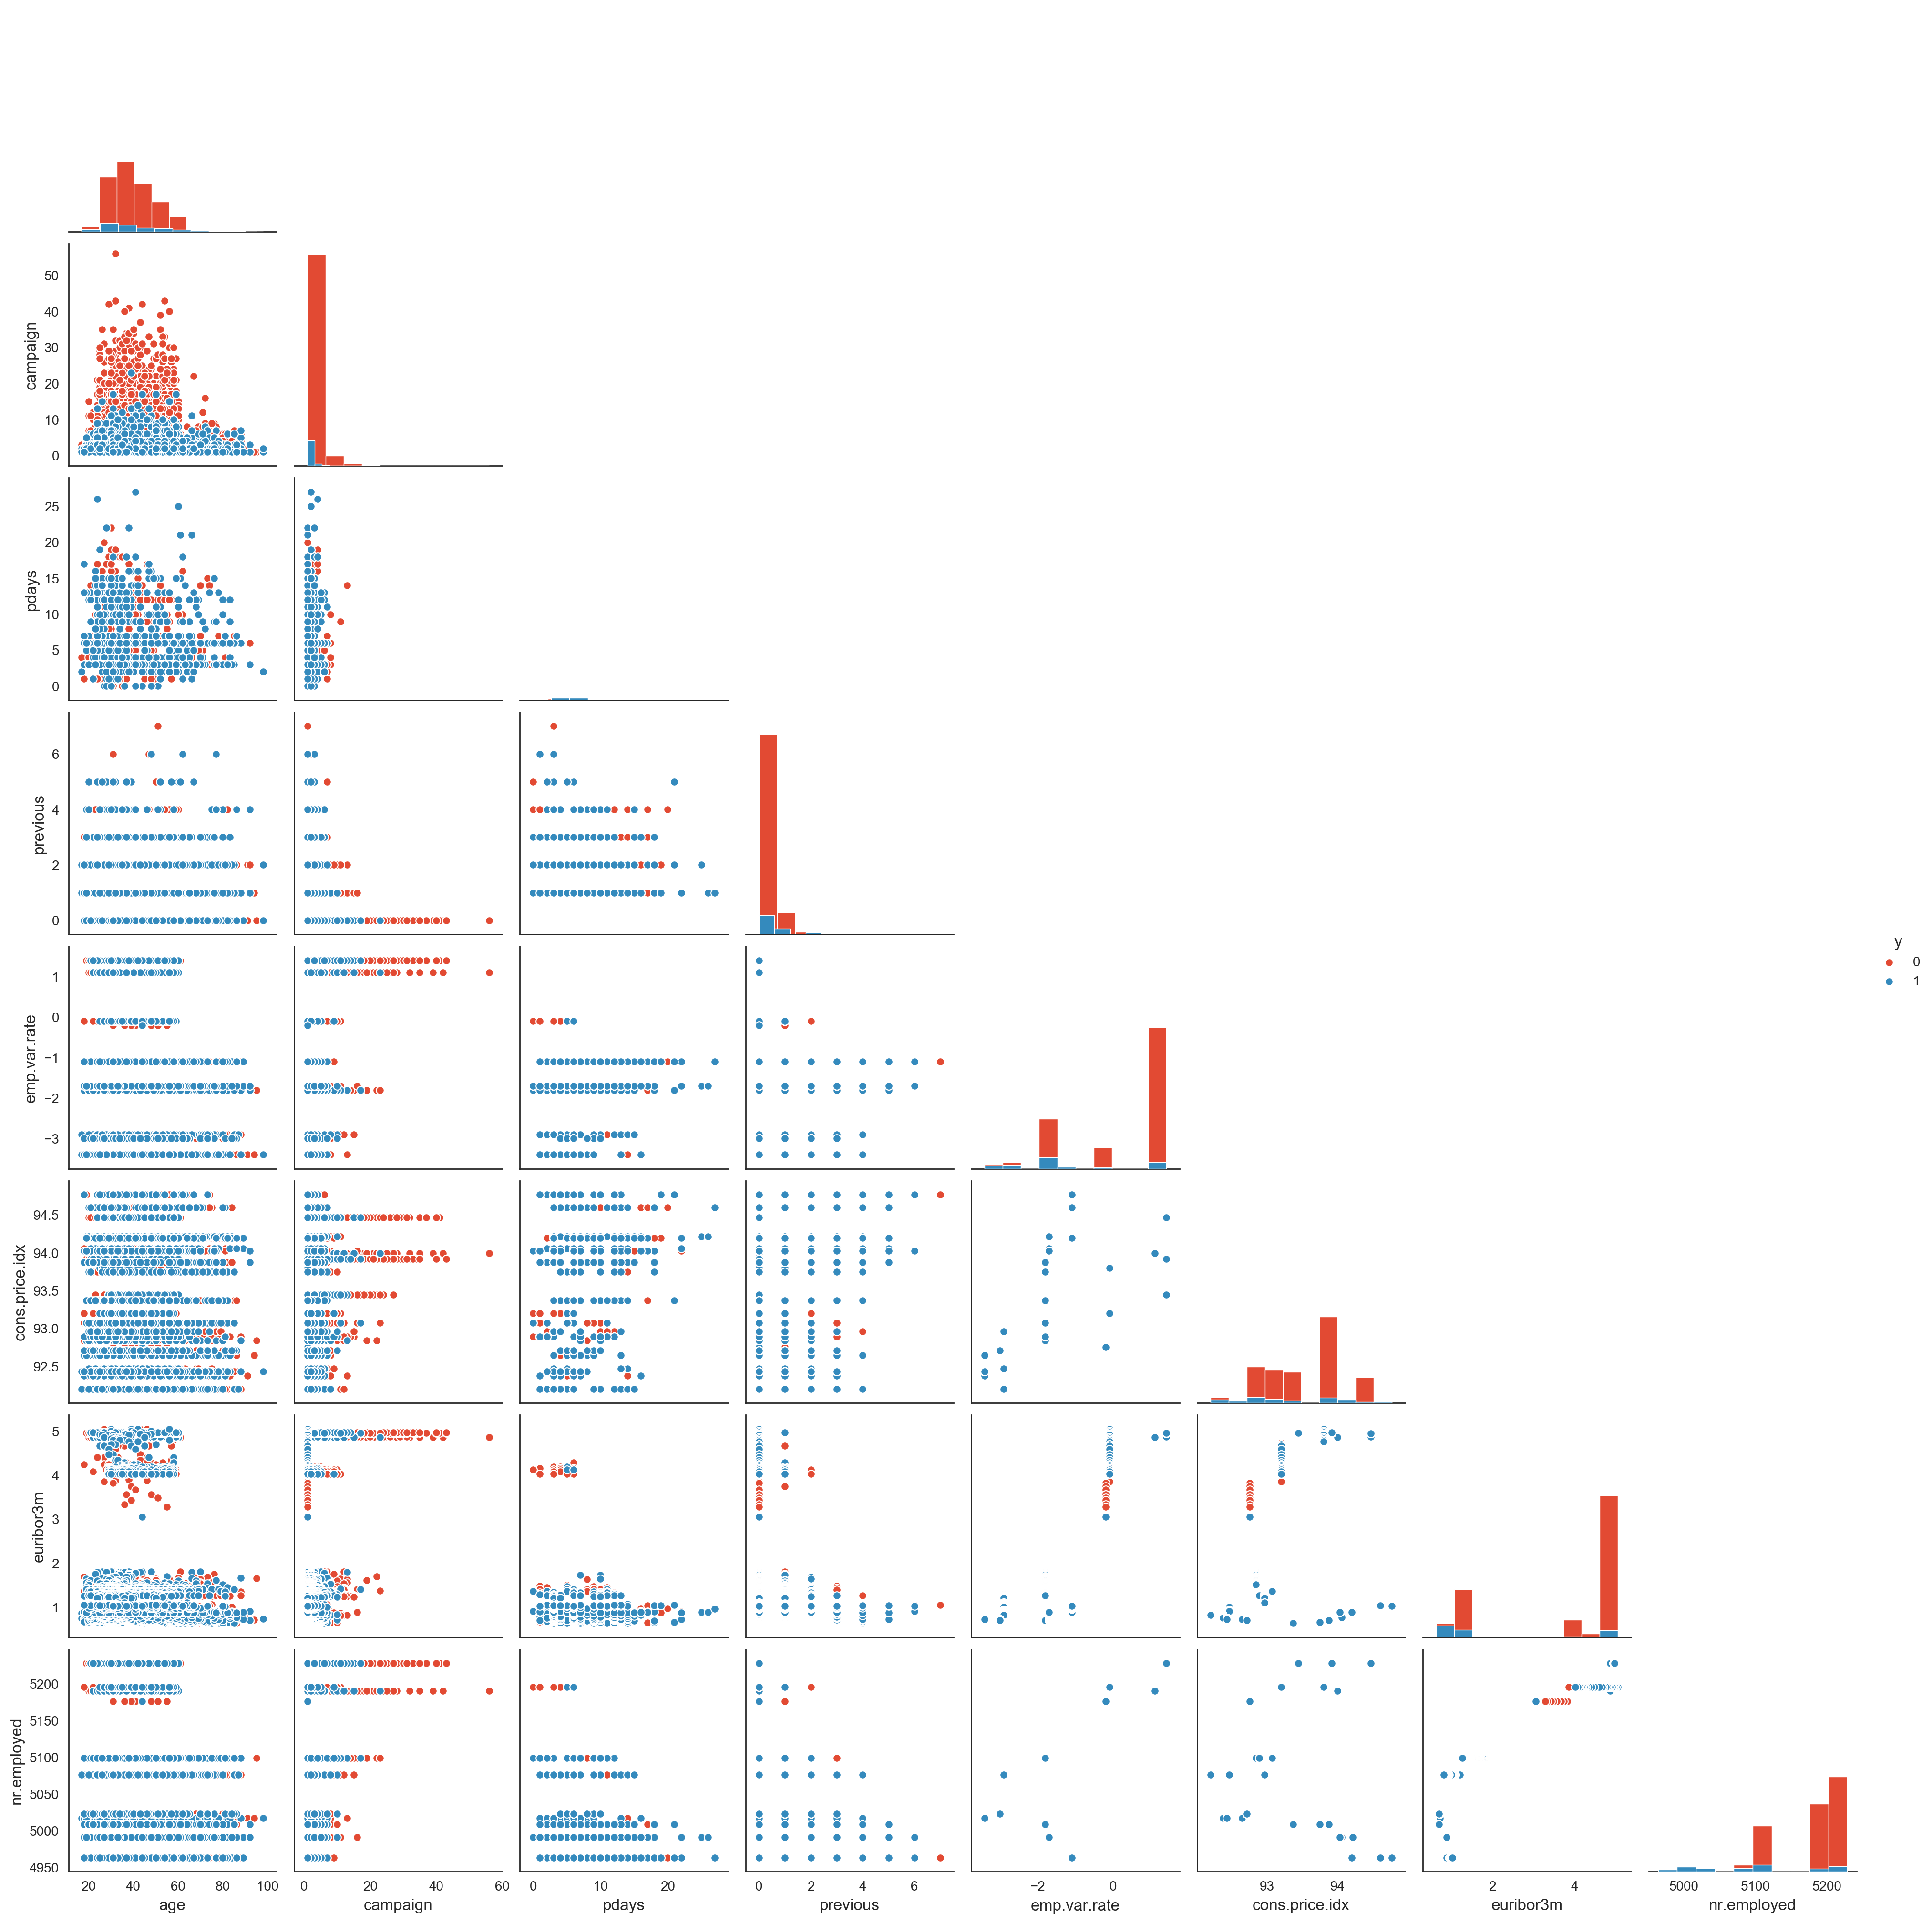

In [17]:
g = sns.pairplot(data = df_num,hue='y',corner=True,diag_kind='hist')
g.fig.set_size_inches(20,20)
g.fig.set_dpi(200)

Not much information. We can check correlation with a heatplot.


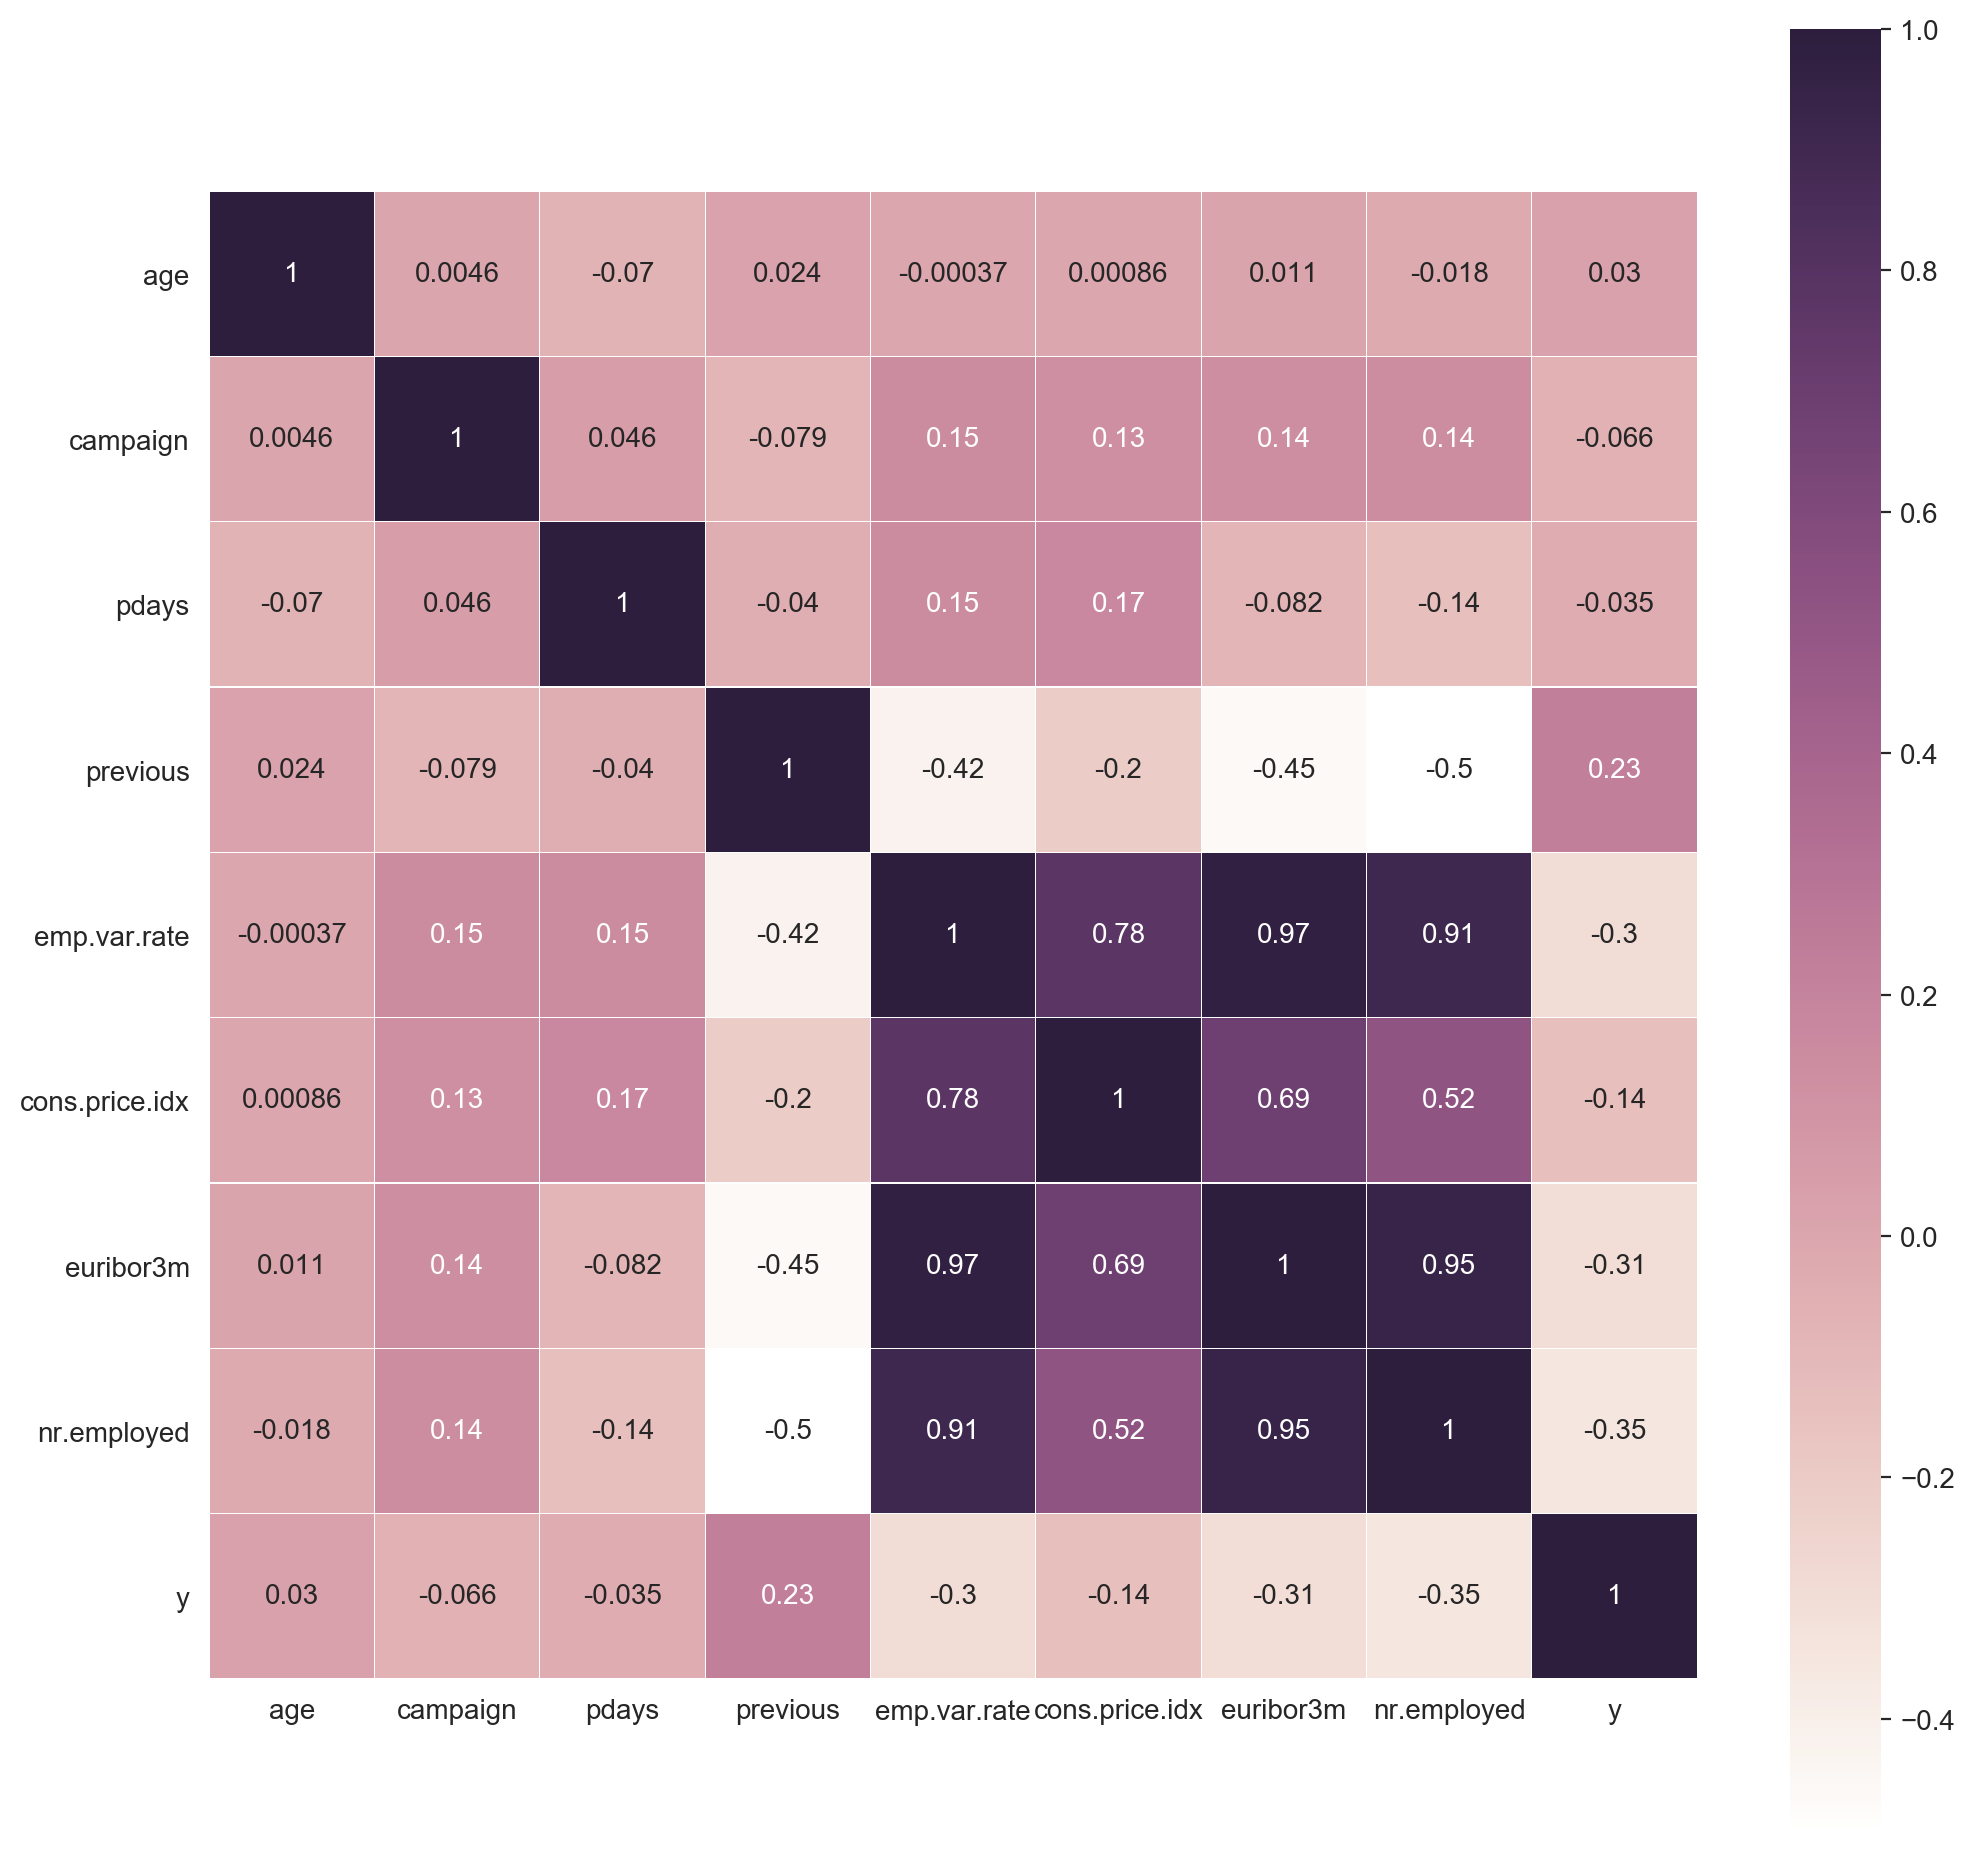

In [18]:
fig,ax = plt.subplots(figsize = (12,12),dpi = 200)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(df_num.corr(),cmap = cmap, ax=ax, annot=True, linewidth=0.1,square = True)

In [19]:
df_num['y'] = df_num['y'].replace(1,'yes').replace(0,'no')

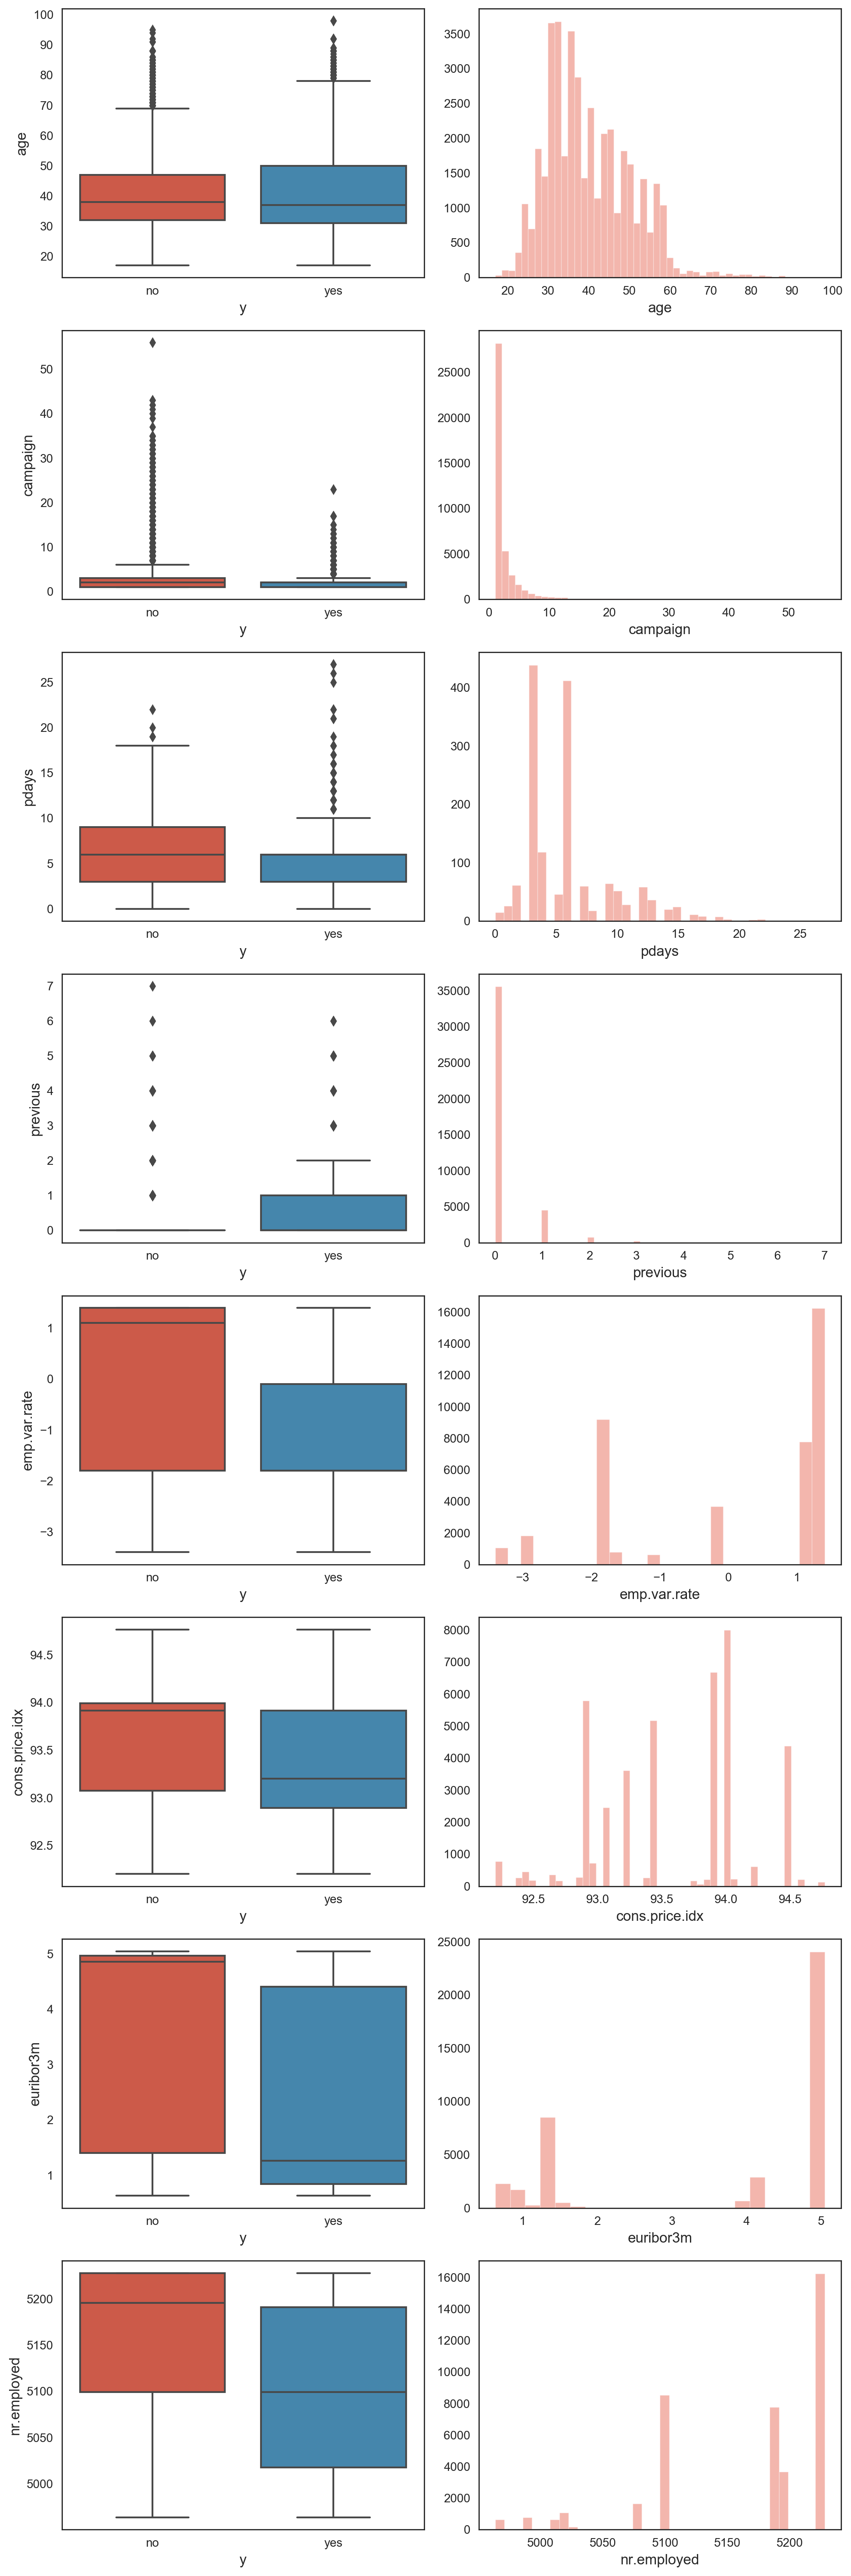

In [20]:
fig,ax = plt.subplots(8,2,figsize=(10,30),dpi=200)
for i,arg in enumerate(client_list_num + other_list_num):
    sns.boxplot(x='y',y=arg,data = df_num[['y', arg]],ax = ax[i,0])
    sns.distplot(df_num[arg],ax = ax[i,1],kde = False)
plt.tight_layout()


- Numerical Variable
    - previous is positively correlated with YES
    - Negatively correlated with economics variables: less likely to have YES when the economy is booming and/or interest rates are high
    
- These can be confirmed by the boxplots

Also, I have replaced pdays = 999 to NA. Now I will check the difference in terms of YES when pday = NA vs. not

In [21]:
df_num['pdays_valid'] = 1*df_num['pdays'].notna()

In [22]:
df_num['pdays_valid'].value_counts()

0    39673
1     1515
Name: pdays_valid, dtype: int64

In [23]:
df_num[['y','pdays_valid']].replace('yes',1).replace('no',0).groupby('pdays_valid').mean().reset_index()

pdays_valid         y
0            0  0.092582
1            1  0.638284

Distribution of Y for pdays
pdays: number of days that passed by after the client was last contacted from a previous campaign
pdays_valid = 0 means client was not previously contacted; 1 otherwise


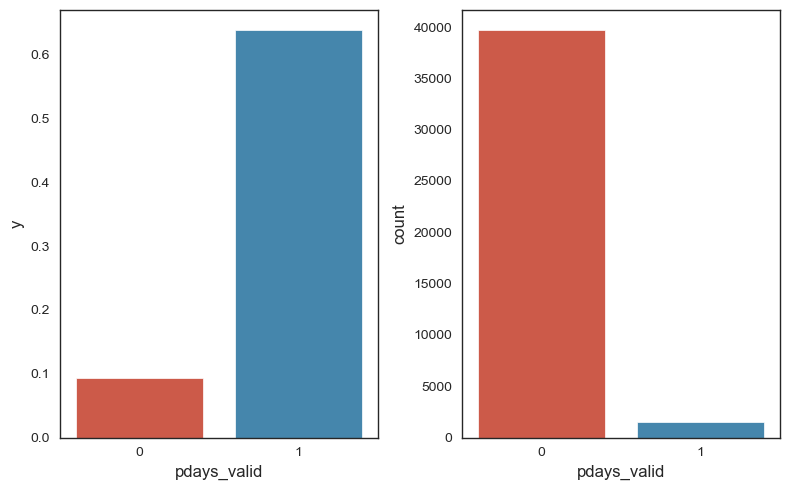

In [24]:
fig,ax = plt.subplots(1,2,figsize=(8,5),dpi=100)
sns.barplot(y='y',x = 'pdays_valid',
            data =df_num[['y','pdays_valid']].replace('yes',1).replace('no',0).groupby('pdays_valid').mean().reset_index(),
            ax = ax[0])
sns.countplot(df_num['pdays_valid'],ax = ax[1])
# fig.suptitle('Distribution of Y for pdays')
# ax[i].tick_params(axis='x', rotation=20)
# ax[i].set_ylabel('Fraction of YES')
# ax[i].set_ylim((0,df_cat.y.max()))
# ax[i].set_xlabel(arg)
plt.tight_layout()
print('''Distribution of Y for pdays
pdays: number of days that passed by after the client was last contacted from a previous campaign
pdays_valid = 0 means client was not previously contacted; 1 otherwise''')

In conclusion, pdays is weakly negatively correlated with response. However, if clients have never been contacted, is it less likely for them to say yes. For logistic regressions, a better feature will by pdays_valid.

## 2.3 Distribution of Y

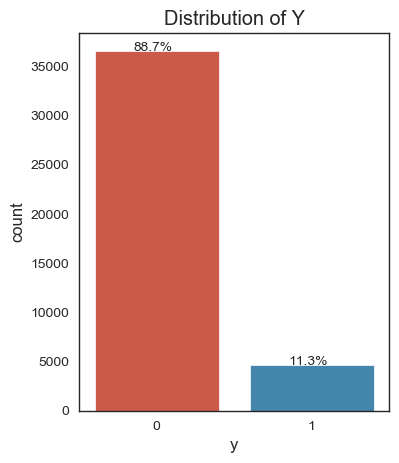

In [25]:
fig,ax = plt.subplots(figsize=(4,5),dpi=100)
sns.countplot(df['y'],ax = ax)
ax.set_title('Distribution of Y')
for p in ax.patches:
    ax.annotate(f"{100*p.get_height()/len(df['y']):.1f}%", (p.get_x()+0.25, p.get_height()+5))

# 3.Discussion of Success Criteria
In order of importance: **assuming the cost of missing out is the highest**
- Recall (True Positive Rate, Sensitivity) = True Positive/Positive
    - Probability of detection. How many relevant items are selected
    - This is very important
- Specifity = True Negative/Negative = 1 - False Positive Rate
    - how many negative selected items are truly negatuve
    - We want this number to be high as well
- Percision = True Positive/Predicted Positive: 
    - How many selected items are relevant. 
    - We want high number of this because marketing is costly, but it is less important

Two curves: Percison/Recall and ROC
- Use ROC, which plots true positive rate aginst false positive rate. We calculate area under curve AUC
- But keep in mind that the positive cases (Y=1) is only 11.3%, so even for a naive classifier that labels every item to be negative will have a high specifity: 88.7%.


In [26]:
def binary_testing(classifier_list,X,y_true,classifier_name_list = None):
    
    '''
    This function outputs the confusion matrix, classification reports, 
    Precesion-Recall Curve and ROC Curve for a list of binary classifiers.
    
    Example: binary_testing([gb_clf,clf],X,y_test,['XGBoost','RandomForrest'])
    '''
    
    if not isinstance(classifier_list,list):
        classifier_list = [classifier_list]
        
    if classifier_name_list is None:
        classifier_name_list = [x.__class__.__name__ for x in classifier_list]
    
    num_clf = len(classifier_list)
    
    fig,ax = plt.subplots(1,3,figsize = (21,6),dpi = 150)
    
    if num_clf%3 == 0:
        rows = int(num_clf/3)
    else:
        rows = int(num_clf//3 + 1)
    
    fig2,ax_cm = plt.subplots(rows,min(3,num_clf),figsize = (6*num_clf,6*rows),dpi = 150)
    
    if rows == 1:
        ax_cm = [ax_cm]
    else:
        ax_cm = ax_cm.flatten()
     
        
    for i,(classifier,name) in enumerate(zip(classifier_list,classifier_name_list)):
        
        if 'Keras' in name:
            X = X.toarray()
        elif 'Sequential' in name:
            X = X.toarray()
   
        if name != "Sequential":
            
            y_pred = classifier.predict(X)
            y_score = classifier.predict_proba(X)[:,1]
        else:
            y_pred = classifier.predict_classes(X).ravel()
            y_score = classifier.predict_proba(X).ravel()
        

        
        print(f'\n Calssification Report of {name}')
        print(classification_report(y_true, y_pred, labels = [0,1], target_names=['No','Yes']))

        if name != "Sequential":
            disp = plot_confusion_matrix(classifier,X,y_true,
                                         labels = [0,1],
                                  display_labels = ['No','Yes'],
                                  cmap=plt.cm.Blues,
                                  normalize = 'true',
                                         ax=ax_cm[i])
            disp.ax_.set_title(f'Normalized confusion matrix of {name}')
            print(f'confusion_matrix of {name}')
            print(disp.confusion_matrix)
        else:
            mat = confusion_matrix(y,y_pred)
            nmat = mat/np.repeat(np.sum(mat,axis = 1),2).reshape((2,2))
            
            sns.heatmap(nmat, annot=True,cmap=plt.cm.Blues,ax=ax_cm[i])
            ax_cm[i].set_title(f'Normalized confusion matrix of {name}')
            print(f'confusion_matrix of {name}')
            print(nmat)

        if name != "Sequential":
            disp2 = plot_precision_recall_curve(classifier, X, y_true,ax = ax[0])
            disp2.ax_.set_title('Precision-Recall curve')


        fpr, tpr, thresholds  = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        ax[1].plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:0.2f})')
        ax[1].plot([0, 1], [0, 1], 'k--')
        ax[1].set_xlim([0.0, 1.0])
        ax[1].set_ylim([0.0, 1.05])
        ax[1].set_xlabel('False Positive Rate')
        ax[1].set_ylabel('True Positive Rate (Recall)')
        ax[1].set_title('Receiver operating characteristic Curve')
        ax[1].legend(loc="lower right")

        ax[2].plot([0, 1], [0, 1], 'k--')
        ax[2].set_xlim(0, 0.5)
        ax[2].set_ylim(0.5, 1)
        ax[2].plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:0.2f})')
        ax[2].set_xlabel('False Positive Rate')
        ax[2].set_ylabel('True Positive Rate (Recall)')
        ax[2].set_title('Receiver operating characteristic Curve (zoomed in at top left)')
        ax[2].legend(loc='lower right')
        
        print('\n')

    plt.tight_layout()

# 4. Data Processing

In [27]:
df = pd.read_csv('./bank-additional/bank-additional-full.csv',sep = ';')\
        .assign(y = lambda df: 1*(df['y']=='yes')).drop('duration',axis = 1)

- Before modeling, I would like to check the relative important of different feature.
- From the correlation plot, we see that previous emp.var.rate cons.price.idx euribor3m nr.employed have high correlation with y

## 4.1 Splitting

In [28]:
# for model selection, I would use train-test split
X_train, X_test, y_train, y_test = train_test_split(df.drop('y',axis = 1), df['y'],test_size=0.1,random_state=42) 
# for algo with early stopping, I use the validation set; otherwise I will use cross validation on the training set
X_train_small, X_val, y_train_small, y_val = train_test_split(X_train,y_train,test_size=0.06, random_state=43)

# To test realistic predictive performance, I would use a expanding window time series split
tscv = TimeSeriesSplit(n_splits=5) # data is from May 2008 to November 2010, so this is akin to semi-annual window

In [29]:
for y in [y_train,y_train_small,y_val,y_test]:
    print(f"The number of observation is {len(y)}")
    print(f"The fraction of YES is {np.mean(y):.2f}\n")

The number of observation is 37069
The fraction of YES is 0.11

The number of observation is 34844
The fraction of YES is 0.11

The number of observation is 2225
The fraction of YES is 0.12

The number of observation is 4119
The fraction of YES is 0.11



## 4.2 Rebalance the Training and Validaton Data

In [30]:
def rebalance(X,y):
    
    '''
    The function balances the binary classes sample
    '''
    
    df_Xy = X.merge(pd.DataFrame(y),
                    left_index = True,right_index = True,how = 'inner',
                     suffixes = [False,False], validate = '1:1')
    
    df_0 = df_Xy[df_Xy['y']==0]
    df_1 = df_Xy[df_Xy['y']==1]
    sample_size = int(len(df_0)) - len(df_1)
    df_bal = pd.concat([df_0,df_1,df_1.sample(sample_size,replace = True)]).sample(frac=1)
    
    fig,ax = plt.subplots(figsize=(4,5),dpi=100)
    sns.countplot(df_bal['y'],ax = ax)
    ax.set_title('Distribution of Y')
    for p in ax.patches:
        ax.annotate(f"{100*p.get_height()/len(df_bal['y']):.1f}%", (p.get_x()+0.25, p.get_height()+5))
    
    print(f"The number of observation is {len(df_bal)}")
    print(f"The fraction of YES is {np.mean(df_bal['y']):.2f}\n")
        
    return df_bal.iloc[:,:-1],df_bal.iloc[:,-1]

The number of observation is 65782
The fraction of YES is 0.50

The number of observation is 61858
The fraction of YES is 0.50

The number of observation is 3924
The fraction of YES is 0.50



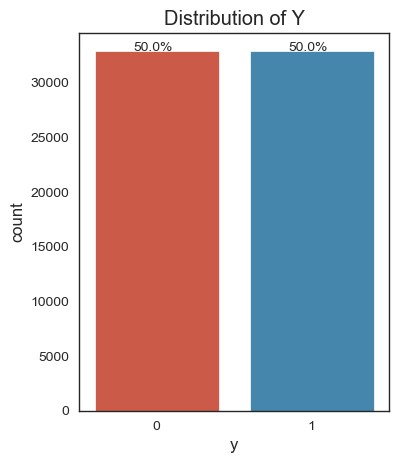

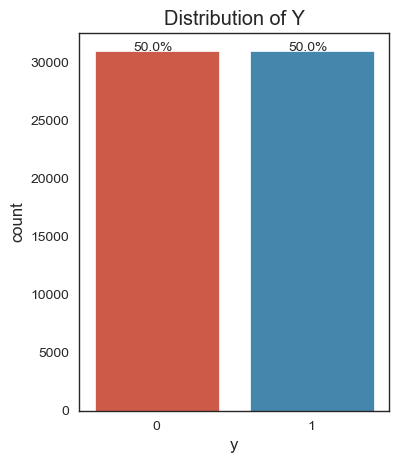

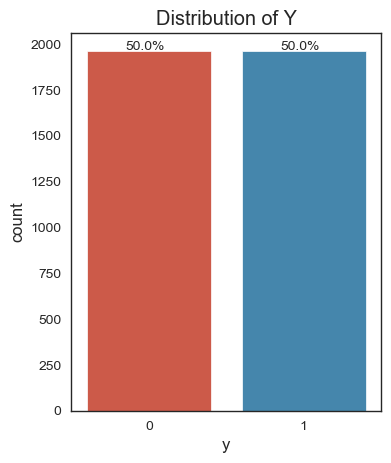

In [31]:
X_train,y_train = rebalance(X_train,y_train)
X_train_small,y_train_small = rebalance(X_train_small,y_train_small)
X_val,y_val = rebalance(X_val,y_val)

## 4.3 Transformation

In [32]:
# client_list_num = ['age']
# client_list_cat = 'job marital education default housing loan'.split()
# other_list_cat = 'contact month day_of_week poutcome'.split()
# other_list_num = 'campaign pdays previous emp.var.rate cons.price.idx euribor3m nr.employed'.split()

# def create_dummy(df,cat_list):
#     # create named dummy vairable for a dataframe
#     for cat in cat_list:
#         print(f"Now creating dummy variables (One Hot Encoder) for {cat}")
#         ec = OneHotEncoder()
#         data = ec.fit_transform(df[[cat]])
#         for i,kind in enumerate(ec.categories_[0]):
#             print(f"\t{kind}")
#             df[f"{cat}_{kind}"] = data[:,i].toarray().ravel()
            
            
full_pipeline = ColumnTransformer([
    ('number',StandardScaler(),client_list_num + other_list_num),
    ('categories',OneHotEncoder(),client_list_cat + other_list_cat)
])

X_train = full_pipeline.fit_transform(X_train)


X_train_small = full_pipeline.transform(X_train_small)
X_val = full_pipeline.transform(X_val)
X_test = full_pipeline.transform(X_test)

# 5. Model Selection
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosting
- KNN
- SVM
- Neural Network

## 5.1 Gradient Boosting

In [125]:
# # clf = xgb.XGBClassifier(n_estimators=500,random_state = 46)

# train_gb = {'X':X_train_small,'y':y_train_small,'eval_set':[(X_val,y_val)],
#             'eval_metric': 'logloss',
#             'early_stopping_rounds':5}

# space  = [Integer(2, 10, name='max_depth'),
#           Real(10**-3, 10**0, "log-uniform", name='learning_rate'),
#           Integer(1, 200, name='min_child_weight'),
# #           Real(0.2,1, name='subsample'),
# #           Real(0.2,1, name='colsample_bytree'),
#           Real(10**-4, 10**0, "log-uniform", name='reg_lambda'),
#           Real(10**-4, 10**0, "log-uniform", name='reg_alpha')]


# @use_named_args(space)
# def objective(**params):
#     print(params)
#     try:
#         clf = xgb.XGBClassifier(n_estimators=500,random_state = 46,**params)
#     #     clf.set_params(**params)
#         clf.fit(**train_gb,verbose = True)
#         obj = np.mean(log_loss(y_val,clf.predict_proba(X_val)[:,1]))
#     except:
#         obj = 1e6
        
#     return obj

# %%time
# clf_gp = gp_minimize(objective, space, n_calls=40, random_state=11)

# print(f"Best score={clf_gp.fun:.4f}" )

# gb_params = {
#               'max_depth': 4,
#               'learning_rate': 0.3,
#               'min_child_weight': 1,
#               'subsample': 0.8,
# #               'colsample_bytree': 0.8,
#               'reg_lambda': 1, # l2 norm
#               'reg_alpha': 0, # l1 norm
#               'n_estimators':100}

# for key,value in zip(gb_params.keys(),clf_gp_x):
#     print(f"{key} is {value} \n")
#     gb_params[key] = value

In [126]:
clf = xgb.XGBClassifier()

param_dist = {
        'max_depth': randint(2,15),
        'learning_rate':  loguniform(10**-2, 10**0),
        'subsample': uniform(0,1),
        'colsample_bytree': uniform(0,1),
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0,100.0,500.0],
#         'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': loguniform(10**-2, 10**2),
        'n_estimators': [500],
        'random_state':[46]}

fit_params = {'X':X_train_small,
              'y':y_train_small,
              'eval_set':[(X_val,y_val)],
            'eval_metric': 'logloss',
            'early_stopping_rounds':5,
             'verbose':True}

rs_clf = RandomizedSearchCV(clf, param_dist, n_iter=60,
                            n_jobs=-1, verbose=2, cv=3,
                            scoring='neg_log_loss', refit=False, random_state=11)

print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(**fit_params)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.0min


Randomized search time: 202.9740800857544
Best score: -0.42310034982053885
Best params: 
colsample_bytree: 0.41400581666026137
learning_rate: 0.21576912890916142
max_depth: 14
min_child_weight: 1.0
n_estimators: 500
random_state: 46
reg_lambda: 1.9384586263531924
subsample: 0.7923606519581956


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.4min finished


In [127]:
# Now fit the best model
paras_gb = best_params
xgb_clf = xgb.XGBClassifier(**paras_gb)
xgb_clf.fit(**fit_params)

[0]	validation_0-logloss:0.63675
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.602442
[2]	validation_0-logloss:0.575108
[3]	validation_0-logloss:0.552744
[4]	validation_0-logloss:0.540823
[5]	validation_0-logloss:0.529136
[6]	validation_0-logloss:0.526101
[7]	validation_0-logloss:0.524027
[8]	validation_0-logloss:0.519706
[9]	validation_0-logloss:0.517657
[10]	validation_0-logloss:0.515461
[11]	validation_0-logloss:0.514939
[12]	validation_0-logloss:0.516461
[13]	validation_0-logloss:0.517124
[14]	validation_0-logloss:0.518595
[15]	validation_0-logloss:0.52097
[16]	validation_0-logloss:0.522277
Stopping. Best iteration:
[11]	validation_0-logloss:0.514939



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.41400581666026137, gamma=0,
              learning_rate=0.21576912890916142, max_delta_step=0, max_depth=14,
              min_child_weight=1.0, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=46,
              reg_alpha=0, reg_lambda=1.9384586263531924, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7923606519581956,
              verbosity=1)

In [128]:
print(f'best_ntree_limit {xgb_clf.best_ntree_limit}')

best_ntree_limit 12



 Calssification Report of XGBClassifier
              precision    recall  f1-score   support

          No       0.94      0.89      0.91      3657
         Yes       0.39      0.58      0.47       462

    accuracy                           0.85      4119
   macro avg       0.67      0.73      0.69      4119
weighted avg       0.88      0.85      0.86      4119

confusion_matrix of XGBClassifier
[[0.88569866 0.11430134]
 [0.41774892 0.58225108]]




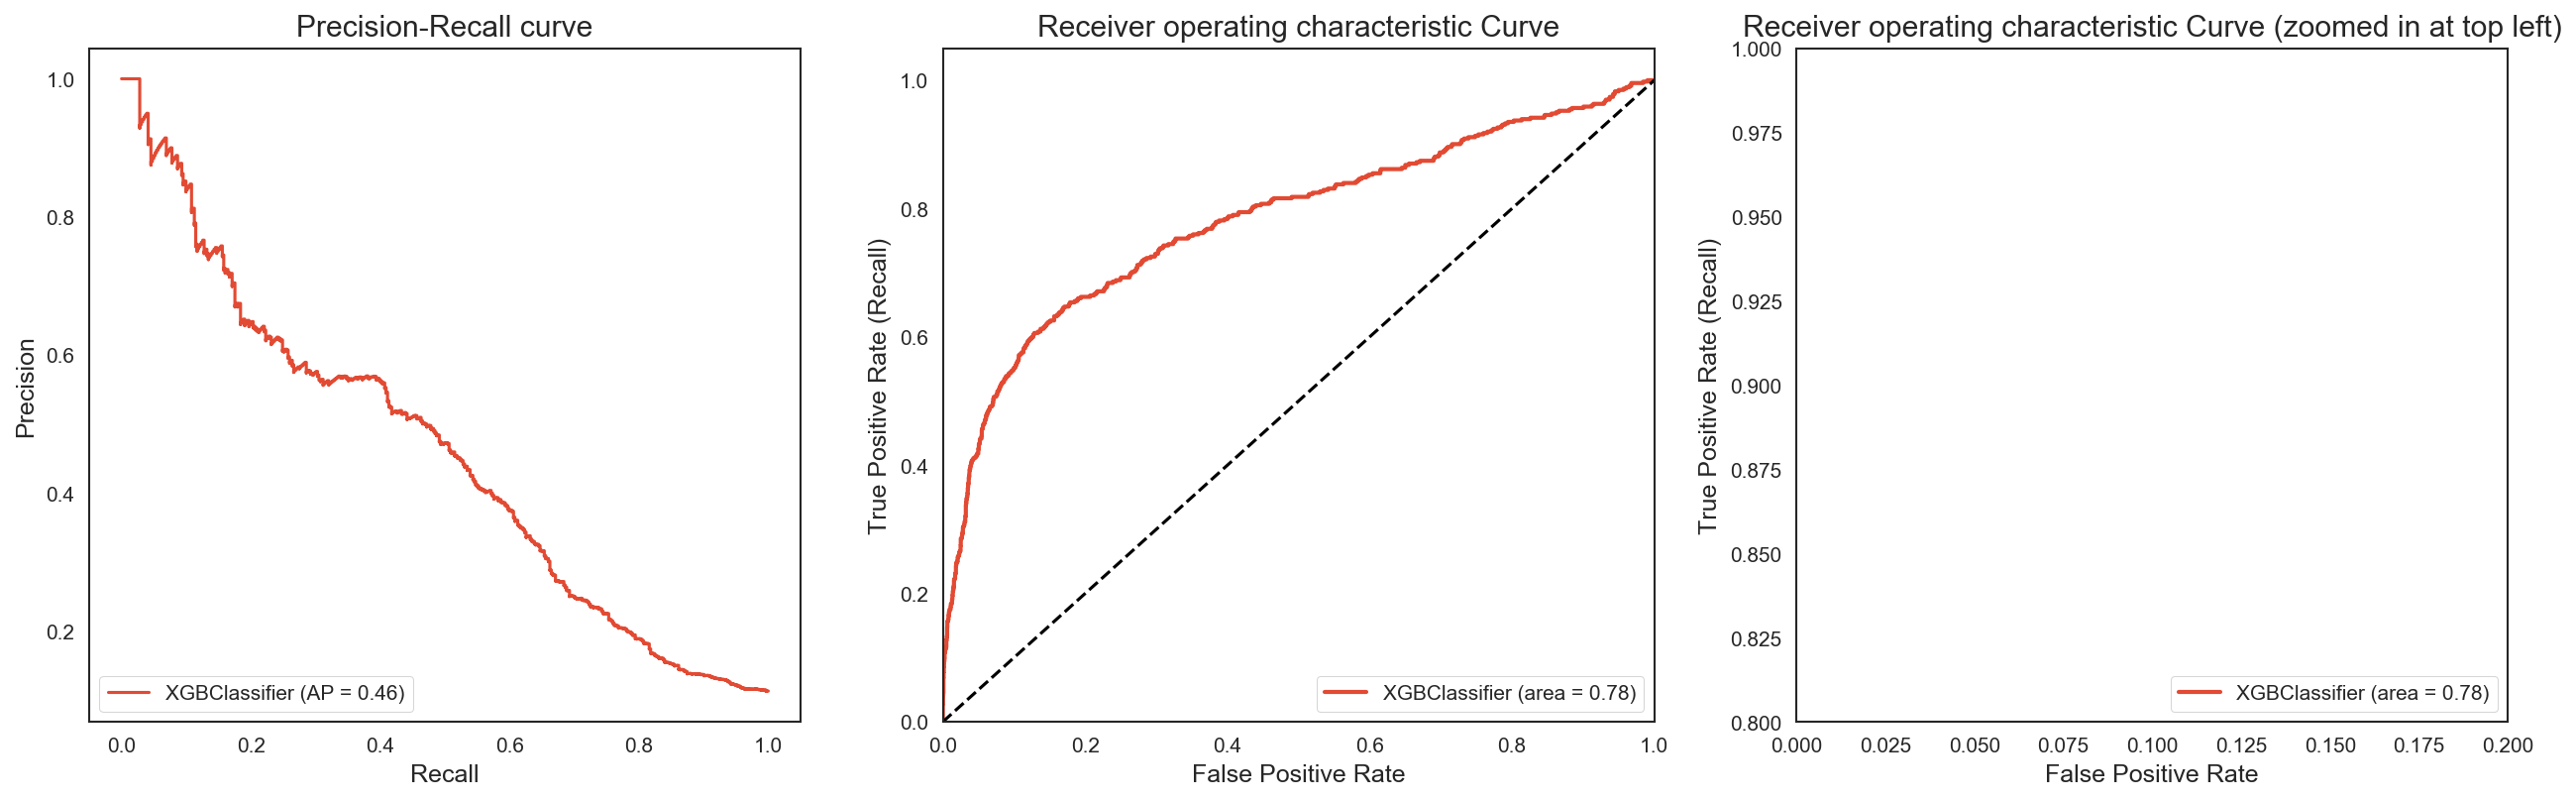

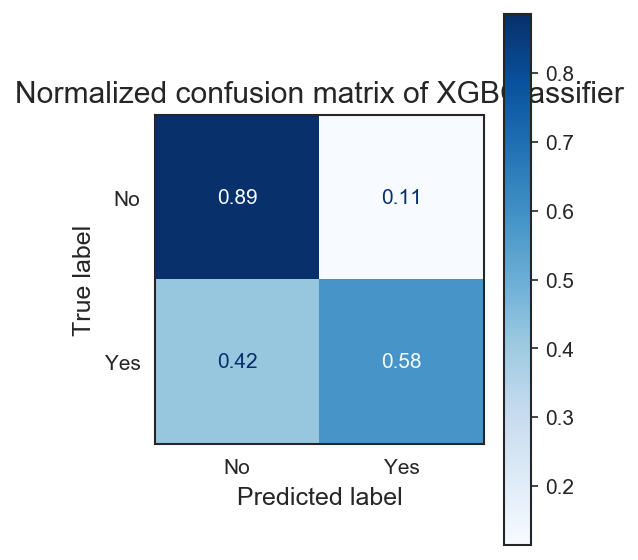

In [129]:
binary_testing(xgb_clf,X_test,y_test)

In [130]:
xgb_clf.save_model('xgb_clf.h5')

In [300]:
dump(xgb_clf, 'xgb_clf.joblib') 

['xgb_clf.joblib']

In [33]:
xgb_clf = load('xgb_clf.joblib')

## 5.2 Random Forrest

In [133]:
clf = RandomForestClassifier()

param_dist = {
        'n_estimators': [100,200,300,400,500,1000,2000],
        'max_depth': [10,20,40,80,120,None],
        'min_samples_split':  [2, 5, 10],
        'min_samples_leaf': randint(1,100),
        'max_leaf_nodes': [10,100,None],
         'random_state':[46],
        'n_jobs':[-1],
            'verbose':[True]}

fit_params = {'X':X_train,
              'y':y_train}

rs_clf = RandomizedSearchCV(clf, param_dist, n_iter=60,
                            n_jobs=-1, verbose=2, cv=3,
                            scoring='neg_log_loss', refit=False, random_state=42)

print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(**fit_params)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 29.6min


Randomized search time: 1978.010022163391
Best score: -0.17901247960912312
Best params: 
max_depth: None
max_leaf_nodes: None
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 200
n_jobs: -1
random_state: 46
verbose: True


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 33.0min finished


In [134]:
# Now fit the best model
paras_rf = best_params
rf_clf = RandomForestClassifier(**paras_rf)
rf_clf.fit(**fit_params)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   32.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=46,
                       verbose=True, warm_start=False)

In [135]:
dump(rf_clf, 'rf_clf.joblib') 

['rf_clf.joblib']


 Calssification Report of XGBClassifier
              precision    recall  f1-score   support

          No       0.94      0.89      0.91      3657
         Yes       0.39      0.58      0.47       462

    accuracy                           0.85      4119
   macro avg       0.67      0.73      0.69      4119
weighted avg       0.88      0.85      0.86      4119

confusion_matrix of XGBClassifier
[[0.88569866 0.11430134]
 [0.41774892 0.58225108]]




[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s



 Calssification Report of RandomForestClassifier
              precision    recall  f1-score   support

          No       0.93      0.94      0.93      3657
         Yes       0.44      0.40      0.42       462

    accuracy                           0.88      4119
   macro avg       0.68      0.67      0.68      4119
weighted avg       0.87      0.88      0.87      4119

confusion_matrix of RandomForestClassifier
[[0.93601313 0.06398687]
 [0.5995671  0.4004329 ]]


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished


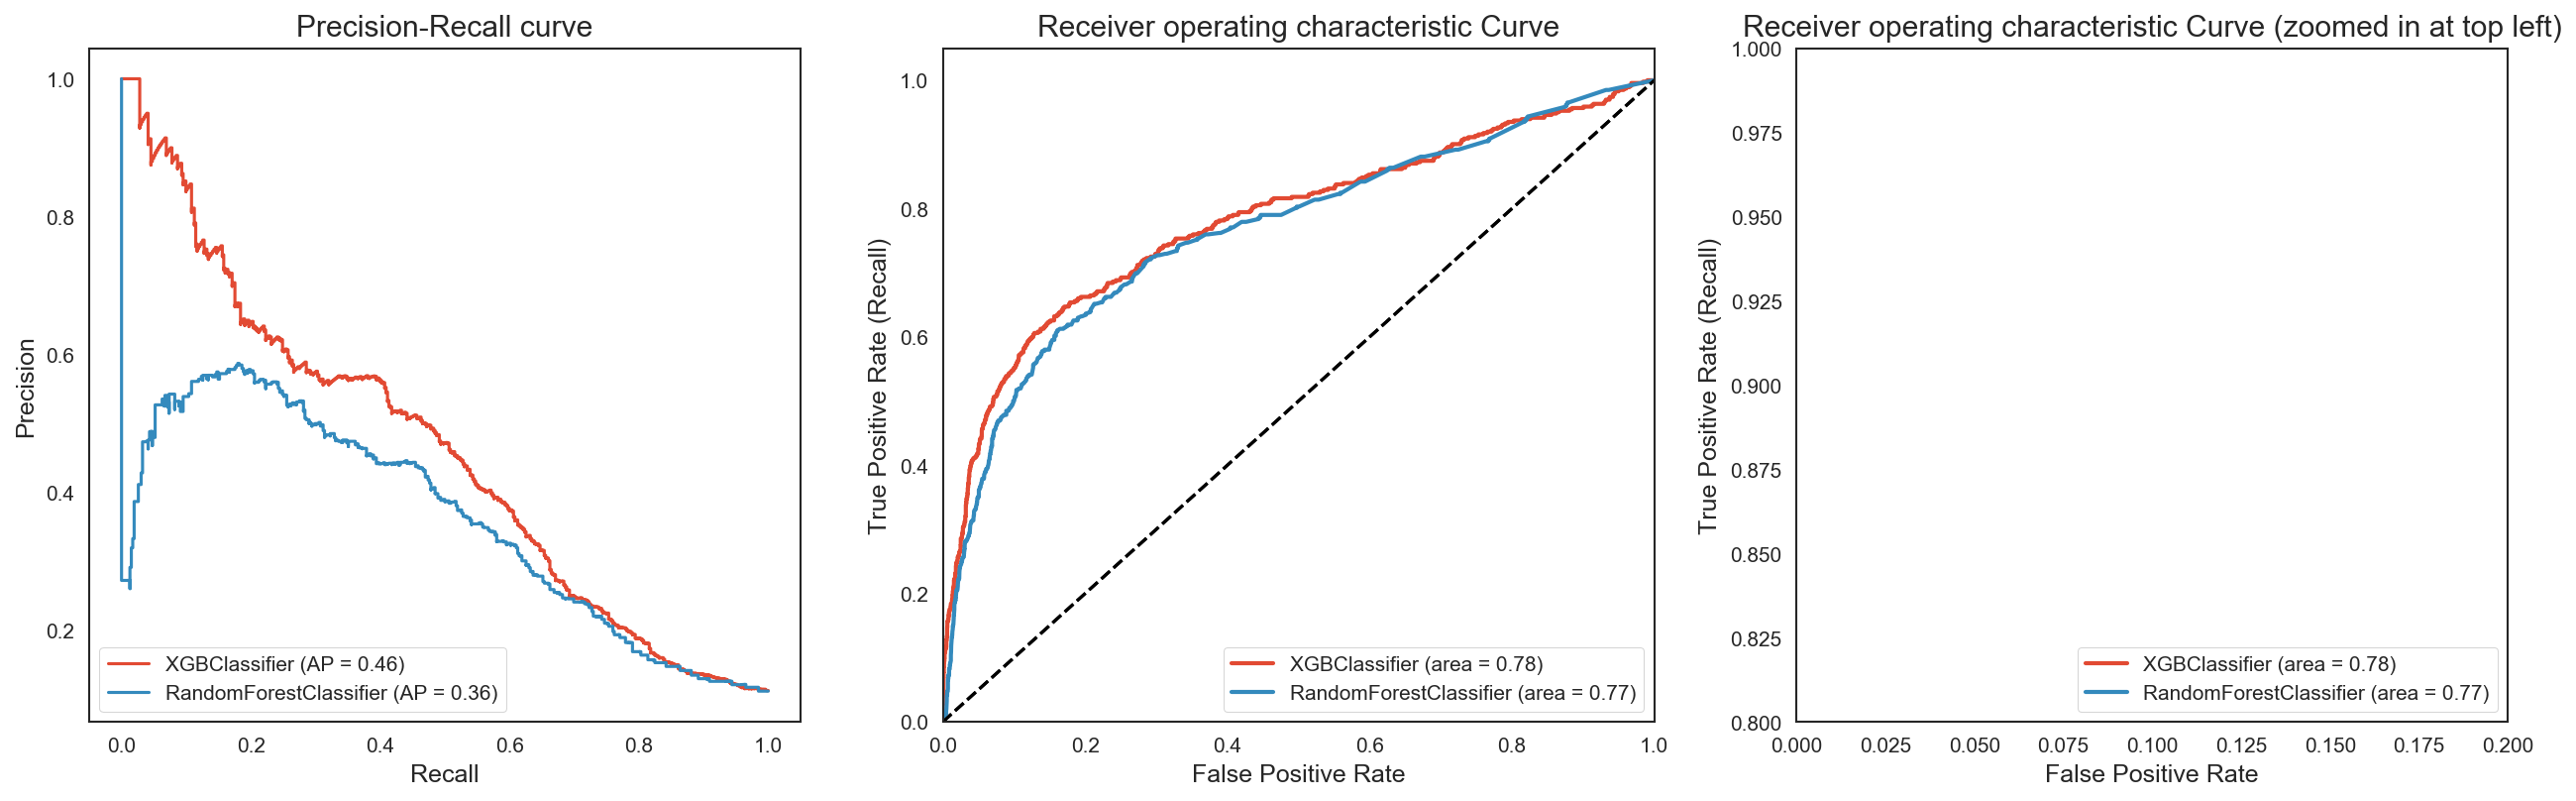

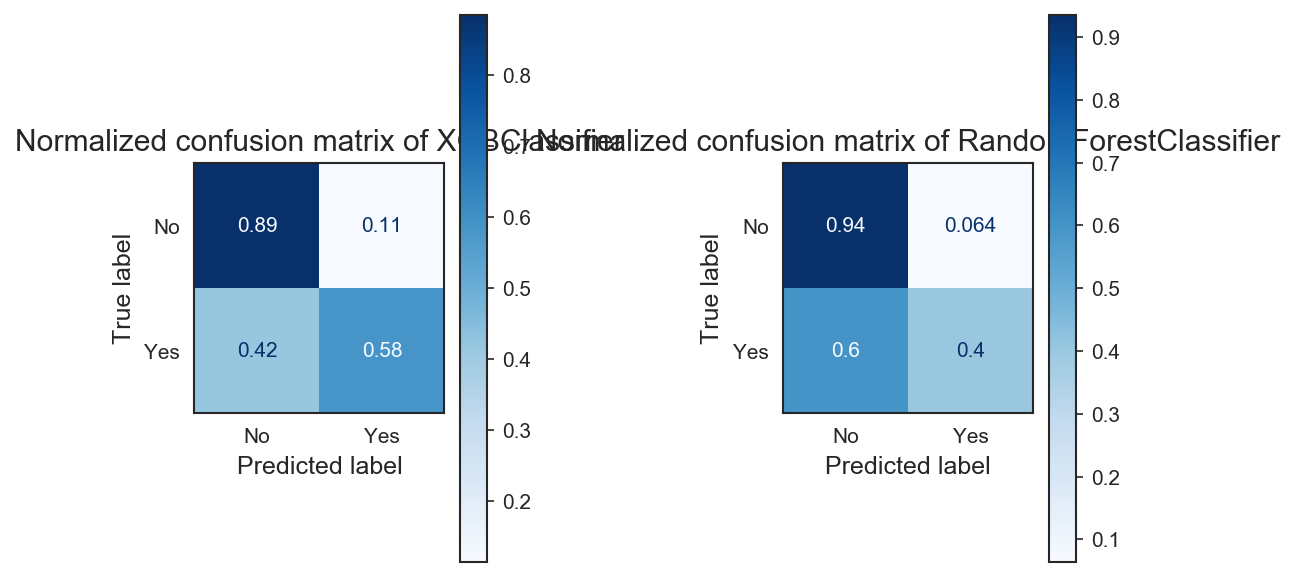

In [136]:
binary_testing([xgb_clf,rf_clf],X_test,y_test)

In [34]:
rf_clf = load('rf_clf.joblib')

# 5.3 Logistic Regression

In [148]:
clf = LogisticRegression()

param_dist = {
        'penalty': ['l1','l2'],
        'C': np.logspace(-5, 5, 60),
#         'l1_ratio':  [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1],
        'random_state':[46],
        'n_jobs':[-1],
        'verbose':[1]}

fit_params = {'X':X_train,
              'y':y_train}

rs_clf = GridSearchCV(clf, param_dist, # n_iter=60,
                            n_jobs=-1, verbose=2, cv=3,
                            scoring='neg_log_loss', refit=False)

print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(**fit_params)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:    9.2s


Randomized search time: 18.411709785461426
Best score: -0.5341826444600228
Best params: 
C: 3.919406774847213
n_jobs: -1
penalty: 'l2'
random_state: 46
verbose: 1


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   18.4s finished


In [149]:
# Now fit the best model
paras_log = best_params
log_clf = LogisticRegression(**paras_log)
log_clf.fit(**fit_params)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


LogisticRegression(C=3.919406774847213, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=46, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [150]:
dump(log_clf, 'log_clf.joblib') 

['log_clf.joblib']

In [35]:
log_clf = load('log_clf.joblib')


 Calssification Report of XGBClassifier
              precision    recall  f1-score   support

          No       0.94      0.89      0.91      3657
         Yes       0.39      0.58      0.47       462

    accuracy                           0.85      4119
   macro avg       0.67      0.73      0.69      4119
weighted avg       0.88      0.85      0.86      4119

confusion_matrix of XGBClassifier
[[0.88569866 0.11430134]
 [0.41774892 0.58225108]]




[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished



 Calssification Report of RandomForestClassifier
              precision    recall  f1-score   support

          No       0.93      0.94      0.93      3657
         Yes       0.44      0.40      0.42       462

    accuracy                           0.88      4119
   macro avg       0.68      0.67      0.68      4119
weighted avg       0.87      0.88      0.87      4119

confusion_matrix of RandomForestClassifier
[[0.93601313 0.06398687]
 [0.5995671  0.4004329 ]]


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished





 Calssification Report of LogisticRegression
              precision    recall  f1-score   support

          No       0.95      0.86      0.90      3657
         Yes       0.36      0.62      0.46       462

    accuracy                           0.83      4119
   macro avg       0.65      0.74      0.68      4119
weighted avg       0.88      0.83      0.85      4119

confusion_matrix of LogisticRegression
[[0.86054143 0.13945857]
 [0.37878788 0.62121212]]




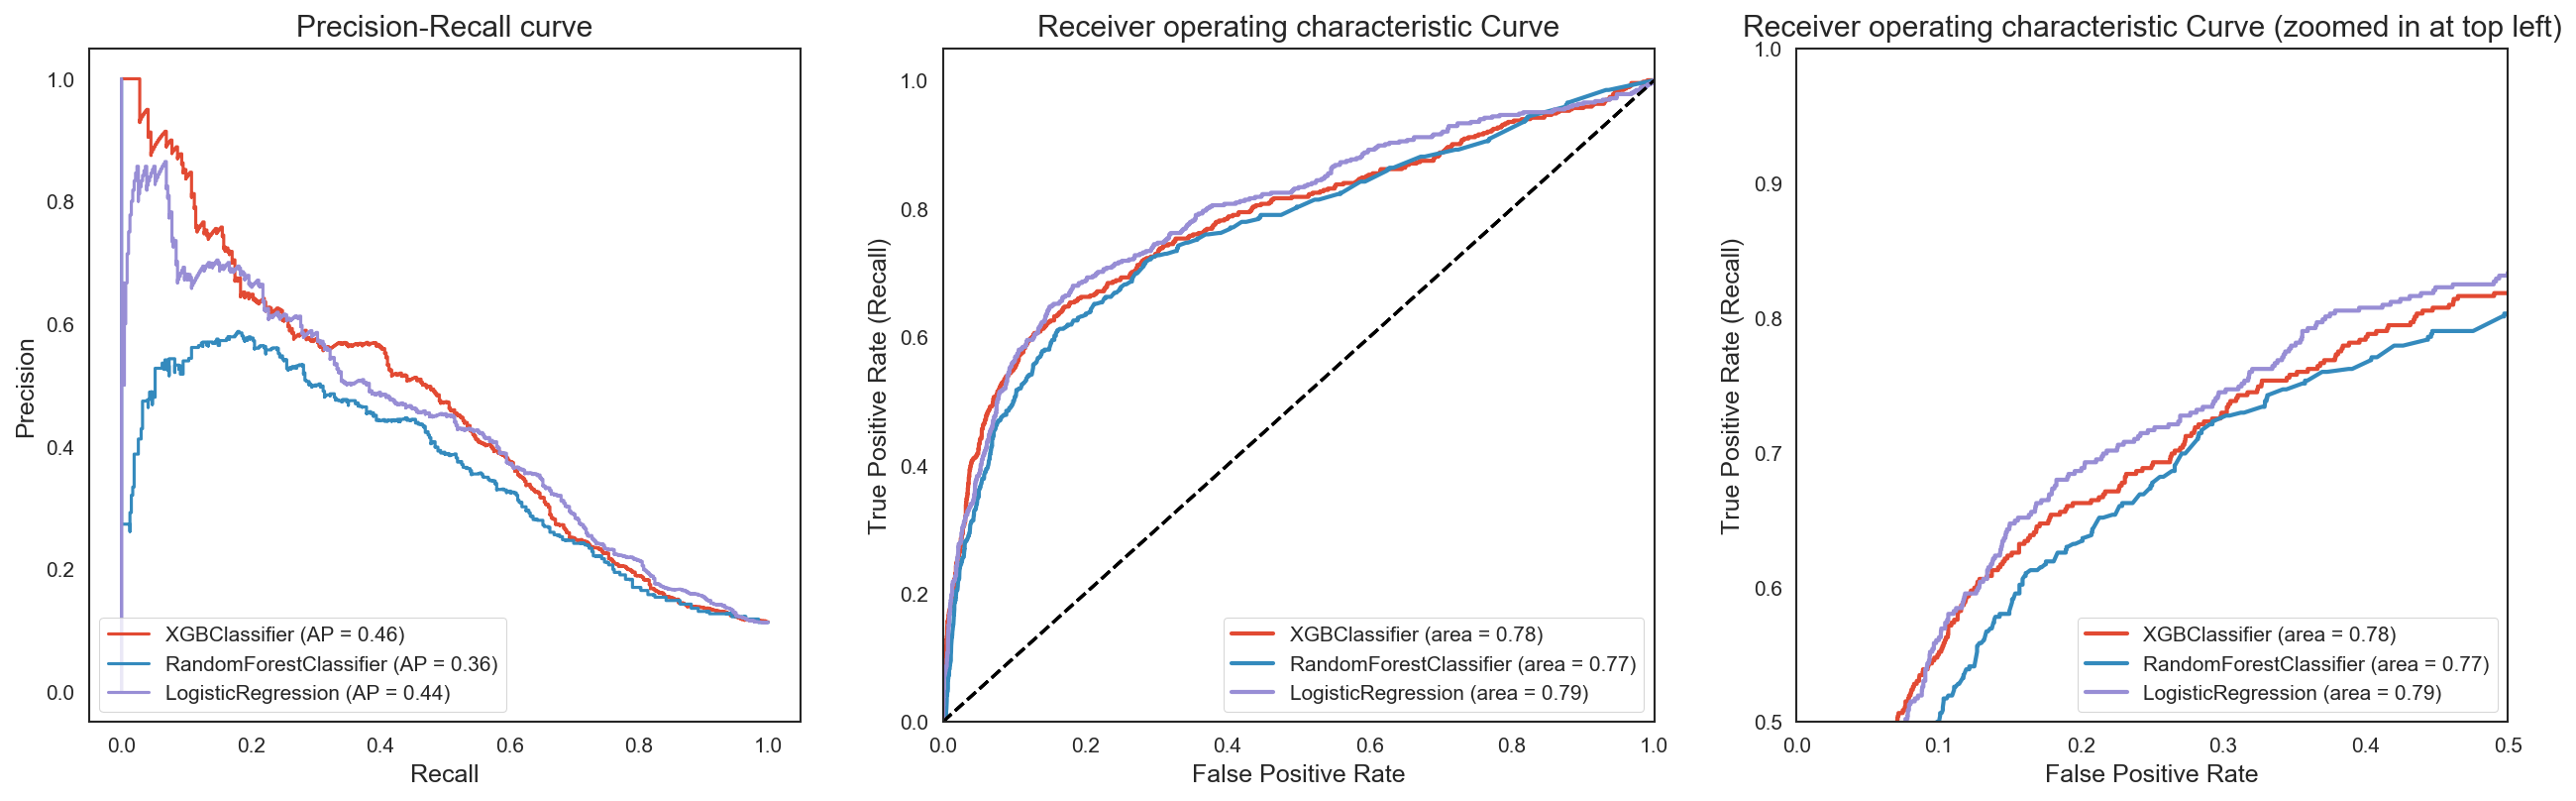

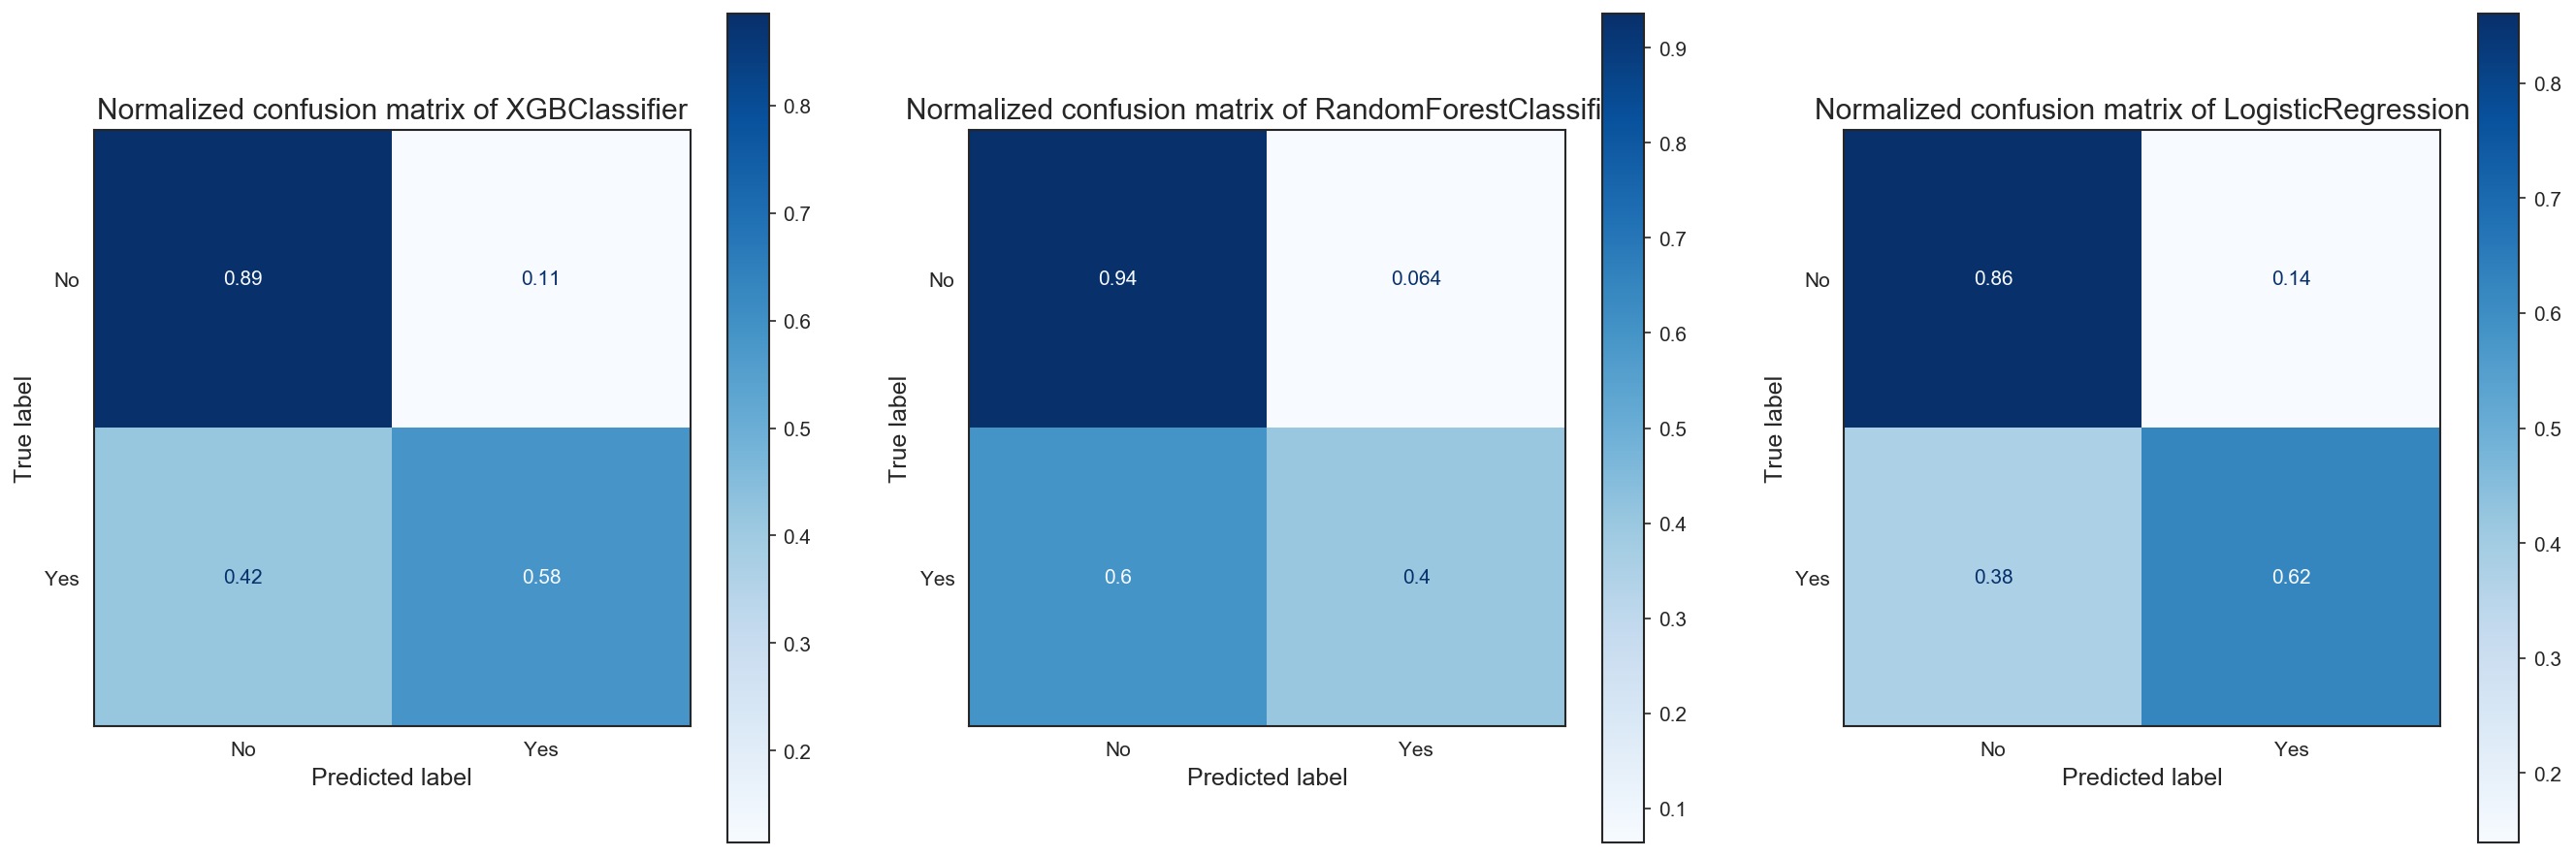

In [164]:
binary_testing([xgb_clf,rf_clf,log_clf],X_test,y_test)

# 5.4 SDG Huber
- linear regression + hinge loss see page 355 of ISL

In [197]:
clf = SGDClassifier()

param_dist = {
        'loss':['modified_huber'],
        'penalty': ['l1','l2'],
        'alpha': np.logspace(-4, 4, 40),
        'random_state':[46],
        'verbose':[1],
        'n_jobs':[-1]}

fit_params = {'X':X_train,
              'y':y_train}

rs_clf = GridSearchCV(clf, param_dist, # n_iter=60,
                            n_jobs=-1, verbose=2, cv=3,
                            scoring='neg_log_loss', refit=False)

print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(**fit_params)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    9.1s


Randomized search time: 11.682685852050781
Best score: -0.5500137688746353
Best params: 
alpha: 0.49238826317067363
loss: 'modified_huber'
n_jobs: -1
penalty: 'l2'
random_state: 46
verbose: 1


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   11.7s finished


In [198]:
# Now fit the best model
paras_sdg = best_params
sdg_clf = SGDClassifier(**paras_sdg)
sdg_clf.fit(**fit_params)

-- Epoch 1
Norm: 0.32, NNZs: 61, Bias: 0.033967, T: 65782, Avg. loss: 0.746242
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 0.32, NNZs: 61, Bias: 0.033875, T: 131564, Avg. loss: 0.740882
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 0.32, NNZs: 61, Bias: 0.033795, T: 197346, Avg. loss: 0.740791
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 0.32, NNZs: 61, Bias: 0.033742, T: 263128, Avg. loss: 0.740789
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 0.32, NNZs: 61, Bias: 0.033713, T: 328910, Avg. loss: 0.740659
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 0.32, NNZs: 61, Bias: 0.033670, T: 394692, Avg. loss: 0.740579
Total training time: 0.07 seconds.
-- Epoch 7
Norm: 0.32, NNZs: 61, Bias: 0.033659, T: 460474, Avg. loss: 0.740494
Total training time: 0.09 seconds.
Convergence after 7 epochs took 0.09 seconds


SGDClassifier(alpha=0.49238826317067363, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=46, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=1, warm_start=False)

In [199]:
dump(sdg_clf, 'sdg_clf.joblib') 

['sdg_clf.joblib']

In [36]:
sdg_clf = load('sdg_clf.joblib')


 Calssification Report of XGBClassifier
              precision    recall  f1-score   support

          No       0.94      0.89      0.91      3657
         Yes       0.39      0.58      0.47       462

    accuracy                           0.85      4119
   macro avg       0.67      0.73      0.69      4119
weighted avg       0.88      0.85      0.86      4119

confusion_matrix of XGBClassifier
[[0.88569866 0.11430134]
 [0.41774892 0.58225108]]




[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished



 Calssification Report of RandomForestClassifier
              precision    recall  f1-score   support

          No       0.93      0.94      0.93      3657
         Yes       0.44      0.40      0.42       462

    accuracy                           0.88      4119
   macro avg       0.68      0.67      0.68      4119
weighted avg       0.87      0.88      0.87      4119

confusion_matrix of RandomForestClassifier
[[0.93601313 0.06398687]
 [0.5995671  0.4004329 ]]


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished





 Calssification Report of LogisticRegression
              precision    recall  f1-score   support

          No       0.95      0.86      0.90      3657
         Yes       0.36      0.62      0.46       462

    accuracy                           0.83      4119
   macro avg       0.65      0.74      0.68      4119
weighted avg       0.88      0.83      0.85      4119

confusion_matrix of LogisticRegression
[[0.86054143 0.13945857]
 [0.37878788 0.62121212]]



 Calssification Report of SGDClassifier
              precision    recall  f1-score   support

          No       0.95      0.75      0.84      3657
         Yes       0.26      0.72      0.39       462

    accuracy                           0.74      4119
   macro avg       0.61      0.73      0.61      4119
weighted avg       0.88      0.74      0.79      4119

confusion_matrix of SGDClassifier
[[0.74678698 0.25321302]
 [0.28354978 0.71645022]]




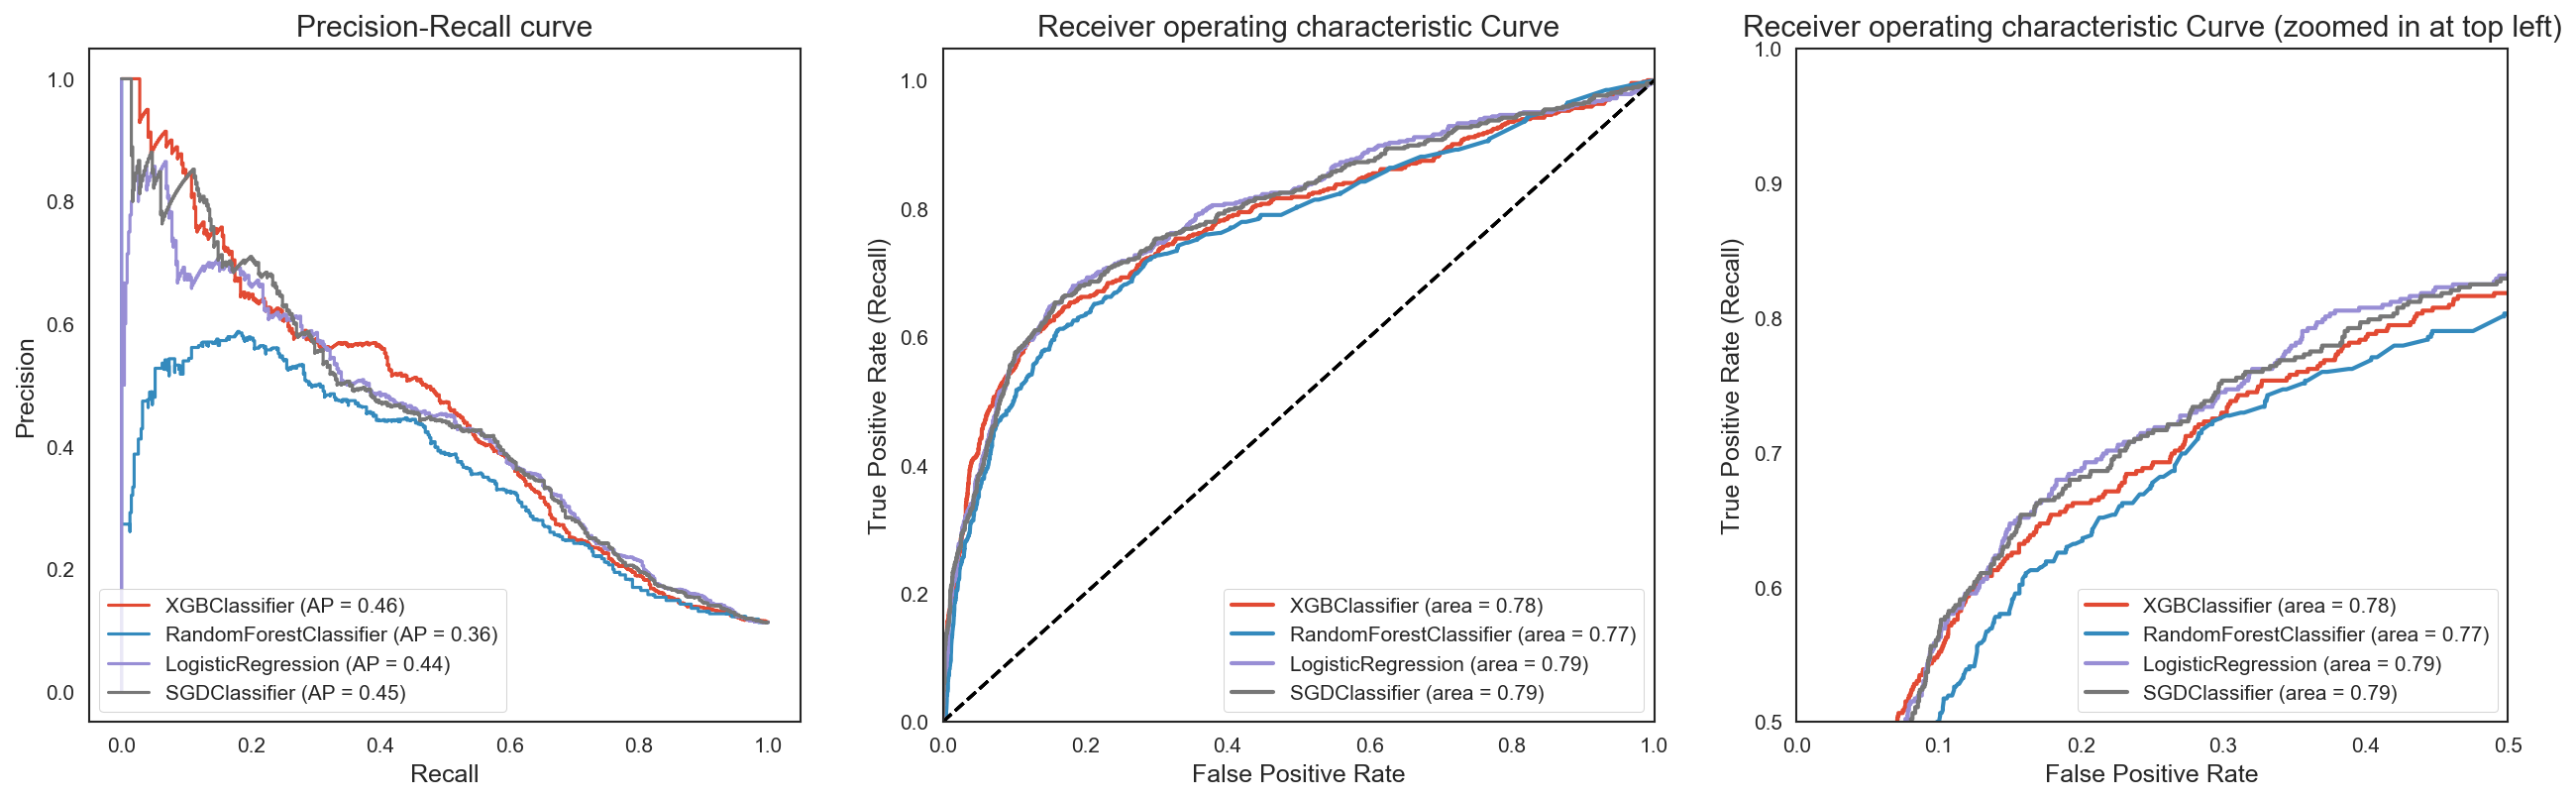

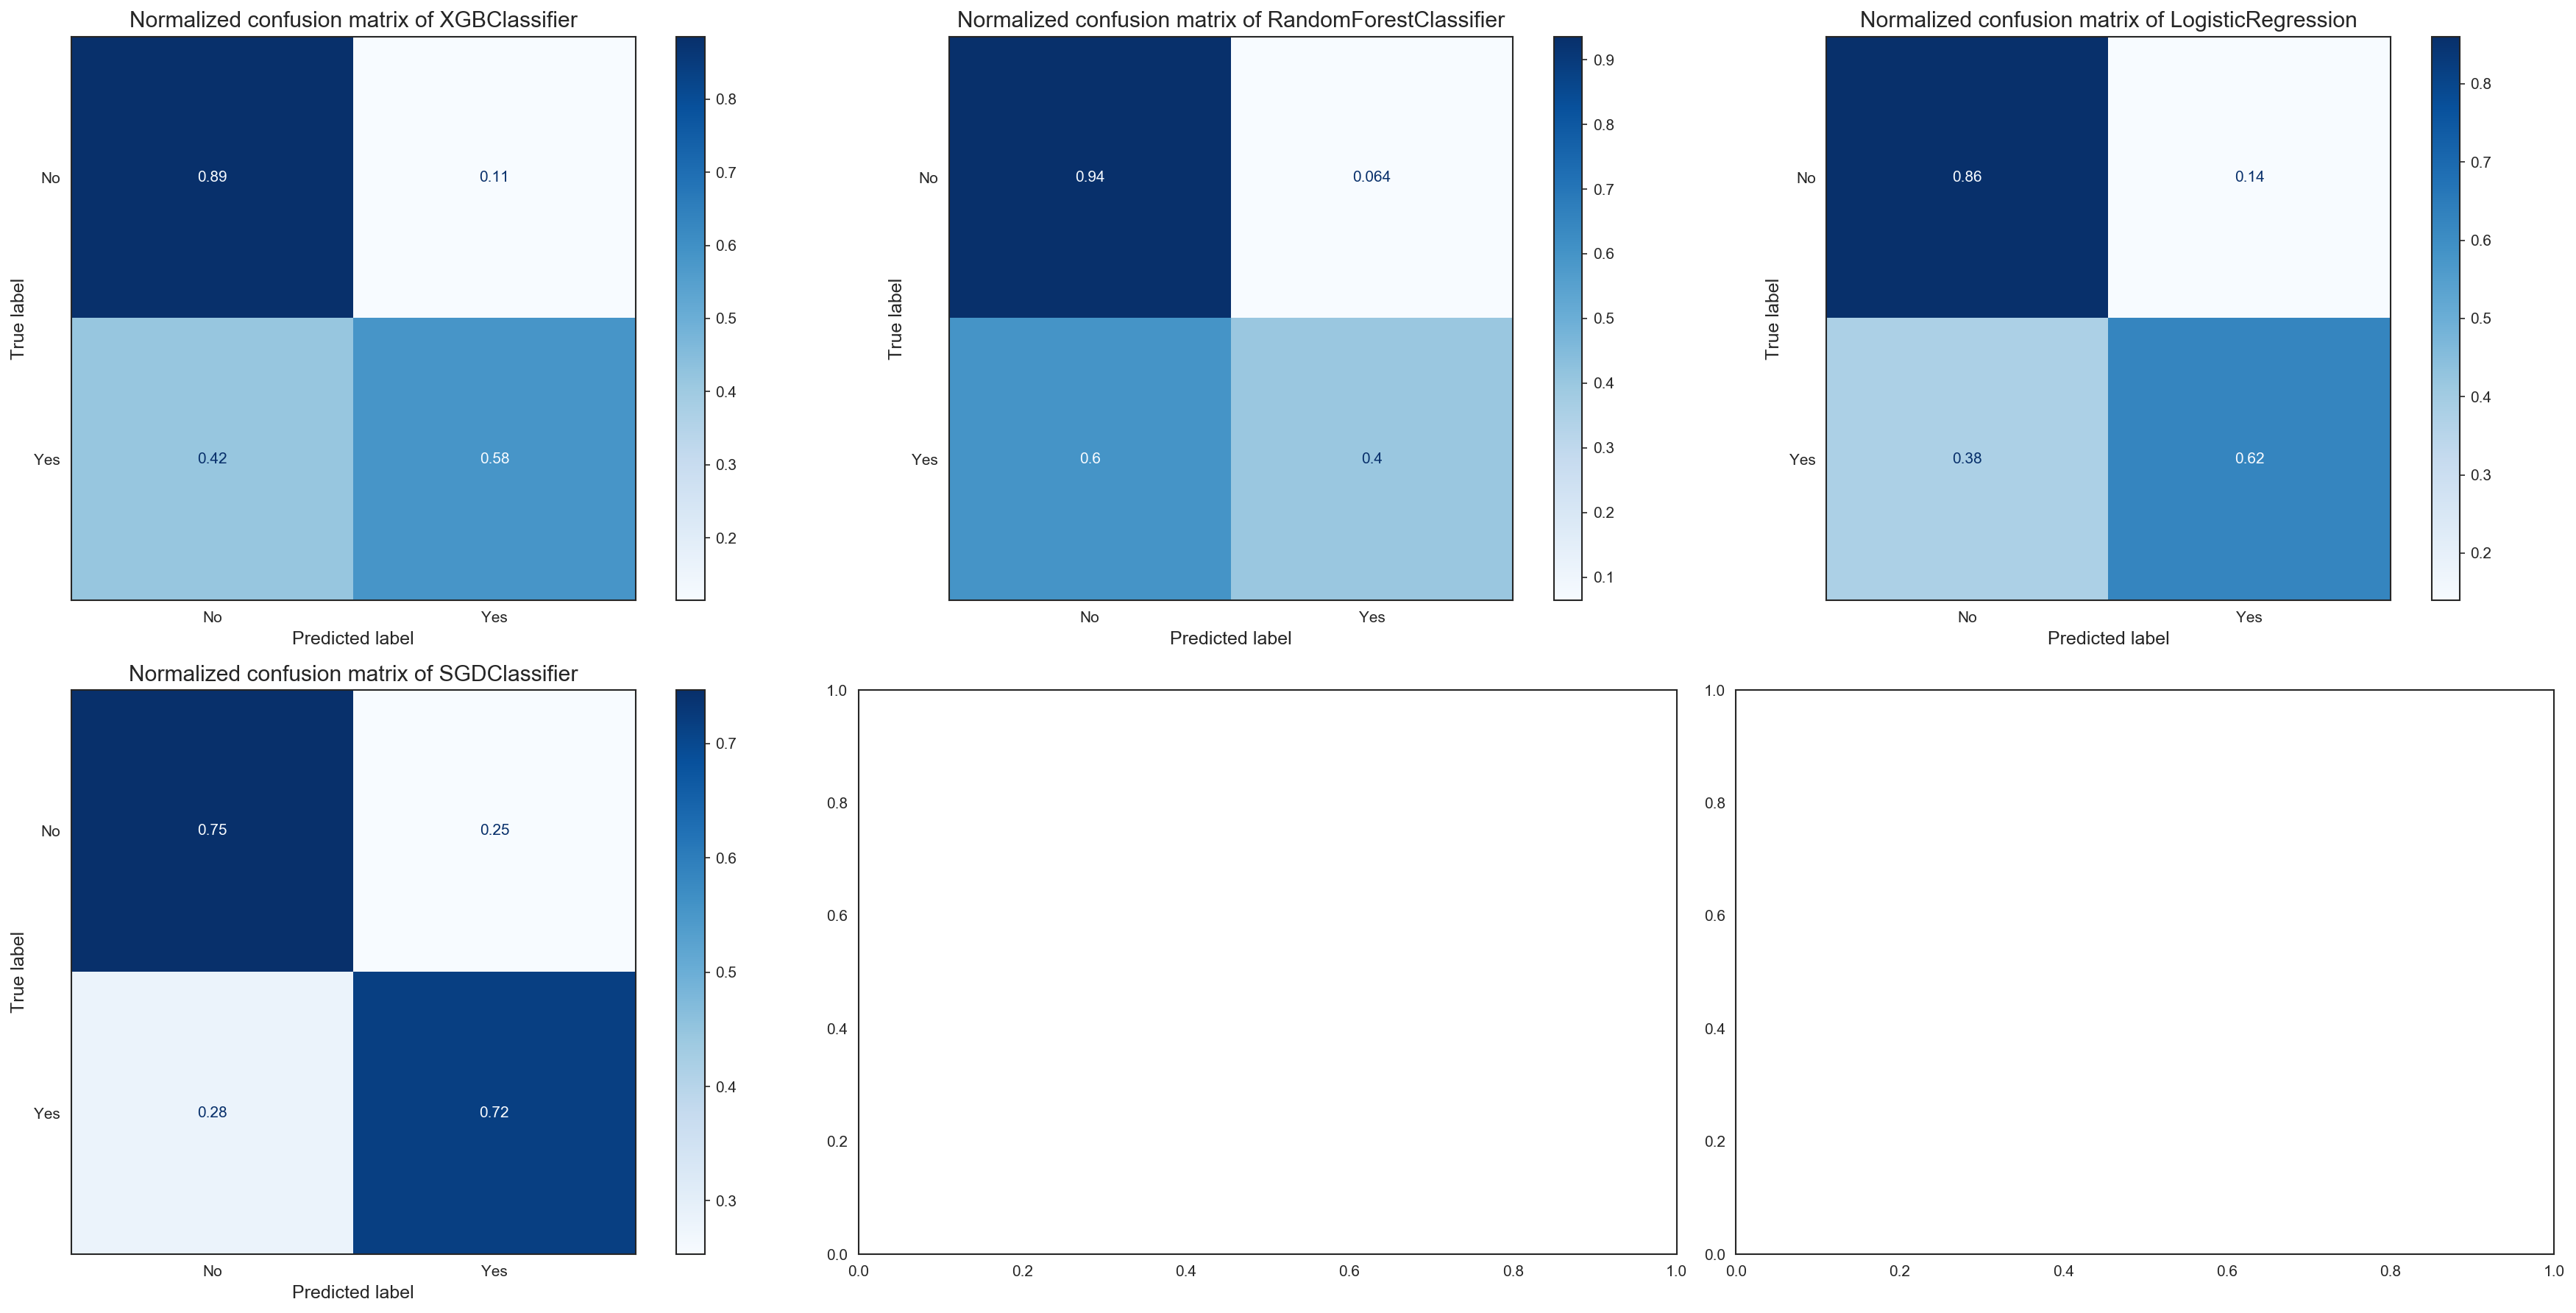

In [200]:
binary_testing([xgb_clf,rf_clf,log_clf,sdg_clf],X_test,y_test)

# 5.5 AdaBoost

In [271]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [272]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),)

param_dist = {
        'learning_rate':[0.1,0.3,0.5],
        'n_estimators': [50,100,200],
        'random_state':[46]}

fit_params = {'X':X_train,
              'y':y_train}

rs_clf = GridSearchCV(clf, param_dist, # n_iter=60,
                            n_jobs=-1, verbose=2, cv=3,
                            scoring='neg_log_loss', refit=False)

print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(**fit_params)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:   30.6s remaining:   15.3s


Randomized search time: 40.046072006225586
Best score: -0.639675055579005
Best params: 
learning_rate: 0.1
n_estimators: 50
random_state: 46


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   40.0s finished


In [273]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

param_dist = {
        'learning_rate':loguniform(10**-3, 10**-1),
        'n_estimators': randint(10,55),
        'random_state':[46]}

fit_params = {'X':X_train,
              'y':y_train}

rs_clf = RandomizedSearchCV(clf, param_dist,  n_iter=60,random_state=11,
                            n_jobs=-1, verbose=2, cv=3,
                            scoring='neg_log_loss', refit=False)

print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(**fit_params)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   50.9s


Randomized search time: 64.58227396011353
Best score: -0.5745600796592215
Best params: 
learning_rate: 0.03599203418226065
n_estimators: 10
random_state: 46


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.1min finished


In [274]:
# Now fit the best model
paras_ada = best_params
ada_clf = AdaBoostClassifier(**paras_ada)
ada_clf.fit(**fit_params)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                   learning_rate=0.03599203418226065, n_estimators=10,
                   random_state=46)

In [275]:
dump(ada_clf, 'ada_clf.joblib') 

['ada_clf.joblib']

In [37]:
ada_clf = load('ada_clf.joblib')


 Calssification Report of XGBClassifier
              precision    recall  f1-score   support

          No       0.94      0.89      0.91      3657
         Yes       0.39      0.58      0.47       462

    accuracy                           0.85      4119
   macro avg       0.67      0.73      0.69      4119
weighted avg       0.88      0.85      0.86      4119

confusion_matrix of XGBClassifier
[[0.88569866 0.11430134]
 [0.41774892 0.58225108]]




[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished



 Calssification Report of RandomForestClassifier
              precision    recall  f1-score   support

          No       0.93      0.94      0.93      3657
         Yes       0.44      0.40      0.42       462

    accuracy                           0.88      4119
   macro avg       0.68      0.67      0.68      4119
weighted avg       0.87      0.88      0.87      4119

confusion_matrix of RandomForestClassifier
[[0.93601313 0.06398687]
 [0.5995671  0.4004329 ]]


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished





 Calssification Report of LogisticRegression
              precision    recall  f1-score   support

          No       0.95      0.86      0.90      3657
         Yes       0.36      0.62      0.46       462

    accuracy                           0.83      4119
   macro avg       0.65      0.74      0.68      4119
weighted avg       0.88      0.83      0.85      4119

confusion_matrix of LogisticRegression
[[0.86054143 0.13945857]
 [0.37878788 0.62121212]]



 Calssification Report of SGDClassifier
              precision    recall  f1-score   support

          No       0.95      0.75      0.84      3657
         Yes       0.26      0.72      0.39       462

    accuracy                           0.74      4119
   macro avg       0.61      0.73      0.61      4119
weighted avg       0.88      0.74      0.79      4119

confusion_matrix of SGDClassifier
[[0.74678698 0.25321302]
 [0.28354978 0.71645022]]



 Calssification Report of AdaBoostClassifier
              precision    recal

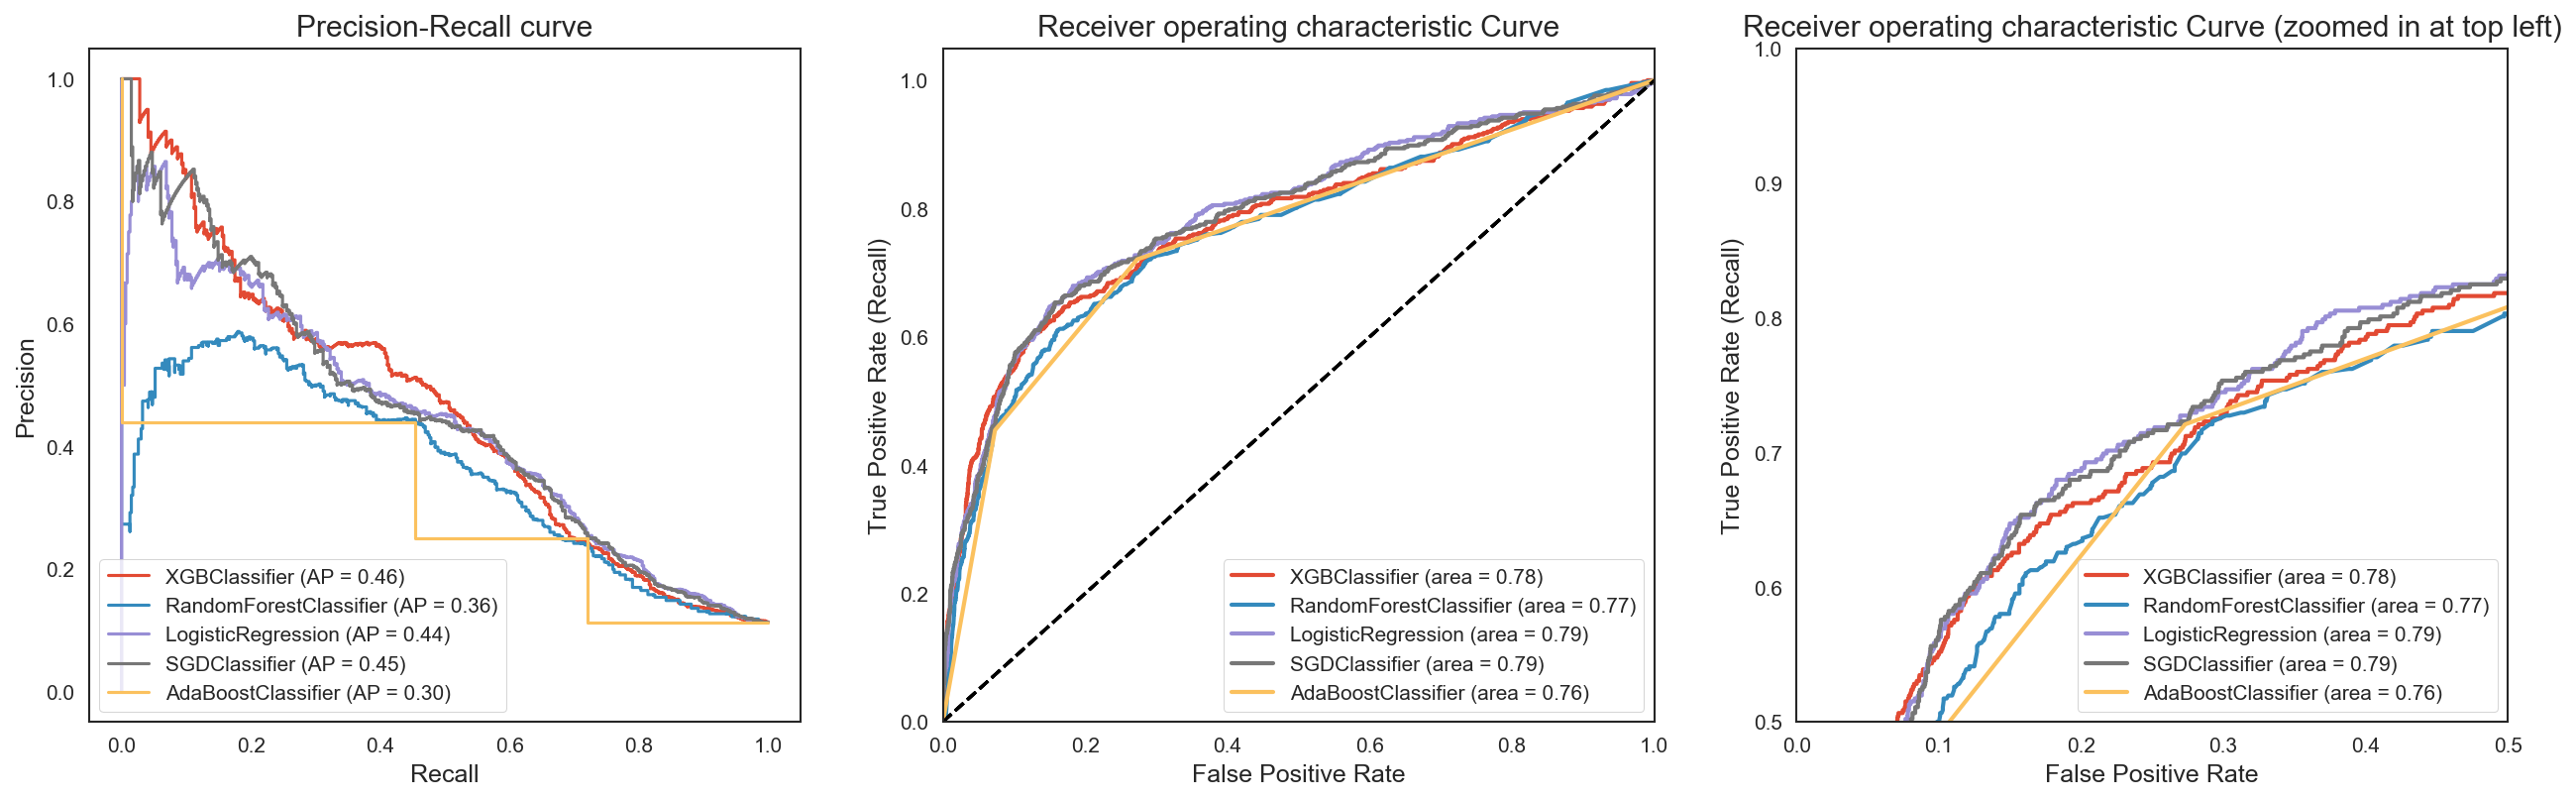

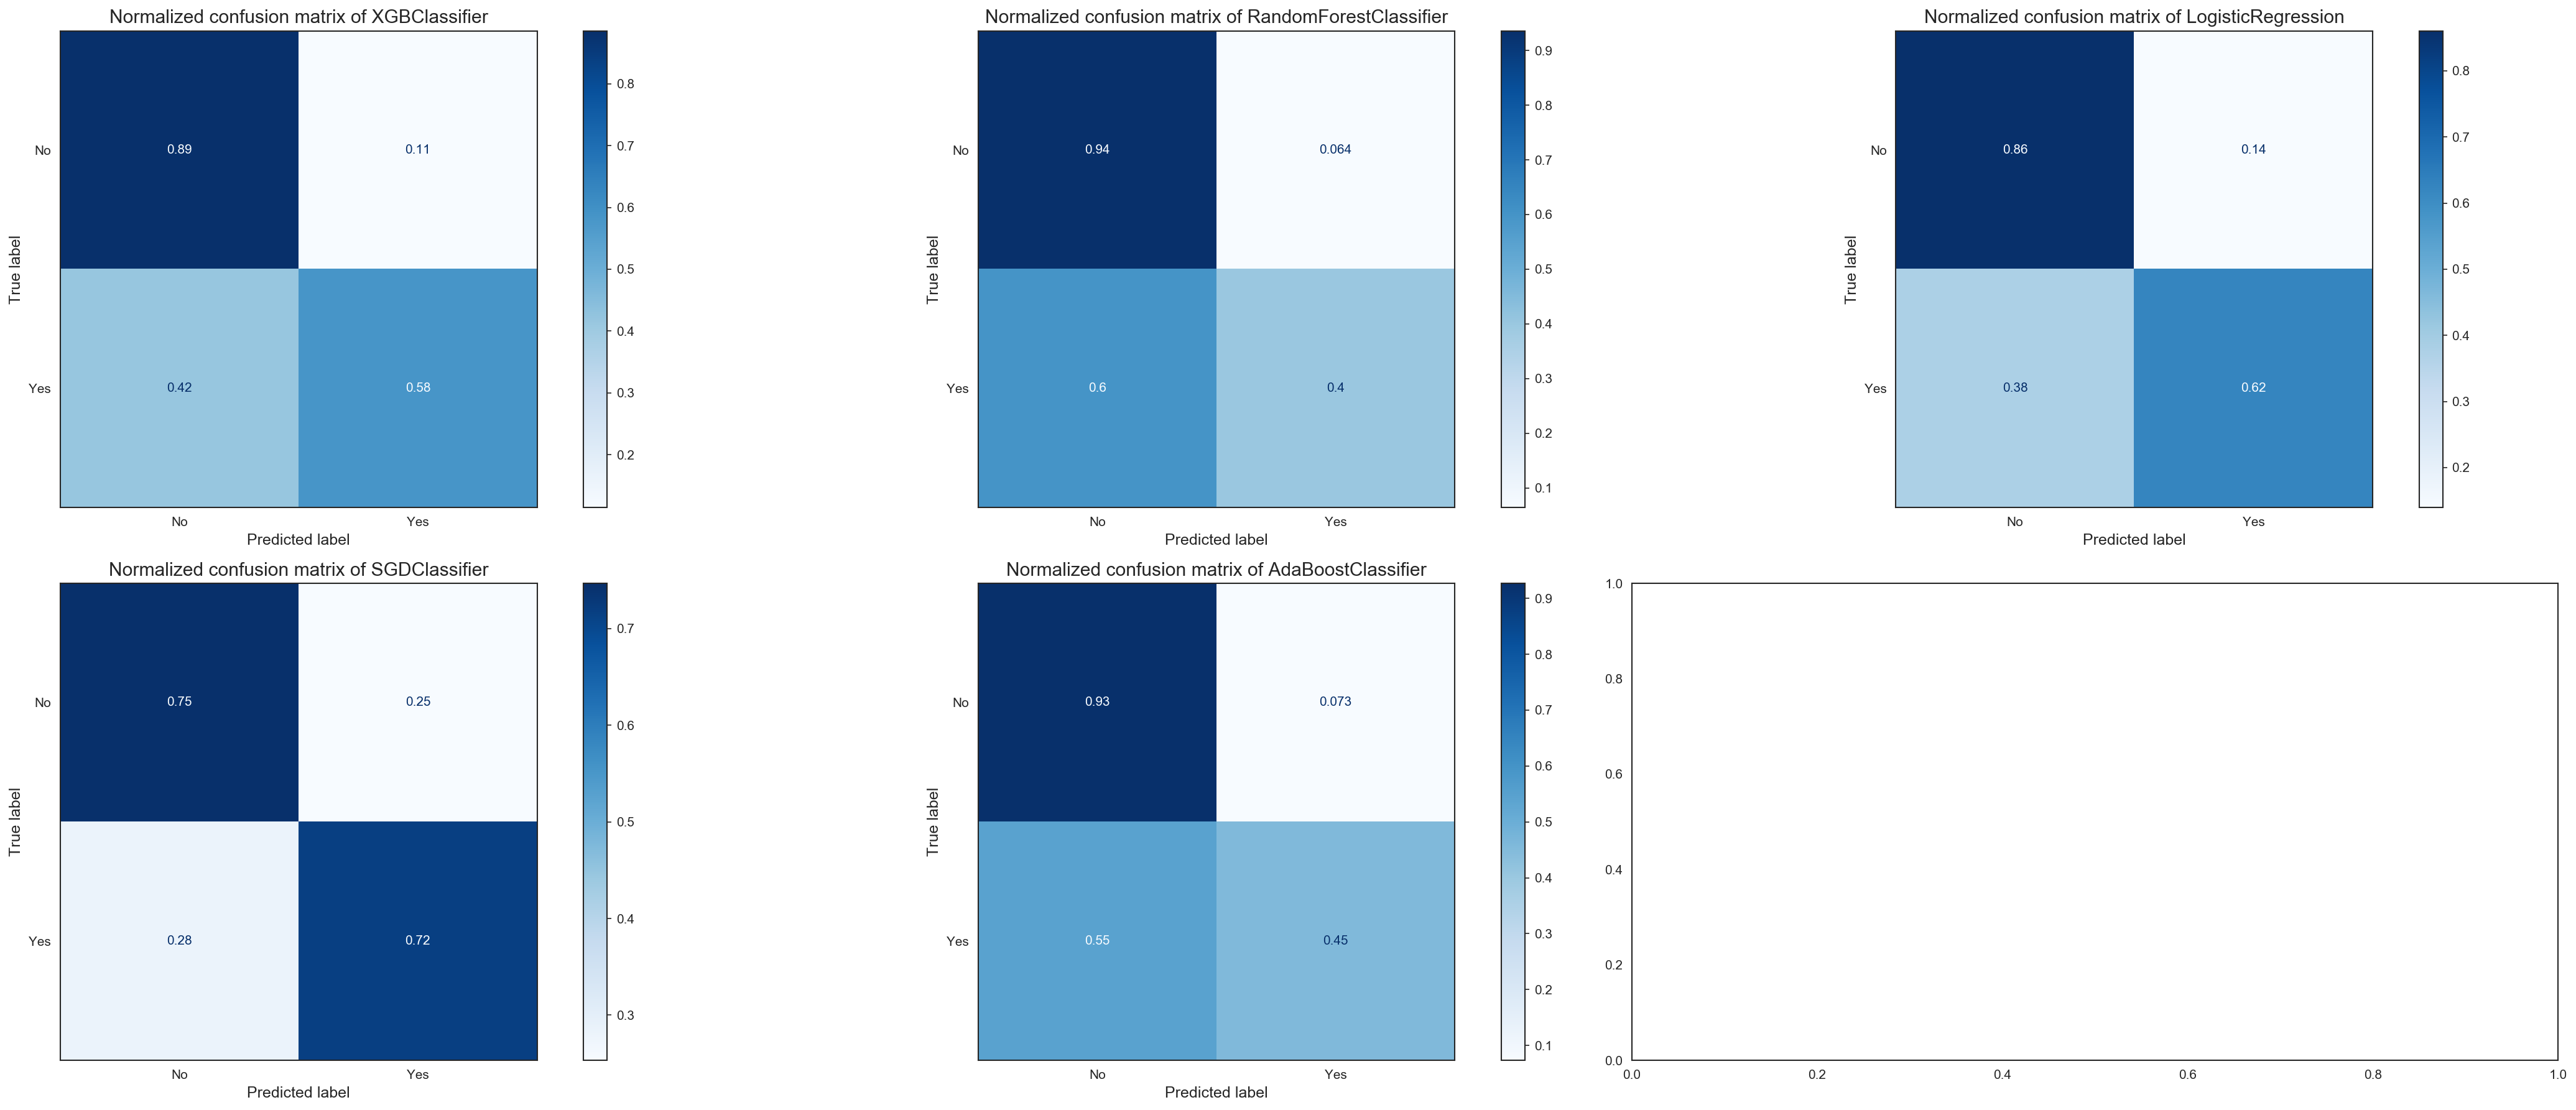

In [276]:
binary_testing([xgb_clf,rf_clf,log_clf,sdg_clf,ada_clf],X_test,y_test)

# 5.6 Voting Classifier

In [277]:
xbg1 = xgb.XGBClassifier()
rnd1 = RandomForestClassifier()
svm1 = SGDClassifier(loss = 'modified_huber') #LinearSVC(loss = 'hinge',dual=False)
log1 = LogisticRegression()
ada1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

voting_clf = VotingClassifier(
estimators=[('xgb',xbg1),('rf',rnd1),('SVM',svm1),('logistic',log1),('ada',ada1)],
voting = 'soft',n_jobs=-1)

In [278]:
voting_clf.fit(X_train.toarray(),y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight...
                                                                                       criterion='gini',
                                                    


 Calssification Report of XGBClassifier
              precision    recall  f1-score   support

          No       0.94      0.89      0.91      3657
         Yes       0.39      0.58      0.47       462

    accuracy                           0.85      4119
   macro avg       0.67      0.73      0.69      4119
weighted avg       0.88      0.85      0.86      4119

confusion_matrix of XGBClassifier
[[0.88569866 0.11430134]
 [0.41774892 0.58225108]]




[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished



 Calssification Report of RandomForestClassifier
              precision    recall  f1-score   support

          No       0.93      0.94      0.93      3657
         Yes       0.44      0.40      0.42       462

    accuracy                           0.88      4119
   macro avg       0.68      0.67      0.68      4119
weighted avg       0.87      0.88      0.87      4119

confusion_matrix of RandomForestClassifier
[[0.93601313 0.06398687]
 [0.5995671  0.4004329 ]]


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished





 Calssification Report of LogisticRegression
              precision    recall  f1-score   support

          No       0.95      0.86      0.90      3657
         Yes       0.36      0.62      0.46       462

    accuracy                           0.83      4119
   macro avg       0.65      0.74      0.68      4119
weighted avg       0.88      0.83      0.85      4119

confusion_matrix of LogisticRegression
[[0.86054143 0.13945857]
 [0.37878788 0.62121212]]



 Calssification Report of SGDClassifier
              precision    recall  f1-score   support

          No       0.95      0.75      0.84      3657
         Yes       0.26      0.72      0.39       462

    accuracy                           0.74      4119
   macro avg       0.61      0.73      0.61      4119
weighted avg       0.88      0.74      0.79      4119

confusion_matrix of SGDClassifier
[[0.74678698 0.25321302]
 [0.28354978 0.71645022]]



 Calssification Report of AdaBoostClassifier
              precision    recal

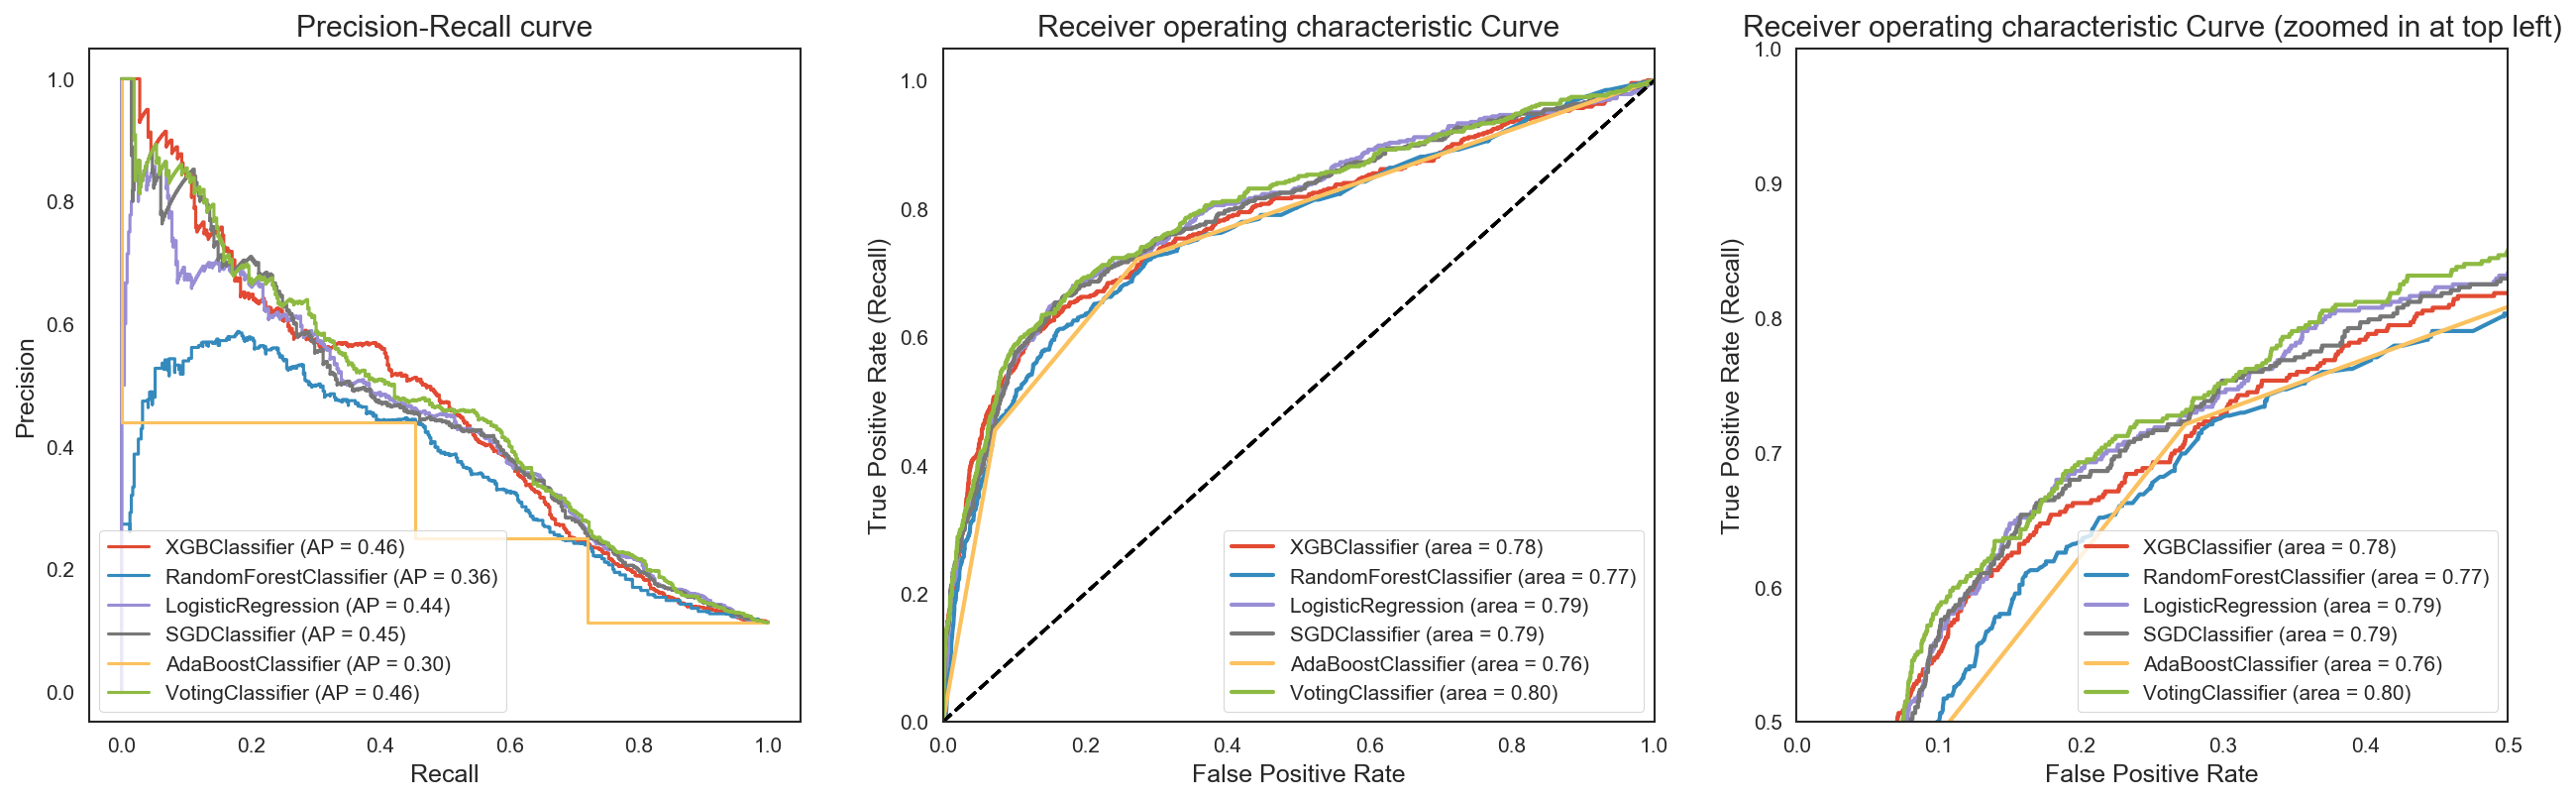

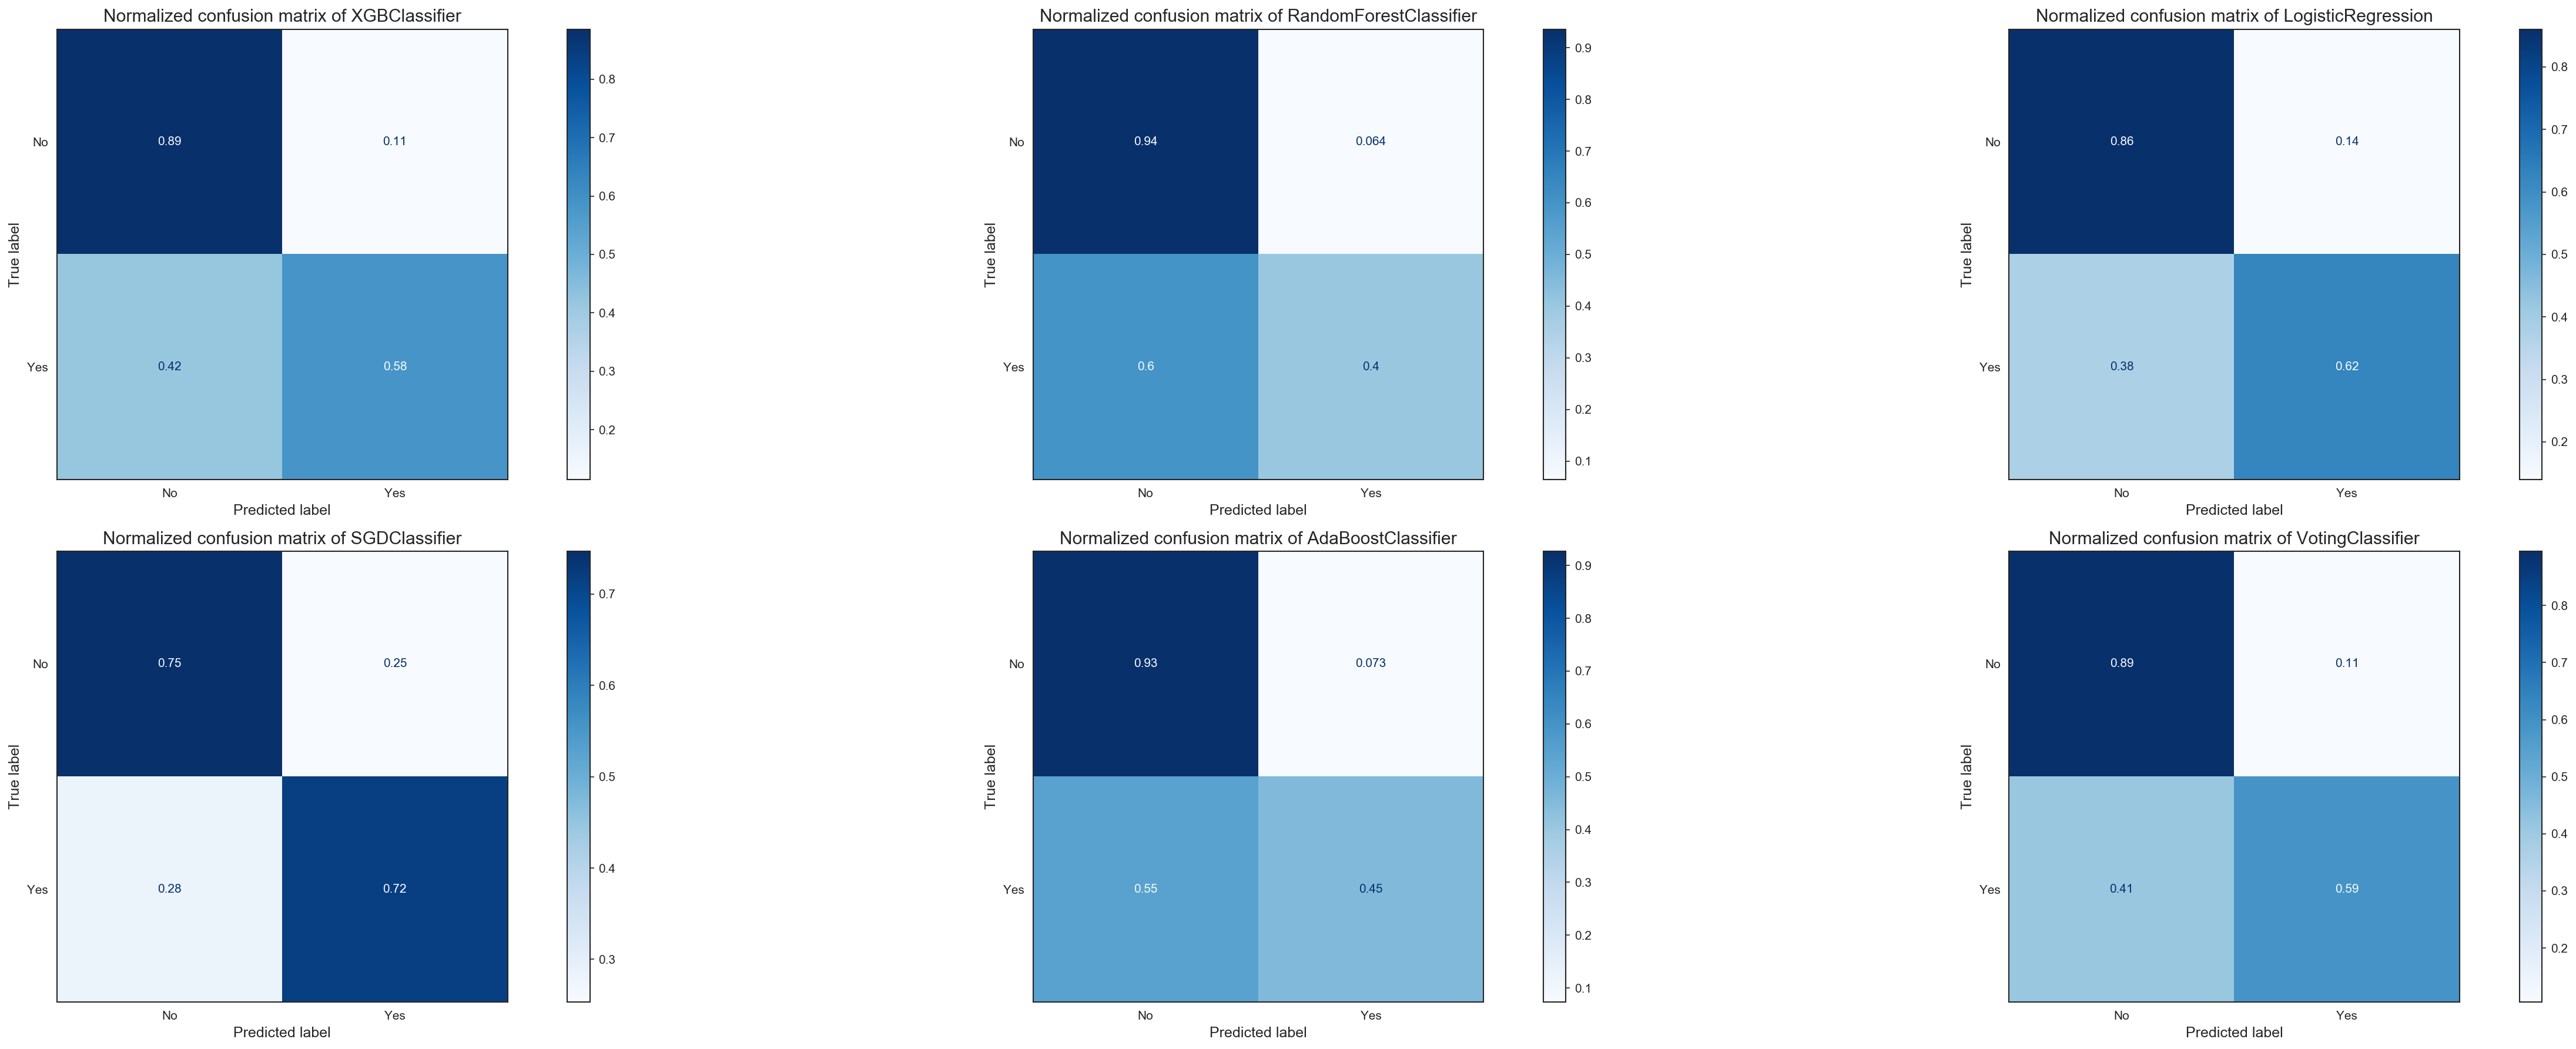

In [279]:
binary_testing([xgb_clf,rf_clf,log_clf,sdg_clf,ada_clf,voting_clf],X_test,y_test)

In [280]:
dump(voting_clf, 'voting_clf.joblib') 

['voting_clf.joblib']

In [38]:
voting_clf = load('voting_clf.joblib')

# 5.7 Neural Network

In [281]:
def add_layer(model,units=6,l2_rate=0):
    
    if l2_rate>0:
        model.add(Dense(units = units,kernel_regularizer=l2(l2_rate),
                  activation = 'elu',kernel_initializer = 'he_normal'))
    else:
        model.add(Dense(units = units,activation = 'elu',kernel_initializer = 'he_normal'))
    
    return model

                  
def ann(hidden_layers = 1,units = 6,dropout_rate = 0,l2_rate = 0):
    model = Sequential()

    if l2_rate>0:
        model.add(Dense(units = units,input_dim = 61,kernel_regularizer=l2(l2_rate),
                  activation = 'elu',kernel_initializer = 'he_normal'))
    else:
        model.add(Dense(units = units,input_dim = 61,
                  activation = 'elu',kernel_initializer = 'he_normal'))

    for i in range(hidden_layers):
        
        model = add_layer(model,units,l2_rate)
        
        if dropout_rate >0:
            model.add(Dropout(dropout_rate))
            
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model
            

In [282]:
es = EarlyStopping(patience=9,restore_best_weights=True)
ms = ModelCheckpoint('ann.h5',save_best_only = True)
lr_sch = ReduceLROnPlateau(factor = 0.2,patience=3,verbose=1)

In [283]:
fit_params = {'x':X_train_small.toarray(),
              'y': y_train_small,
              'epochs':100,
#               'batch_size':16,
              'validation_data':(X_val.toarray(),y_val),
              'callbacks': [es,ms,lr_sch],
                 'verbose':1}

In [284]:
space  = [Integer(1, 6, name='hidden_layers'),
          Integer(6, 100, name='units'),
          Real(10**-10, 10**0, "log-uniform", name='l2_rate')]


@use_named_args(space)
def objective(**params):
    print(params)

    clf = ann(**params)
#     clf.set_params(**params)
    clf.fit(**fit_params)
    obj = np.mean(log_loss(y_val,clf.predict_proba(X_val.toarray())))

    return obj

In [285]:
# objective((1,10,0.1))

In [286]:
%%time
clf_gp = gp_minimize(objective, space, n_calls=50, random_state=101)

{'hidden_layers': 4, 'units': 96, 'l2_rate': 0.6989983432055058}
Train on 61858 samples, validate on 3924 samples
Epoch 1/100
61858/61858 [==============================] - 3s 50us/sample - loss: 31.5687 - accuracy: 0.5146 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/100
61858/61858 [==============================] - 3s 43us/sample - loss: 0.6934 - accuracy: 0.5033 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 3/100
61858/61858 [==============================] - 3s 43us/sample - loss: 0.6934 - accuracy: 0.5035 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/100
61728/61858 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5010
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
61858/61858 [==============================] - 3s 44us/sample - loss: 0.6933 - accuracy: 0.5009 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 5/100
61858/61858 [==============================] - 3s 46us/sample - loss: 0.6932 - accuracy: 0.4996 - val_l

61858/61858 [==============================] - 2s 34us/sample - loss: 0.5939 - accuracy: 0.7314 - val_loss: 0.5717 - val_accuracy: 0.7464
Epoch 20/100
61858/61858 [==============================] - 2s 34us/sample - loss: 0.5940 - accuracy: 0.7319 - val_loss: 0.5662 - val_accuracy: 0.7533
Epoch 21/100
60992/61858 [============================>.] - ETA: 0s - loss: 0.5932 - accuracy: 0.7321
Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
61858/61858 [==============================] - 2s 35us/sample - loss: 0.5934 - accuracy: 0.7318 - val_loss: 0.5685 - val_accuracy: 0.7462
Epoch 22/100
61858/61858 [==============================] - 2s 34us/sample - loss: 0.5904 - accuracy: 0.7323 - val_loss: 0.5613 - val_accuracy: 0.7518
Epoch 23/100
61858/61858 [==============================] - 2s 35us/sample - loss: 0.5900 - accuracy: 0.7328 - val_loss: 0.5609 - val_accuracy: 0.7533
Epoch 24/100
61858/61858 [==============================] - 2s 34us/sample - loss: 0.589

Epoch 9/100
61632/61858 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5017
Epoch 00009: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
61858/61858 [==============================] - 2s 39us/sample - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 10/100
61858/61858 [==============================] - 2s 40us/sample - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 11/100
61858/61858 [==============================] - 2s 39us/sample - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 12/100
61664/61858 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.4983
Epoch 00012: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
61858/61858 [==============================] - 2s 40us/sample - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 13/100
61858/61858 [==============================] 

61120/61858 [============================>.] - ETA: 0s - loss: 0.5469 - accuracy: 0.7375
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
61858/61858 [==============================] - 2s 35us/sample - loss: 0.5471 - accuracy: 0.7374 - val_loss: 0.5210 - val_accuracy: 0.7597
Epoch 8/100
61858/61858 [==============================] - 2s 34us/sample - loss: 0.5441 - accuracy: 0.7401 - val_loss: 0.5183 - val_accuracy: 0.7599
Epoch 9/100
61858/61858 [==============================] - 2s 34us/sample - loss: 0.5438 - accuracy: 0.7398 - val_loss: 0.5187 - val_accuracy: 0.7576
Epoch 10/100
61858/61858 [==============================] - 2s 34us/sample - loss: 0.5435 - accuracy: 0.7403 - val_loss: 0.5179 - val_accuracy: 0.7625
Epoch 11/100
61858/61858 [==============================] - 2s 37us/sample - loss: 0.5434 - accuracy: 0.7401 - val_loss: 0.5196 - val_accuracy: 0.7630
Epoch 12/100
61858/61858 [==============================] - 2s 35us/sample - loss: 0.5432 

Epoch 5/100
61858/61858 [==============================] - 2s 28us/sample - loss: 0.5293 - accuracy: 0.7439 - val_loss: 0.5120 - val_accuracy: 0.7658
Epoch 6/100
61858/61858 [==============================] - 2s 27us/sample - loss: 0.5288 - accuracy: 0.7441 - val_loss: 0.5114 - val_accuracy: 0.7683
Epoch 7/100
59936/61858 [============================>.] - ETA: 0s - loss: 0.5284 - accuracy: 0.7447
Epoch 00007: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
61858/61858 [==============================] - 2s 27us/sample - loss: 0.5286 - accuracy: 0.7445 - val_loss: 0.5130 - val_accuracy: 0.7668
Epoch 8/100
61858/61858 [==============================] - 2s 28us/sample - loss: 0.5281 - accuracy: 0.7436 - val_loss: 0.5119 - val_accuracy: 0.7671
Epoch 9/100
61858/61858 [==============================] - 2s 27us/sample - loss: 0.5280 - accuracy: 0.7442 - val_loss: 0.5118 - val_accuracy: 0.7648
Epoch 10/100
61024/61858 [============================>.] - ETA: 0s - loss: 0.52

Epoch 5/100
61792/61858 [============================>.] - ETA: 0s - loss: 0.3771 - accuracy: 0.8320
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
61858/61858 [==============================] - 3s 50us/sample - loss: 0.3770 - accuracy: 0.8320 - val_loss: 0.8296 - val_accuracy: 0.7337
Epoch 6/100
61858/61858 [==============================] - 3s 49us/sample - loss: 0.2674 - accuracy: 0.8890 - val_loss: 1.1085 - val_accuracy: 0.7378
Epoch 7/100
61858/61858 [==============================] - 3s 50us/sample - loss: 0.2242 - accuracy: 0.9134 - val_loss: 1.3688 - val_accuracy: 0.7240
Epoch 8/100
61568/61858 [============================>.] - ETA: 0s - loss: 0.1972 - accuracy: 0.9250
Epoch 00008: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
61858/61858 [==============================] - 3s 51us/sample - loss: 0.1969 - accuracy: 0.9252 - val_loss: 1.5942 - val_accuracy: 0.7271
Epoch 9/100
61858/61858 [==============================] - 3

Epoch 9/100
61858/61858 [==============================] - 2s 34us/sample - loss: 0.5196 - accuracy: 0.7497 - val_loss: 0.5084 - val_accuracy: 0.7696
Epoch 10/100
61858/61858 [==============================] - 2s 33us/sample - loss: 0.5195 - accuracy: 0.7499 - val_loss: 0.5094 - val_accuracy: 0.7686
Epoch 11/100
60352/61858 [============================>.] - ETA: 0s - loss: 0.5196 - accuracy: 0.7496
Epoch 00011: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
61858/61858 [==============================] - 2s 32us/sample - loss: 0.5194 - accuracy: 0.7500 - val_loss: 0.5084 - val_accuracy: 0.7727
{'hidden_layers': 1, 'units': 100, 'l2_rate': 0.0004294475733953754}
Train on 61858 samples, validate on 3924 samples
Epoch 1/100
61858/61858 [==============================] - 2s 38us/sample - loss: 0.6342 - accuracy: 0.7349 - val_loss: 0.5625 - val_accuracy: 0.7587
Epoch 2/100
61858/61858 [==============================] - 2s 32us/sample - loss: 0.5706 - accuracy: 0.7395 - v

/Users/kunhu/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


{'hidden_layers': 1, 'units': 6, 'l2_rate': 2.8483259879177427e-09}
Train on 61858 samples, validate on 3924 samples
Epoch 1/100
61858/61858 [==============================] - 2s 32us/sample - loss: 0.5534 - accuracy: 0.7240 - val_loss: 0.5147 - val_accuracy: 0.7564
Epoch 2/100
61858/61858 [==============================] - 2s 27us/sample - loss: 0.5393 - accuracy: 0.7379 - val_loss: 0.5148 - val_accuracy: 0.7541
Epoch 3/100
61858/61858 [==============================] - 2s 26us/sample - loss: 0.5363 - accuracy: 0.7395 - val_loss: 0.5122 - val_accuracy: 0.7635
Epoch 4/100
61858/61858 [==============================] - 2s 25us/sample - loss: 0.5330 - accuracy: 0.7421 - val_loss: 0.5100 - val_accuracy: 0.7610
Epoch 5/100
61858/61858 [==============================] - 2s 26us/sample - loss: 0.5299 - accuracy: 0.7445 - val_loss: 0.5095 - val_accuracy: 0.7638
Epoch 6/100
61858/61858 [==============================] - 2s 26us/sample - loss: 0.5280 - accuracy: 0.7454 - val_loss: 0.5137 - val_

Epoch 24/100
60576/61858 [============================>.] - ETA: 0s - loss: 0.5441 - accuracy: 0.7367
Epoch 00024: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
61858/61858 [==============================] - 2s 32us/sample - loss: 0.5443 - accuracy: 0.7366 - val_loss: 0.5166 - val_accuracy: 0.7579
{'hidden_layers': 1, 'units': 6, 'l2_rate': 0.0008947568812309721}
Train on 61858 samples, validate on 3924 samples
Epoch 1/100
61858/61858 [==============================] - 2s 33us/sample - loss: 0.5733 - accuracy: 0.7197 - val_loss: 0.5266 - val_accuracy: 0.7518
Epoch 2/100
61858/61858 [==============================] - 2s 27us/sample - loss: 0.5496 - accuracy: 0.7377 - val_loss: 0.5238 - val_accuracy: 0.7508
Epoch 3/100
61858/61858 [==============================] - 2s 26us/sample - loss: 0.5459 - accuracy: 0.7383 - val_loss: 0.5171 - val_accuracy: 0.7564
Epoch 4/100
61858/61858 [==============================] - 2s 27us/sample - loss: 0.5438 - accuracy: 0.7403 - val_

/Users/kunhu/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


{'hidden_layers': 1, 'units': 6, 'l2_rate': 1e-10}
Train on 61858 samples, validate on 3924 samples
Epoch 1/100
61858/61858 [==============================] - 2s 32us/sample - loss: 0.5505 - accuracy: 0.7302 - val_loss: 0.5084 - val_accuracy: 0.7663
Epoch 2/100
61858/61858 [==============================] - 2s 26us/sample - loss: 0.5343 - accuracy: 0.7423 - val_loss: 0.5066 - val_accuracy: 0.7625
Epoch 3/100
61858/61858 [==============================] - 2s 27us/sample - loss: 0.5317 - accuracy: 0.7422 - val_loss: 0.5076 - val_accuracy: 0.7630
Epoch 4/100
61858/61858 [==============================] - 2s 26us/sample - loss: 0.5302 - accuracy: 0.7430 - val_loss: 0.5058 - val_accuracy: 0.7635
Epoch 5/100
61858/61858 [==============================] - 2s 26us/sample - loss: 0.5289 - accuracy: 0.7438 - val_loss: 0.5078 - val_accuracy: 0.7643
Epoch 6/100
61858/61858 [==============================] - 2s 27us/sample - loss: 0.5281 - accuracy: 0.7445 - val_loss: 0.5073 - val_accuracy: 0.7645


/Users/kunhu/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


{'hidden_layers': 6, 'units': 6, 'l2_rate': 8.068971630267672e-10}
Train on 61858 samples, validate on 3924 samples
Epoch 1/100
61858/61858 [==============================] - 3s 55us/sample - loss: 0.5499 - accuracy: 0.7326 - val_loss: 0.5135 - val_accuracy: 0.7615
Epoch 2/100
61858/61858 [==============================] - 2s 36us/sample - loss: 0.5328 - accuracy: 0.7449 - val_loss: 0.5177 - val_accuracy: 0.7604
Epoch 3/100
61858/61858 [==============================] - 2s 37us/sample - loss: 0.5298 - accuracy: 0.7467 - val_loss: 0.5115 - val_accuracy: 0.7668
Epoch 4/100
61858/61858 [==============================] - 2s 37us/sample - loss: 0.5278 - accuracy: 0.7462 - val_loss: 0.5197 - val_accuracy: 0.7622
Epoch 5/100
61858/61858 [==============================] - 2s 40us/sample - loss: 0.5263 - accuracy: 0.7468 - val_loss: 0.5179 - val_accuracy: 0.7645
Epoch 6/100
61858/61858 [==============================] - 3s 41us/sample - loss: 0.5250 - accuracy: 0.7481 - val_loss: 0.5109 - val_a

61408/61858 [============================>.] - ETA: 0s - loss: 0.5313 - accuracy: 0.7494
Epoch 00014: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
61858/61858 [==============================] - 2s 32us/sample - loss: 0.5313 - accuracy: 0.7494 - val_loss: 0.5249 - val_accuracy: 0.7579
Epoch 15/100
61858/61858 [==============================] - 2s 32us/sample - loss: 0.5311 - accuracy: 0.7498 - val_loss: 0.5249 - val_accuracy: 0.7615
Epoch 16/100
61858/61858 [==============================] - 2s 31us/sample - loss: 0.5311 - accuracy: 0.7496 - val_loss: 0.5250 - val_accuracy: 0.7620
Epoch 17/100
60448/61858 [============================>.] - ETA: 0s - loss: 0.5313 - accuracy: 0.7497
Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
61858/61858 [==============================] - 2s 32us/sample - loss: 0.5311 - accuracy: 0.7498 - val_loss: 0.5251 - val_accuracy: 0.7620
{'hidden_layers': 1, 'units': 6, 'l2_rate': 1.3016896117799775e-05}
Tr

61858/61858 [==============================] - 2s 33us/sample - loss: 0.5373 - accuracy: 0.7473 - val_loss: 0.5262 - val_accuracy: 0.7699
Epoch 6/100
61858/61858 [==============================] - 2s 32us/sample - loss: 0.5340 - accuracy: 0.7483 - val_loss: 0.5287 - val_accuracy: 0.7661
Epoch 7/100
61858/61858 [==============================] - 2s 32us/sample - loss: 0.5319 - accuracy: 0.7487 - val_loss: 0.5318 - val_accuracy: 0.7533
Epoch 8/100
60352/61858 [============================>.] - ETA: 0s - loss: 0.5297 - accuracy: 0.7502
Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
61858/61858 [==============================] - 2s 33us/sample - loss: 0.5300 - accuracy: 0.7501 - val_loss: 0.5288 - val_accuracy: 0.7668
Epoch 9/100
61858/61858 [==============================] - 2s 31us/sample - loss: 0.5228 - accuracy: 0.7534 - val_loss: 0.5284 - val_accuracy: 0.7658
Epoch 10/100
61858/61858 [==============================] - 2s 32us/sample - loss: 0.5216 - 

/Users/kunhu/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


{'hidden_layers': 6, 'units': 6, 'l2_rate': 1e-10}
Train on 61858 samples, validate on 3924 samples
Epoch 1/100
61858/61858 [==============================] - 3s 42us/sample - loss: 0.5544 - accuracy: 0.7276 - val_loss: 0.5136 - val_accuracy: 0.7592
Epoch 2/100
61858/61858 [==============================] - 2s 34us/sample - loss: 0.5352 - accuracy: 0.7413 - val_loss: 0.5133 - val_accuracy: 0.7566
Epoch 3/100
61858/61858 [==============================] - 2s 33us/sample - loss: 0.5306 - accuracy: 0.7467 - val_loss: 0.5121 - val_accuracy: 0.7622
Epoch 4/100
61858/61858 [==============================] - 2s 33us/sample - loss: 0.5282 - accuracy: 0.7493 - val_loss: 0.5038 - val_accuracy: 0.7650
Epoch 5/100
61858/61858 [==============================] - 2s 32us/sample - loss: 0.5263 - accuracy: 0.7503 - val_loss: 0.5083 - val_accuracy: 0.7663
Epoch 6/100
61858/61858 [==============================] - 2s 35us/sample - loss: 0.5243 - accuracy: 0.7513 - val_loss: 0.5163 - val_accuracy: 0.7574


/Users/kunhu/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


{'hidden_layers': 1, 'units': 6, 'l2_rate': 1e-10}
Train on 61858 samples, validate on 3924 samples
Epoch 1/100
61858/61858 [==============================] - 2s 32us/sample - loss: 0.5450 - accuracy: 0.7324 - val_loss: 0.5097 - val_accuracy: 0.7666
Epoch 2/100
61858/61858 [==============================] - 2s 27us/sample - loss: 0.5335 - accuracy: 0.7425 - val_loss: 0.5063 - val_accuracy: 0.7655
Epoch 3/100
61858/61858 [==============================] - 2s 27us/sample - loss: 0.5312 - accuracy: 0.7442 - val_loss: 0.5087 - val_accuracy: 0.7671
Epoch 4/100
61858/61858 [==============================] - 2s 26us/sample - loss: 0.5296 - accuracy: 0.7450 - val_loss: 0.5127 - val_accuracy: 0.7671
Epoch 5/100
60288/61858 [============================>.] - ETA: 0s - loss: 0.5281 - accuracy: 0.7452
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
61858/61858 [==============================] - 2s 26us/sample - loss: 0.5284 - accuracy: 0.7450 - val_loss: 0.5138 - v

/Users/kunhu/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


{'hidden_layers': 1, 'units': 6, 'l2_rate': 7.296785631333012e-09}
Train on 61858 samples, validate on 3924 samples
Epoch 1/100
61858/61858 [==============================] - 2s 32us/sample - loss: 0.5472 - accuracy: 0.7309 - val_loss: 0.5111 - val_accuracy: 0.7589
Epoch 2/100
61858/61858 [==============================] - 2s 26us/sample - loss: 0.5347 - accuracy: 0.7410 - val_loss: 0.5183 - val_accuracy: 0.7554
Epoch 3/100
61858/61858 [==============================] - 2s 27us/sample - loss: 0.5319 - accuracy: 0.7441 - val_loss: 0.5106 - val_accuracy: 0.7663
Epoch 4/100
61858/61858 [==============================] - 2s 26us/sample - loss: 0.5303 - accuracy: 0.7445 - val_loss: 0.5089 - val_accuracy: 0.7620
Epoch 5/100
61858/61858 [==============================] - 2s 27us/sample - loss: 0.5289 - accuracy: 0.7440 - val_loss: 0.5080 - val_accuracy: 0.7645
Epoch 6/100
61858/61858 [==============================] - 2s 27us/sample - loss: 0.5280 - accuracy: 0.7455 - val_loss: 0.5068 - val_a

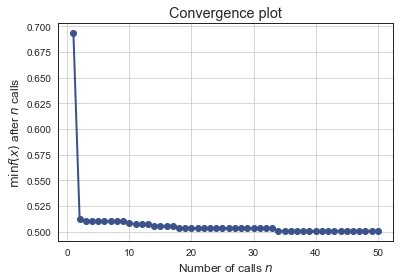

In [291]:
plot_convergence(clf_gp)

In [287]:
print(f"Best score={clf_gp.fun:.4f}" )

best_params = {
              'hidden_layers': 4,
              'units': 0.3,
              'l2_rate': 1}

for key,value in zip(best_params.keys(),clf_gp.x):
    print(f"{key} is {value} \n")
    best_params[key] = value

Best score=0.5006
hidden_layers is 6 

units is 100 

l2_rate is 0.000644129295822659 



In [288]:
# Now fit the best model
paras_ann = best_params
ann_clf = ann(**paras_ann)
ann_clf.fit(**fit_params)

Train on 61858 samples, validate on 3924 samples
Epoch 1/100
61858/61858 [==============================] - 4s 59us/sample - loss: 1.0470 - accuracy: 0.7353 - val_loss: 0.7153 - val_accuracy: 0.7612
Epoch 2/100
61858/61858 [==============================] - 3s 50us/sample - loss: 0.6228 - accuracy: 0.7402 - val_loss: 0.5438 - val_accuracy: 0.7582
Epoch 3/100
61858/61858 [==============================] - 3s 53us/sample - loss: 0.5561 - accuracy: 0.7402 - val_loss: 0.5234 - val_accuracy: 0.7630
Epoch 4/100
61858/61858 [==============================] - 3s 53us/sample - loss: 0.5483 - accuracy: 0.7405 - val_loss: 0.5412 - val_accuracy: 0.7332
Epoch 5/100
61858/61858 [==============================] - 3s 53us/sample - loss: 0.5461 - accuracy: 0.7414 - val_loss: 0.5181 - val_accuracy: 0.7607
Epoch 6/100
61858/61858 [==============================] - 3s 53us/sample - loss: 0.5444 - accuracy: 0.7432 - val_loss: 0.5312 - val_accuracy: 0.7525
Epoch 7/100
61858/61858 [==========================


 Calssification Report of XGBClassifier
              precision    recall  f1-score   support

          No       0.94      0.89      0.91      3657
         Yes       0.39      0.58      0.47       462

    accuracy                           0.85      4119
   macro avg       0.67      0.73      0.69      4119
weighted avg       0.88      0.85      0.86      4119

confusion_matrix of XGBClassifier
[[0.88569866 0.11430134]
 [0.41774892 0.58225108]]




[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished



 Calssification Report of RandomForestClassifier
              precision    recall  f1-score   support

          No       0.93      0.94      0.93      3657
         Yes       0.44      0.40      0.42       462

    accuracy                           0.88      4119
   macro avg       0.68      0.67      0.68      4119
weighted avg       0.87      0.88      0.87      4119

confusion_matrix of RandomForestClassifier
[[0.93601313 0.06398687]
 [0.5995671  0.4004329 ]]


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished





 Calssification Report of LogisticRegression
              precision    recall  f1-score   support

          No       0.95      0.86      0.90      3657
         Yes       0.36      0.62      0.46       462

    accuracy                           0.83      4119
   macro avg       0.65      0.74      0.68      4119
weighted avg       0.88      0.83      0.85      4119

confusion_matrix of LogisticRegression
[[0.86054143 0.13945857]
 [0.37878788 0.62121212]]



 Calssification Report of SGDClassifier
              precision    recall  f1-score   support

          No       0.95      0.75      0.84      3657
         Yes       0.26      0.72      0.39       462

    accuracy                           0.74      4119
   macro avg       0.61      0.73      0.61      4119
weighted avg       0.88      0.74      0.79      4119

confusion_matrix of SGDClassifier
[[0.74678698 0.25321302]
 [0.28354978 0.71645022]]



 Calssification Report of AdaBoostClassifier
              precision    recal

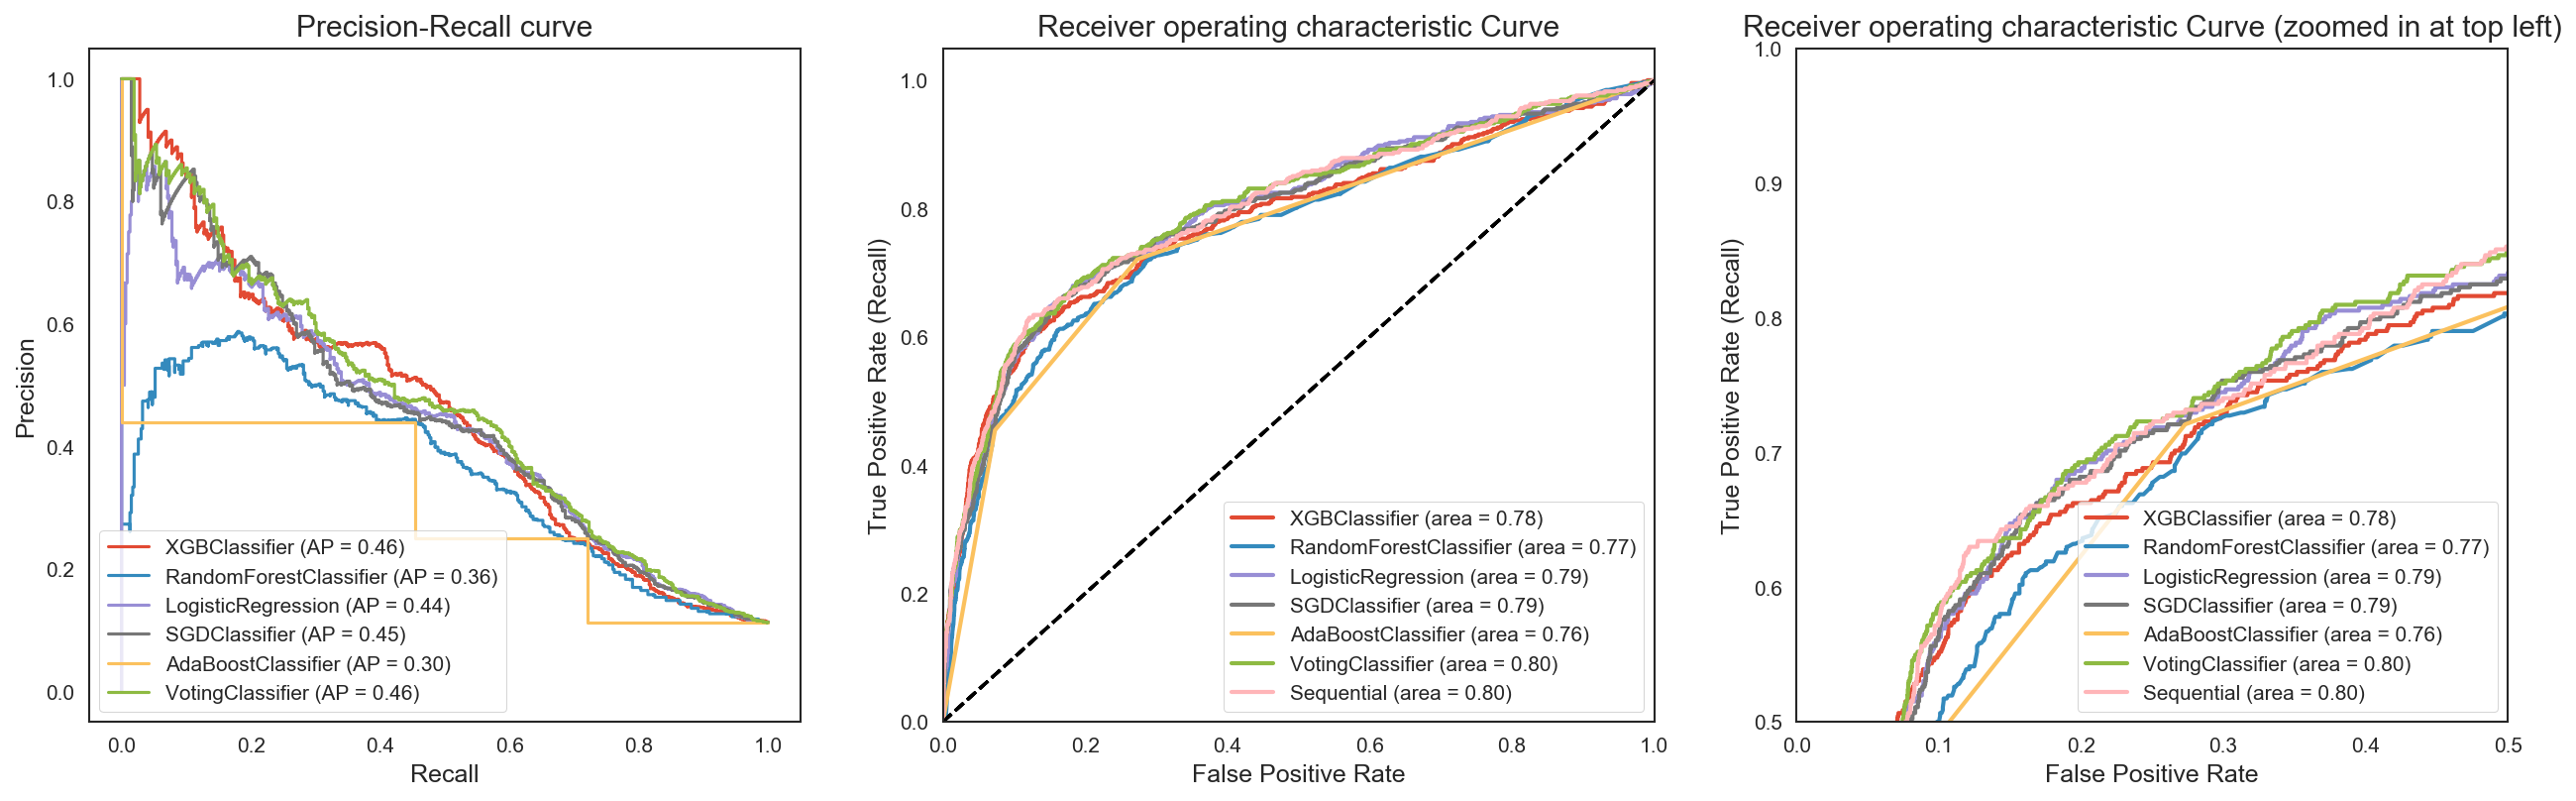

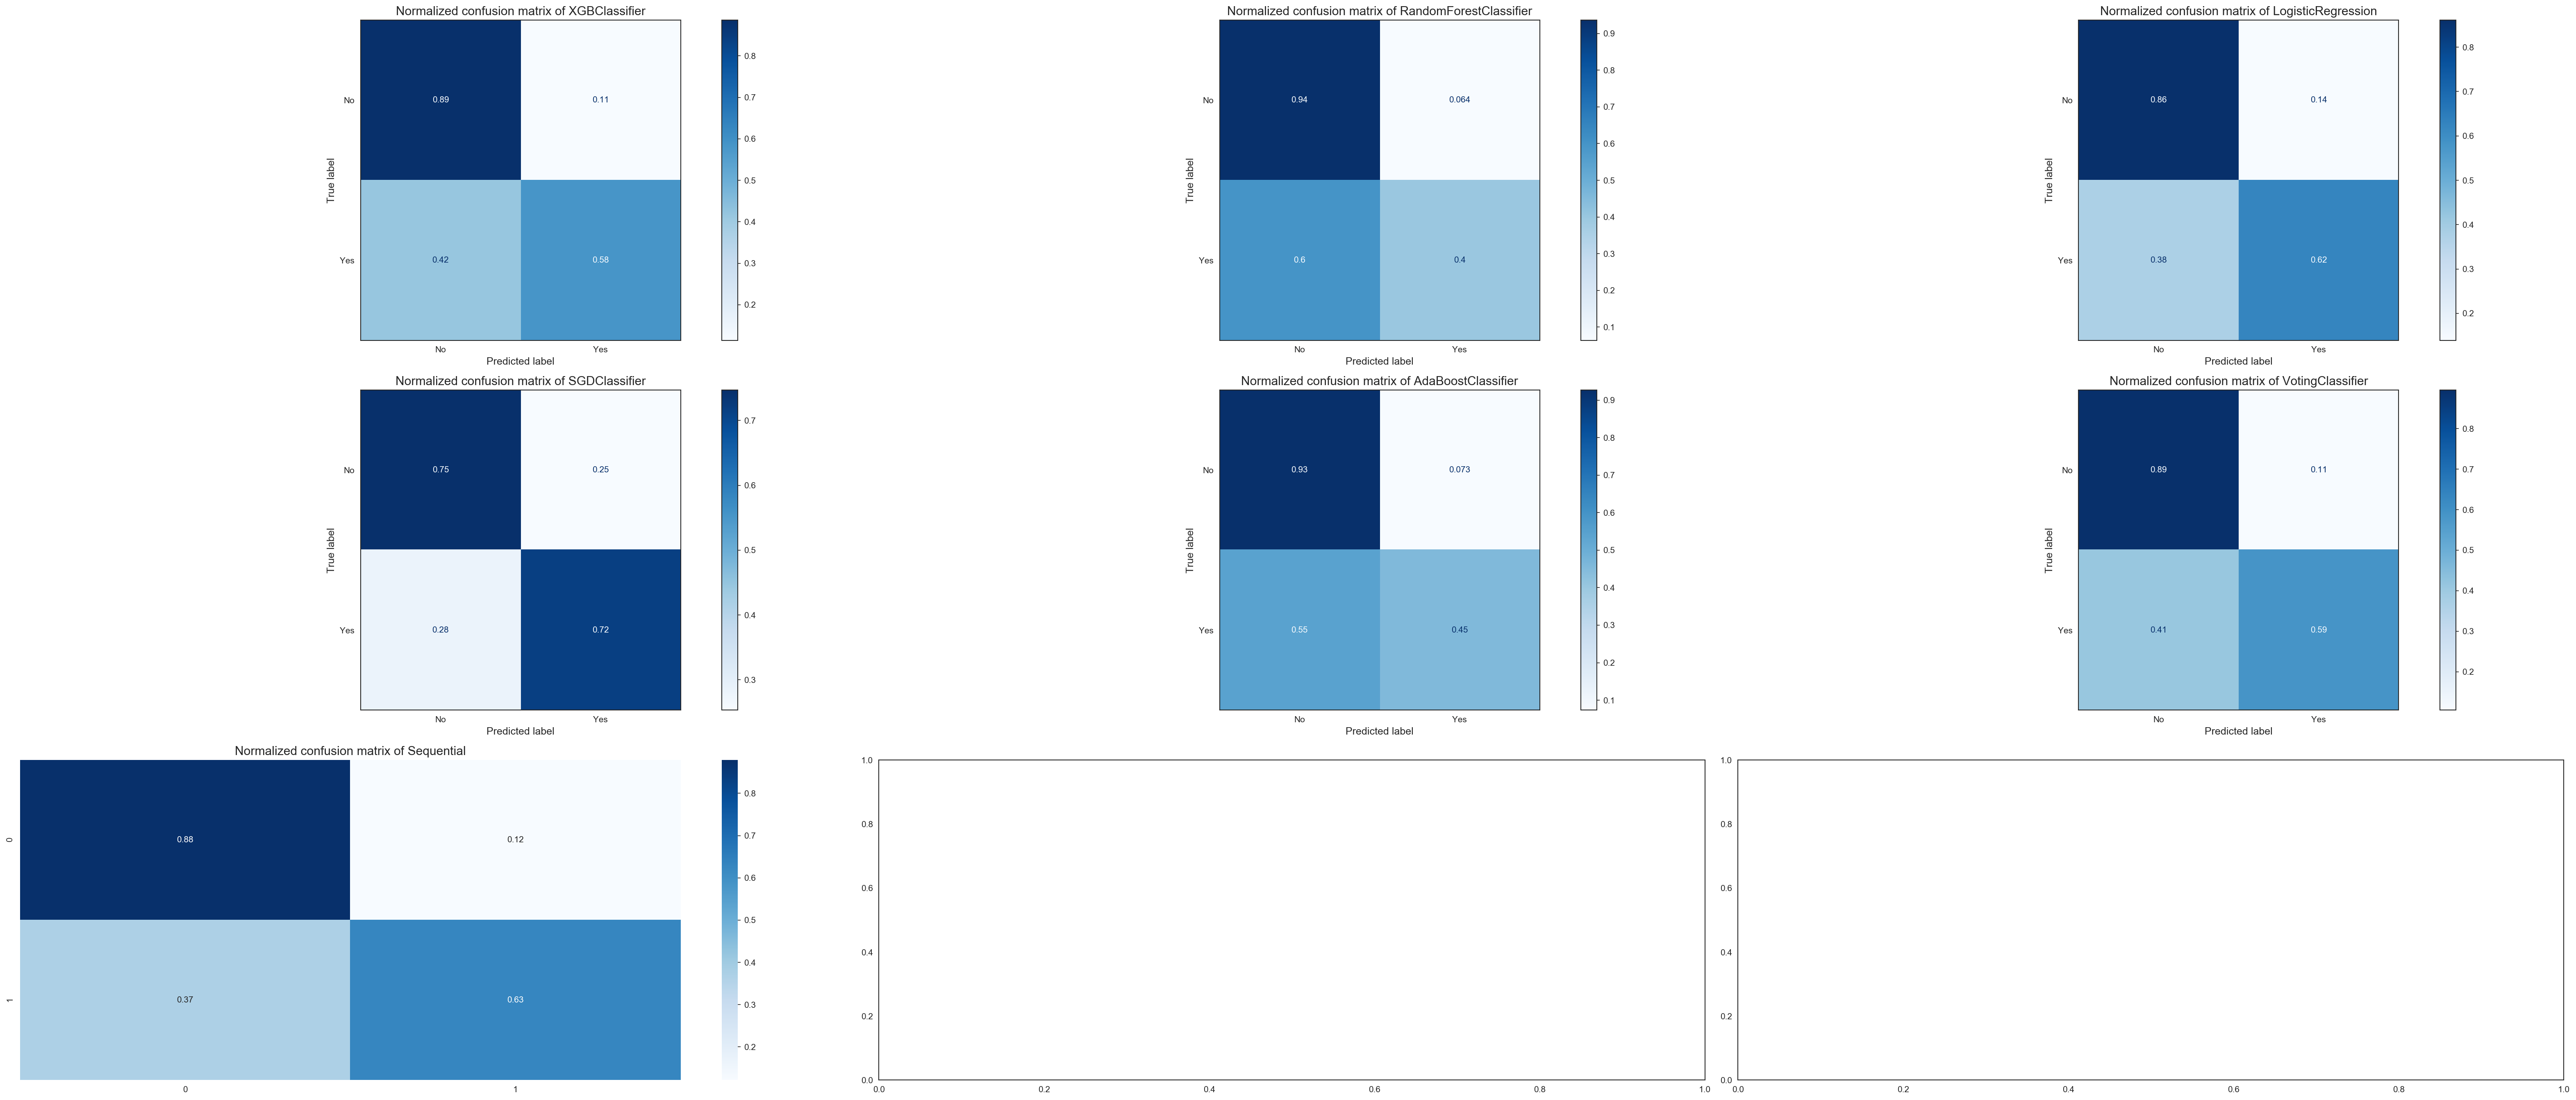

In [345]:
binary_testing([xgb_clf,rf_clf,log_clf,sdg_clf,ada_clf,voting_clf,ann_clf],X_test,y_test)

In [346]:
ann_clf.save('ann_clf.h5')

In [39]:
ann_clf = load_model('ann_clf.h5')

# 5.8 Bonus: Decision Tree

In [481]:
tree_clf = DecisionTreeClassifier(ccp_alpha = 0.5*10**-3,random_state=42)
tree_clf.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0005, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [484]:
y_pred = tree_clf.predict(X_test)
y_score = tree_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds  = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

print(roc_auc)

0.7929621422238321


In [491]:
dump(tree_clf, 'tree_clf.joblib') 

['tree_clf.joblib']

In [40]:
tree_clf = load('tree_clf.joblib')


 Calssification Report of DecisionTreeClassifier
              precision    recall  f1-score   support

          No       0.95      0.84      0.89      3657
         Yes       0.34      0.66      0.45       462

    accuracy                           0.82      4119
   macro avg       0.65      0.75      0.67      4119
weighted avg       0.88      0.82      0.84      4119

confusion_matrix of DecisionTreeClassifier
[[0.84140005 0.15859995]
 [0.34199134 0.65800866]]



 Calssification Report of XGBClassifier
              precision    recall  f1-score   support

          No       0.95      0.88      0.91      3657
         Yes       0.38      0.60      0.46       462

    accuracy                           0.84      4119
   macro avg       0.66      0.74      0.69      4119
weighted avg       0.88      0.84      0.86      4119

confusion_matrix of XGBClassifier
[[0.87585453 0.12414547]
 [0.4025974  0.5974026 ]]




[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished



 Calssification Report of RandomForestClassifier
              precision    recall  f1-score   support

          No       0.93      0.94      0.93      3657
         Yes       0.45      0.40      0.42       462

    accuracy                           0.88      4119
   macro avg       0.69      0.67      0.68      4119
weighted avg       0.87      0.88      0.87      4119

confusion_matrix of RandomForestClassifier
[[0.93792726 0.06207274]
 [0.5995671  0.4004329 ]]


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished





 Calssification Report of LogisticRegression
              precision    recall  f1-score   support

          No       0.95      0.86      0.90      3657
         Yes       0.36      0.62      0.46       462

    accuracy                           0.83      4119
   macro avg       0.65      0.74      0.68      4119
weighted avg       0.88      0.83      0.85      4119

confusion_matrix of LogisticRegression
[[0.85944763 0.14055237]
 [0.37662338 0.62337662]]



 Calssification Report of SGDClassifier
              precision    recall  f1-score   support

          No       0.95      0.75      0.84      3657
         Yes       0.26      0.72      0.39       462

    accuracy                           0.74      4119
   macro avg       0.61      0.73      0.61      4119
weighted avg       0.88      0.74      0.79      4119

confusion_matrix of SGDClassifier
[[0.74678698 0.25321302]
 [0.28354978 0.71645022]]



 Calssification Report of AdaBoostClassifier
              precision    recal

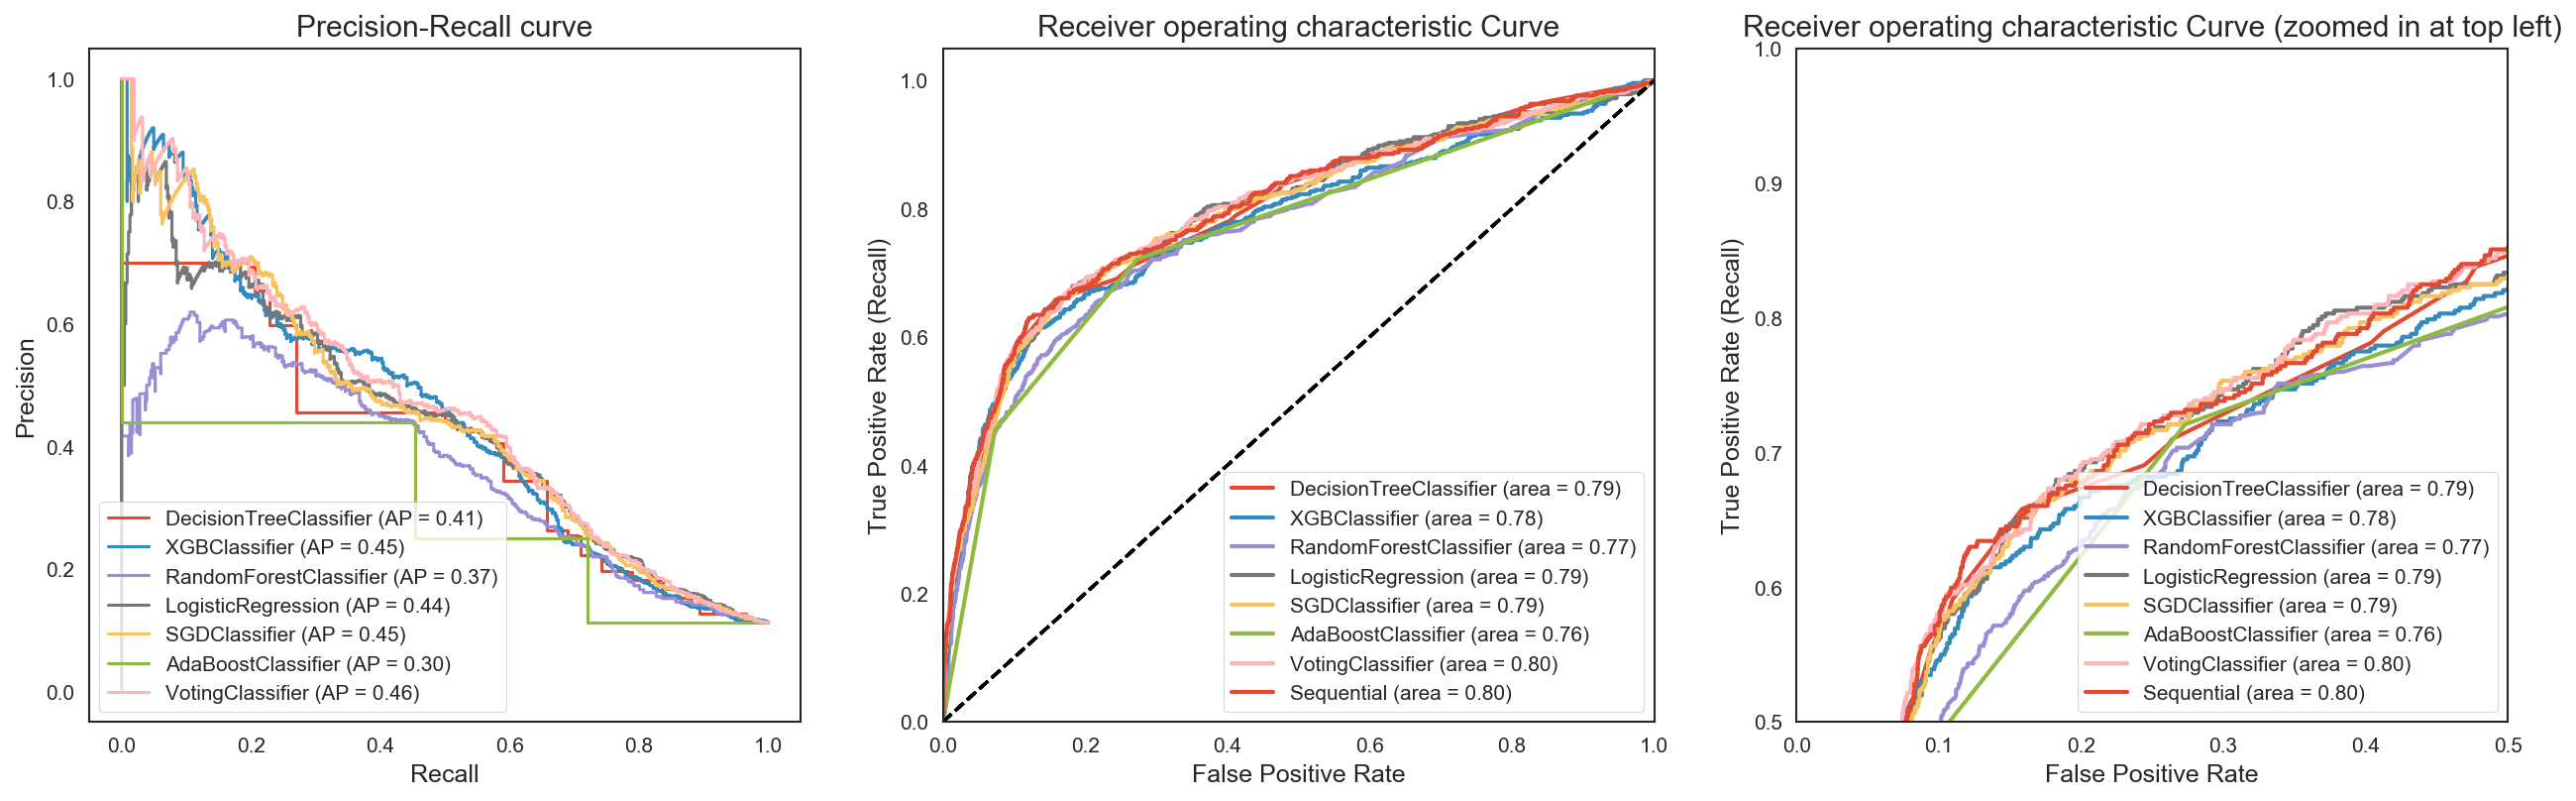

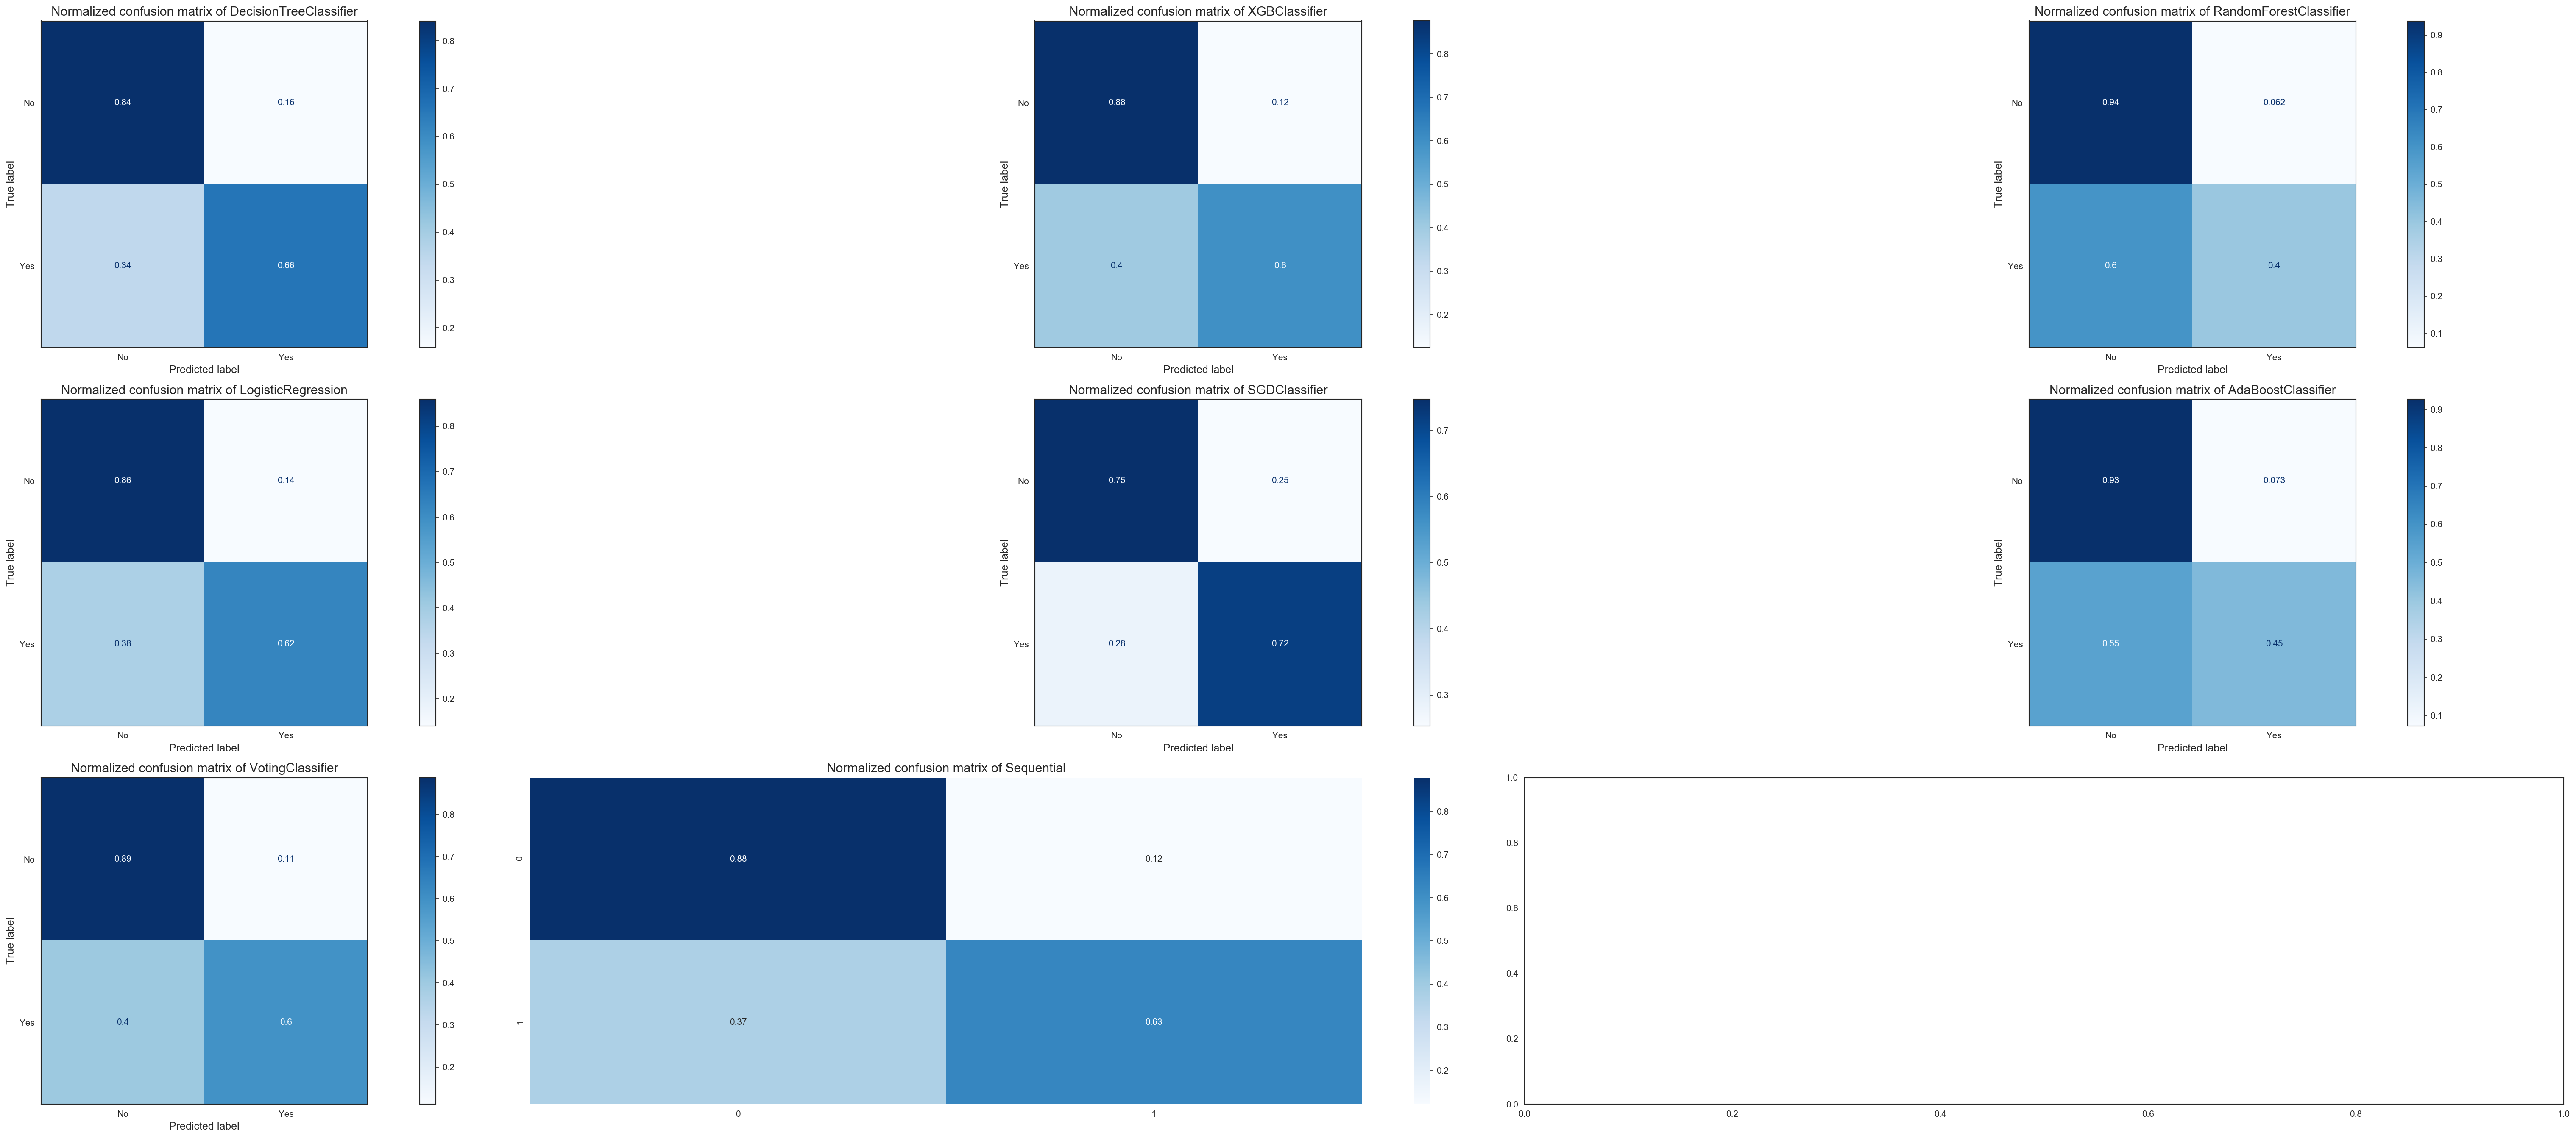

In [48]:
binary_testing([tree_clf,xgb_clf,rf_clf,log_clf,sdg_clf,ada_clf,voting_clf,ann_clf],X_test,y_test)

# Conclusion
- Voting Classifier >= Nural Network > others

# 6. Feature Importance
- TODO: add labels

### XGboost

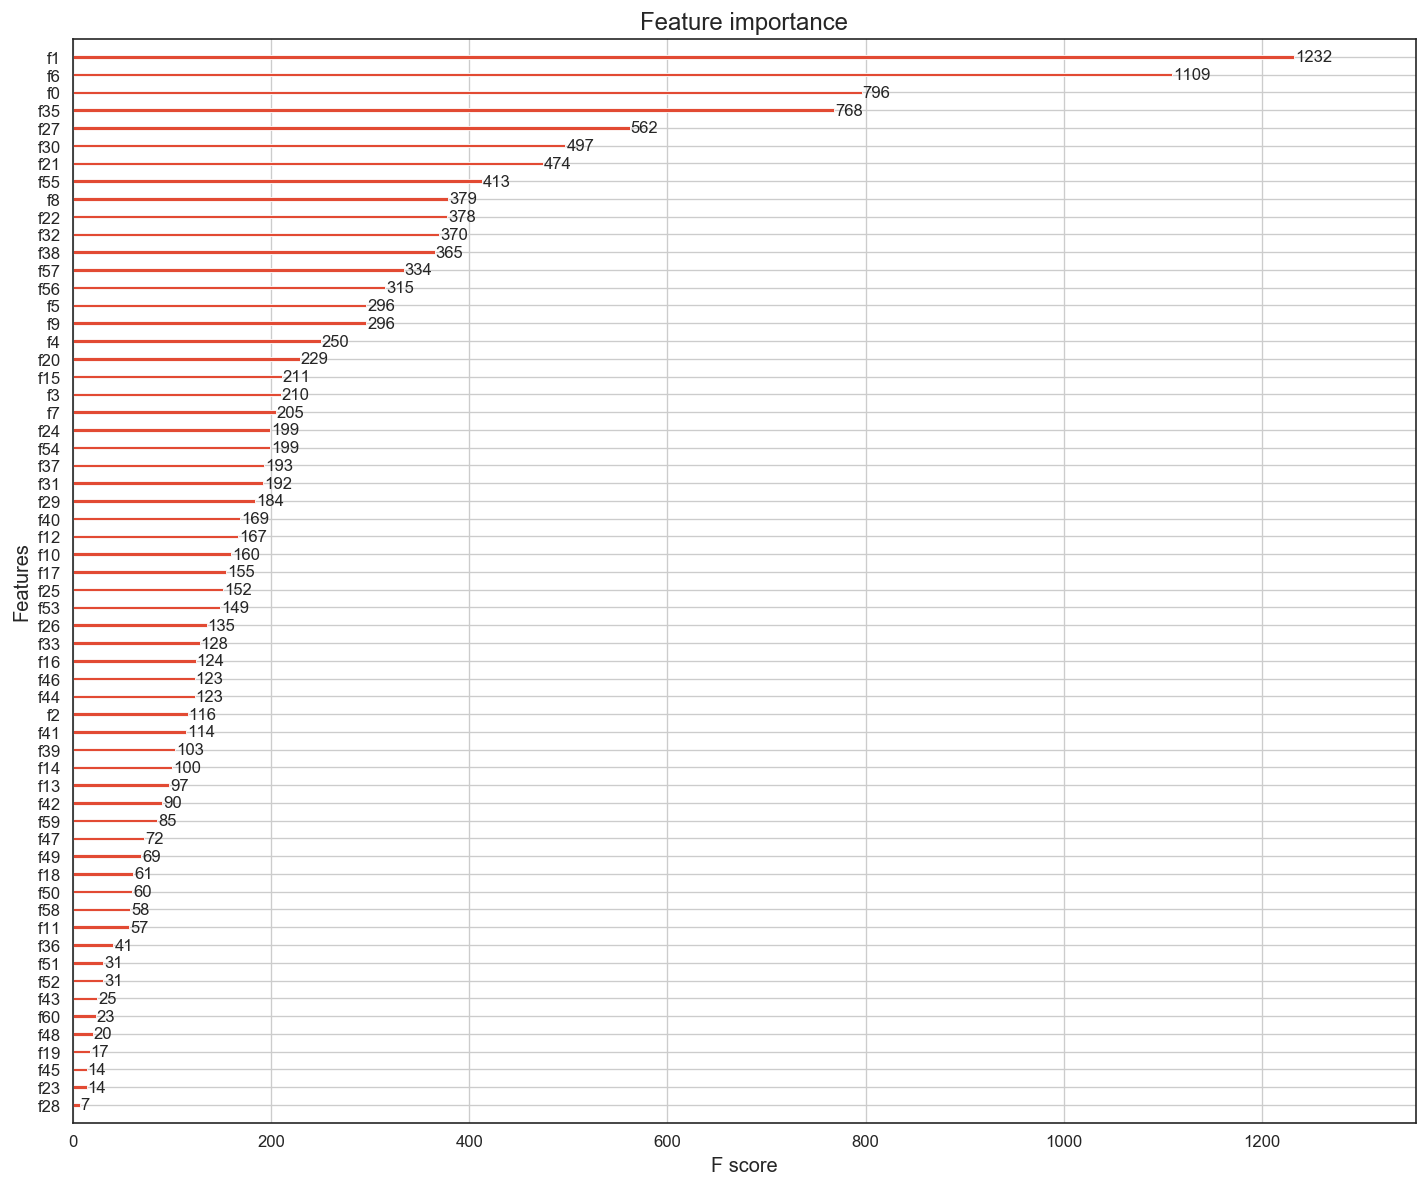

In [54]:
fig,ax = plt.subplots(figsize = (12,10),dpi = 120)
xgb.plot_importance(xgb_clf,ax =ax)
plt.tight_layout()

### Random Forest

Feature ranking:
1. feature 0 (0.146105)
2. feature 6 (0.126366)
3. feature 1 (0.082804)
4. feature 7 (0.072661)
5. feature 4 (0.047484)
6. feature 5 (0.031671)
7. feature 2 (0.020797)
8. feature 37 (0.019066)
9. feature 35 (0.019013)
10. feature 8 (0.016602)
11. feature 21 (0.016459)
12. feature 27 (0.015565)
13. feature 30 (0.015043)
14. feature 22 (0.014666)
15. feature 54 (0.014000)
16. feature 60 (0.013975)
17. feature 9 (0.013759)
18. feature 38 (0.013551)
19. feature 55 (0.013549)
20. feature 57 (0.013356)
21. feature 53 (0.013341)
22. feature 40 (0.013259)
23. feature 17 (0.013131)
24. feature 56 (0.013017)
25. feature 42 (0.012924)
26. feature 3 (0.012914)
27. feature 26 (0.012202)
28. feature 33 (0.010808)
29. feature 29 (0.010778)
30. feature 20 (0.010651)
31. feature 32 (0.010434)
32. feature 49 (0.010215)
33. feature 41 (0.010192)
34. feature 15 (0.010068)
35. feature 12 (0.009385)
36. feature 24 (0.007874)
37. feature 59 (0.007493)
38. feature 25 (0.007444)
39. feature 14

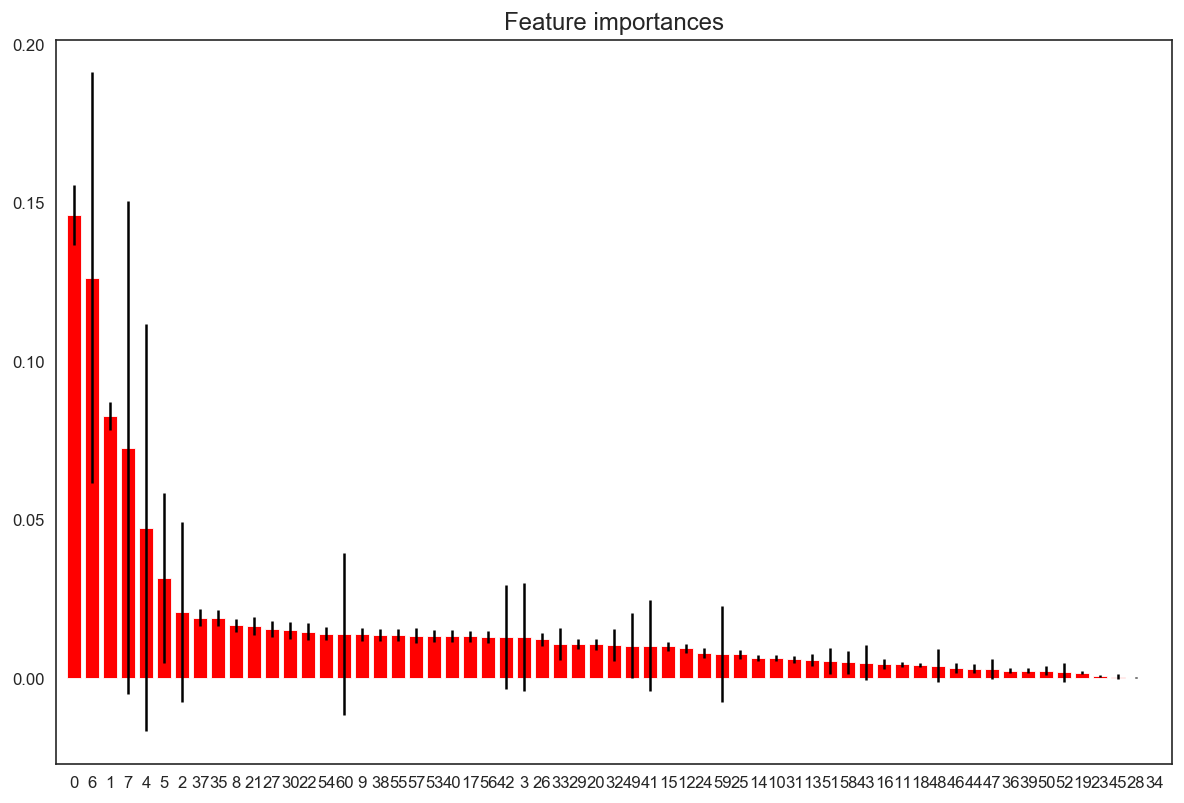

In [51]:
X = X_test.copy()
importances = rf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize = (12,8),dpi = 120)
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()


# 7. Time Series Prediction Testing

In [ ]:
# TODO